In [28]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Colab Notebooks/LAB_mod_B/Project
import sys
import json
print(sys.executable)

/home/samu/miniconda3/envs/myenv/bin/python


# Importing libraries

In [4]:
!pip install torch torchvision torchaudio


In [8]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm import tqdm
import optuna
from sklearn.model_selection import KFold
import functools

#from sklearn.model_selection import TimeSeriesSplit

## Imporiting Data

In [9]:
# we use as temporal info the day of the year (1...365)
df_features = pd.read_csv("IT_NORD_VAE_input.csv")

features = ['timestamp', 'day_sin_t0','day_cos_t0',
           'day_sin_t1','day_cos_t1',
           'day_sin_t2','day_cos_t2',
           'day_sin_t3','day_cos_t3',
           'day_sin_t4','day_cos_t4',
           'day_sin_t5','day_cos_t5',
           'day_sin_t6','day_cos_t6',
           'day_sin_t7','day_cos_t7',
           'day_sin_t8','day_cos_t8',
           'month_sin_t0','month_cos_t0',
           'month_sin_t1','month_cos_t1',
           'month_sin_t2','month_cos_t2',
           'month_sin_t3','month_cos_t3',
           'month_sin_t4','month_cos_t4',
           'month_sin_t5','month_cos_t5',
           'month_sin_t6','month_cos_t6',
           'month_sin_t7','month_cos_t7',
           'month_sin_t8','month_cos_t8',
            'Unnamed: 0']

# in alternative one can use the following lines to keep day and month time info
'''
features = ['sin_dayofyear_t0','cos_dayofyear_t0',
            'sin_dayofyear_t1','cos_dayofyear_t1',
            'sin_dayofyear_t2','cos_dayofyear_t2',
            'sin_dayofyear_t3','cos_dayofyear_t3',
            'sin_dayofyear_t4','cos_dayofyear_t4',
            'sin_dayofyear_t5','cos_dayofyear_t5',
            'sin_dayofyear_t6','cos_dayofyear_t6',
            'sin_dayofyear_t7','cos_dayofyear_t7',
            'sin_dayofyear_t8','cos_dayofyear_t8','Unnamed: 0'] '''

df_features = df_features.drop(columns = features).iloc[:, 0:20]
df_features.shape

(8320, 20)

In [10]:
df_features.head()

,year_t0,2t_t0,solar_t0,tp_t0,ws_10m_t0,ws_100m_t0,hour_sin_t0,hour_cos_t0,sin_dayofyear_t0,cos_dayofyear_t0,year_t1,2t_t1,solar_t1,tp_t1,ws_10m_t1,ws_100m_t1,hour_sin_t1,hour_cos_t1,sin_dayofyear_t1,cos_dayofyear_t1
0,-1.224855,-1.266622,-0.785197,-0.540314,-0.169929,0.237315,0.249009,1.890047,0.025562,1.291842,-1.22515,-1.324388,-0.785197,-0.540313,-0.166965,0.001266,1.183622,1.408711,0.025565,1.291842
1,-1.224855,-1.324489,-0.785197,-0.540314,-0.167036,0.001132,1.183829,1.408519,0.025562,1.291842,-1.22515,-1.363017,-0.691746,-0.543041,-0.218534,-0.093002,1.570805,0.246088,0.025565,1.291842
2,-1.224855,-1.363120,-0.691746,-0.543042,-0.218606,-0.093139,1.571044,0.246007,0.025562,1.291842,-1.22515,-1.091346,0.355950,-0.543041,-0.396870,-0.529850,1.183622,-0.916535,0.025565,1.291842
3,-1.224855,-1.091436,0.355950,-0.543042,-0.396948,-0.530006,1.183829,-0.916506,0.025562,1.291842,-1.22515,-0.496896,0.545301,-0.543041,-0.719747,-0.962824,0.248877,-1.398110,0.025565,1.291842
4,-1.224855,-0.496955,0.545301,-0.543042,-0.719834,-0.962998,0.249009,-1.398034,0.025562,1.291842,-1.22515,-0.515202,-0.492313,-0.543041,-0.807978,-1.115623,-0.685868,-0.916535,0.025565,1.291842


Separate training and testing data

In [11]:
# Custom PyTorch Dataset
class TabularDataset(Dataset):                         # to use PyTorch's DataLoader
    def __init__(self, data_tensor):
        self.data = data_tensor

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index], 0  # dummy label

n_samples = len(df_features)
split_idx = int(n_samples * 0.8)
INPUT_DIM = df_features.shape[1]

train_data = df_features[:split_idx]
test_data = df_features[split_idx:]

train_tensor = torch.tensor(train_data.values, dtype=torch.float32)
test_tensor = torch.tensor(test_data.values, dtype=torch.float32)

train_dataset = TabularDataset(train_tensor)
test_dataset = TabularDataset(test_tensor)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)     # no shuffle
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

print("Input Dim:", INPUT_DIM)
print("Training Dataframe Dim:", train_loader.dataset.data.shape)
print("Testing Dataframe Dim:", test_loader.dataset.data.shape)

Input Dim: 20
Training Dataframe Dim: torch.Size([6656, 20])
Testing Dataframe Dim: torch.Size([1664, 20])


# Model Definition

In [12]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim1, z_dim, h_dim2, activation):
        super(VariationalAutoEncoder, self).__init__()

        # encoder
        self.fc1 = nn.Linear(input_dim, h_dim1)
        self.batch1 =  nn.BatchNorm1d(h_dim1)
        self.fc_mu = nn.Linear(h_dim1, z_dim)
        self.fc_sigma = nn.Linear(h_dim1, z_dim)

        # decoder
        self.fc2 = nn.Linear(z_dim, h_dim2)
        self.batch2 = nn.BatchNorm1d(h_dim2)
        self.fc3 = nn.Linear(h_dim2, input_dim)
        self.activation = activation

    def encode(self, x):
        h1 = self.activation(self.batch1(self.fc1(x)))
        mu, sigma = self.fc_mu(h1), self.fc_sigma(h1)
        return mu, sigma

    def decode(self, z):
        h = self.activation(self.batch2(self.fc2(z)))
        return self.fc3(h)

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma*epsilon
        x_reconstructed = self.decode(z_new)
        return x_reconstructed, mu, sigma

# Training Process

The hyperparameters we need to specify the architecture and train the VAE are:
* `INPUT_DIM`: the dimension of the **input** for the encoder
* `H_DIM`: the dimension of the **hidden layers** for encoders and decoders
* `Z_DIM`: the dimension of the **latent space**
* `BATCH_SIZE`, `NUM_EPOCHS`, `LR_RATE`: optimization hyper-parameters

Definisco la funzione per il training di una fold

In [13]:
def train_one_fold(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=15, z_dim=2):
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  history = {
      'total_loss': [],
      'reconstruction_loss': [],
      'kl_div': [],
      'val_total_loss': [],
      'val_reconstruction_loss': [],
      'val_kl_div': []
  }
  outputs = []

  for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    model.train()
    loop = tqdm(train_loader, desc=f"Z_DIM = {z_dim} | Epoch {epoch+1}/{num_epochs}")

    for i, (x_batch, _) in enumerate(loop):
      x_batch = x_batch.to(DEVICE)
      x_reconstructed, mu, sigma = model(x_batch)

      # Loss Function
      reconstruction_loss = loss_fn(x_reconstructed, x_batch)
      logvar = torch.log(sigma.pow(2) + 1e-8)
      kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      loss = reconstruction_loss + kl_div

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loop.set_postfix(                                               # sto decidendo che info printare nella barra che vedo ad ogni epoca
          total_loss=loss.item(),
          reconstruction_loss=reconstruction_loss.item(),
          kl_div=kl_div.item())

      epoch_loss += loss.item()
      epoch_recon += reconstruction_loss.item()
      epoch_kl += kl_div.item()

      if i == 0:
        outputs.append((epoch, x_batch.clone(), x_reconstructed.clone()))

    # Compute and store averages after each epoch
    history['total_loss'].append(epoch_loss / len(train_loader.dataset))                     # appendo la loss (mediata dopo tutti i batches - quindi per un'intera epoca)
    history['reconstruction_loss'].append(epoch_recon / len(train_loader.dataset))
    history['kl_div'].append(epoch_kl / len(train_loader.dataset))

    # Validation
    model.eval()
    val_total = 0
    val_recon = 0
    val_kl = 0

    with torch.no_grad():
      for x_val, _ in val_loader:
        x_val = x_val.to(DEVICE)
        x_reconstructed, mu, sigma = model(x_val)
        loss_rec = loss_fn(x_reconstructed, x_val)
        logvar = torch.log(sigma.pow(2) + 1e-8)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = loss_rec + kl_div

        val_total += loss.item()
        val_recon += loss_rec.item()
        val_kl += kl_div.item()

    history['val_total_loss'].append(val_total / len(val_loader.dataset))
    history['val_reconstruction_loss'].append(val_recon / len(val_loader.dataset))
    history['val_kl_div'].append(val_kl / len(val_loader.dataset))

  return history

K-Fold Loop and Hyperparameter Grid

In [14]:
''' k-fold cross validation classico '''
def get_activation(name):
  return {
      "relu": nn.ReLU(),
      "sigmoid": nn.Sigmoid(),
      "leaky_relu": nn.LeakyReLU()}[name]

def objective(trial, train_tensor, INPUT_DIM):
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  full_tensor = train_tensor
  # hyperparameters
  h_dim1 = trial.suggest_int('h_dim1', 16, 128, step=8)                                     # setta qui gli hyperparametri
  h_dim2 = trial.suggest_int('h_dim2', 16, 128, step=8)
  z_dim = trial.suggest_int('z_dim', 2, 14, step=2)
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
  batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

  act_name = trial.suggest_categorical("activation", ["relu", "sigmoid", "leaky_relu"])

  activation_fn = get_activation(act_name)

  kf = KFold(n_splits=5, shuffle=False)                                                     # 5 fold
  val_losses = []

  for train_idx, val_idx in kf.split(full_tensor):
    train_test = full_tensor[train_idx]
    val_test = full_tensor[val_idx]

    train_loader = DataLoader(TabularDataset(train_test), batch_size=128, shuffle=False)
    val_loader = DataLoader(TabularDataset(val_test), batch_size=128, shuffle=False)

    model = VariationalAutoEncoder(
        INPUT_DIM, h_dim1, z_dim, h_dim2,
        activation_fn).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss(reduction="sum")

    history = train_one_fold(model, train_loader, val_loader, optimizer, loss_fn, DEVICE, num_epochs=100, z_dim=z_dim)           # settare qui il numero di epochs

    val_losses.append(history['val_total_loss'][-1])

  avg_val_loss = np.mean(val_losses)
  return avg_val_loss

In [15]:
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10))

study.optimize(functools.partial(objective, train_tensor=train_tensor, INPUT_DIM=INPUT_DIM), n_trials=50, catch=(Exception,))

[I 2025-05-22 16:28:02,882] A new study created in memory with name: no-name-4739f9a3-1c05-4716-9c6b-19a2e1e13328
/tmp/ipykernel_2080/3482621803.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
Z_DIM = 14 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 85.50it/s, kl_div=1.1e+3, reconstruction_loss=2.02e+3, total_loss=
Z_DIM = 14 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 304.61it/s, kl_div=1.04e+3, reconstruction_loss=1.96e+3, total_los
Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 312.37it/s, kl_div=999, reconstruction_loss=1.91e+3, total_loss=2.
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 298.56it/s, kl_div=978, reconstruction_loss=1.82e+3, total_loss=2.
Z_DIM = 14 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 307.72it/s, kl_div=948, reconstruction_loss=1.78e+3, to

Z_DIM = 14 | Epoch 65/100: 100%|█| 42/42 [00:00<00:00, 336.06it/s, kl_div=572, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 14 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 282.14it/s, kl_div=582, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 14 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 299.01it/s, kl_div=574, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 14 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 288.39it/s, kl_div=568, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 14 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 286.55it/s, kl_div=567, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 280.44it/s, kl_div=562, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 288.38it/s, kl_div=560, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 14 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 294.93it/s, kl_div=559, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 14 | Epoch 73/100: 100%|

Z_DIM = 14 | Epoch 32/100: 100%|█| 42/42 [00:00<00:00, 325.16it/s, kl_div=657, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 14 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 338.47it/s, kl_div=652, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 363.89it/s, kl_div=637, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 14 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 337.99it/s, kl_div=633, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 14 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 354.54it/s, kl_div=617, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 334.96it/s, kl_div=616, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 331.39it/s, kl_div=609, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 345.22it/s, kl_div=591, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 40/100: 100%|

Z_DIM = 14 | Epoch 99/100: 100%|█| 42/42 [00:00<00:00, 339.56it/s, kl_div=409, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 14 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 343.22it/s, kl_div=413, reconstruction_loss=1.16e+3, total_loss=
Z_DIM = 14 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 324.05it/s, kl_div=1.08e+3, reconstruction_loss=2.05e+3, total_los
Z_DIM = 14 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 326.13it/s, kl_div=1.02e+3, reconstruction_loss=1.94e+3, total_los
Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 340.92it/s, kl_div=973, reconstruction_loss=1.9e+3, total_loss=2.8
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 327.70it/s, kl_div=929, reconstruction_loss=1.87e+3, total_loss=2.
Z_DIM = 14 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 327.91it/s, kl_div=893, reconstruction_loss=1.85e+3, total_loss=2.
Z_DIM = 14 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 346.13it/s, kl_div=870, reconstruction_loss=1.81e+3, total_loss=2.
Z_DIM = 14 | Epoch 7/100: 100%|█

Z_DIM = 14 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 309.84it/s, kl_div=422, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 14 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 294.57it/s, kl_div=421, reconstruction_loss=1.43e+3, total_loss=1
Z_DIM = 14 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 318.58it/s, kl_div=417, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 14 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 324.19it/s, kl_div=417, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 280.37it/s, kl_div=418, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 224.87it/s, kl_div=423, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 284.95it/s, kl_div=418, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 14 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 309.67it/s, kl_div=414, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 14 | Epoch 74/100: 100%|

Z_DIM = 14 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 296.52it/s, kl_div=556, reconstruction_loss=1.49e+3, total_loss=2
Z_DIM = 14 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 296.88it/s, kl_div=542, reconstruction_loss=1.48e+3, total_loss=2
Z_DIM = 14 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 302.08it/s, kl_div=534, reconstruction_loss=1.46e+3, total_loss=1
Z_DIM = 14 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 299.35it/s, kl_div=532, reconstruction_loss=1.51e+3, total_loss=2
Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 322.74it/s, kl_div=533, reconstruction_loss=1.5e+3, total_loss=2.
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 293.08it/s, kl_div=538, reconstruction_loss=1.51e+3, total_loss=2
Z_DIM = 14 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 325.83it/s, kl_div=527, reconstruction_loss=1.45e+3, total_loss=1
Z_DIM = 14 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 275.46it/s, kl_div=528, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 14 | Epoch 41/100: 100%|

Z_DIM = 14 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 313.57it/s, kl_div=402, reconstruction_loss=1.39e+3, total_loss=
Z_DIM = 14 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 281.09it/s, kl_div=1.31e+3, reconstruction_loss=1.84e+3, total_los
Z_DIM = 14 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 333.86it/s, kl_div=1.24e+3, reconstruction_loss=1.82e+3, total_los
Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 311.74it/s, kl_div=1.2e+3, reconstruction_loss=1.74e+3, total_loss
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 308.21it/s, kl_div=1.18e+3, reconstruction_loss=1.68e+3, total_los
Z_DIM = 14 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 258.16it/s, kl_div=1.15e+3, reconstruction_loss=1.57e+3, total_los
Z_DIM = 14 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 261.15it/s, kl_div=1.11e+3, reconstruction_loss=1.58e+3, total_los
Z_DIM = 14 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 243.32it/s, kl_div=1.09e+3, reconstruction_loss=1.5e+3, total_loss
Z_DIM = 14 | Epoch 8/100: 100%|█

Z_DIM = 14 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 321.68it/s, kl_div=650, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 309.60it/s, kl_div=646, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 14 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 306.39it/s, kl_div=641, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 308.59it/s, kl_div=638, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 324.90it/s, kl_div=632, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 320.51it/s, kl_div=626, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 217.40it/s, kl_div=637, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 14 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 269.26it/s, kl_div=637, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 75/100: 100%|

Z_DIM = 14 | Epoch 30/100: 100%|█| 42/42 [00:00<00:00, 309.41it/s, kl_div=369, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 14 | Epoch 31/100: 100%|█| 42/42 [00:00<00:00, 313.60it/s, kl_div=359, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 14 | Epoch 32/100: 100%|█| 42/42 [00:00<00:00, 316.85it/s, kl_div=364, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 14 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 329.09it/s, kl_div=362, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 14 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 341.11it/s, kl_div=325, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 14 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 310.80it/s, kl_div=322, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 317.84it/s, kl_div=342, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 330.83it/s, kl_div=309, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|

Z_DIM = 14 | Epoch 97/100: 100%|█| 42/42 [00:00<00:00, 314.45it/s, kl_div=279, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 98/100: 100%|█| 42/42 [00:00<00:00, 320.31it/s, kl_div=271, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 99/100: 100%|█| 42/42 [00:00<00:00, 316.20it/s, kl_div=281, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 314.78it/s, kl_div=274, reconstruction_loss=1.11e+3, total_loss=
Z_DIM = 14 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 326.04it/s, kl_div=748, reconstruction_loss=1.6e+3, total_loss=2.3
Z_DIM = 14 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 302.20it/s, kl_div=577, reconstruction_loss=1.44e+3, total_loss=2.
Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 328.53it/s, kl_div=492, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 321.09it/s, kl_div=435, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 14 | Epoch 5/100: 100%|█

Z_DIM = 14 | Epoch 64/100: 100%|█| 42/42 [00:00<00:00, 312.31it/s, kl_div=263, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 65/100: 100%|█| 42/42 [00:00<00:00, 313.91it/s, kl_div=264, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 313.03it/s, kl_div=262, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 307.75it/s, kl_div=266, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 14 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 290.21it/s, kl_div=262, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 14 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 292.93it/s, kl_div=261, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 283.46it/s, kl_div=265, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 291.82it/s, kl_div=275, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|

Z_DIM = 14 | Epoch 31/100: 100%|█| 42/42 [00:00<00:00, 339.70it/s, kl_div=292, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 14 | Epoch 32/100: 100%|█| 42/42 [00:00<00:00, 329.87it/s, kl_div=295, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 14 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 342.51it/s, kl_div=290, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 14 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 353.03it/s, kl_div=277, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 14 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 321.76it/s, kl_div=280, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 14 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 324.24it/s, kl_div=272, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 337.84it/s, kl_div=266, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 345.08it/s, kl_div=280, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|

Z_DIM = 14 | Epoch 98/100: 100%|█| 42/42 [00:00<00:00, 288.58it/s, kl_div=255, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 14 | Epoch 99/100: 100%|█| 42/42 [00:00<00:00, 309.13it/s, kl_div=251, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 14 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 322.39it/s, kl_div=259, reconstruction_loss=1.26e+3, total_loss=
Z_DIM = 14 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 327.20it/s, kl_div=690, reconstruction_loss=1.87e+3, total_loss=2.
Z_DIM = 14 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 330.70it/s, kl_div=506, reconstruction_loss=1.66e+3, total_loss=2.
Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 325.74it/s, kl_div=441, reconstruction_loss=1.58e+3, total_loss=2.
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 248.95it/s, kl_div=434, reconstruction_loss=1.56e+3, total_loss=1.
Z_DIM = 14 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 298.55it/s, kl_div=447, reconstruction_loss=1.49e+3, total_loss=1.
Z_DIM = 14 | Epoch 6/100: 100%|█

Z_DIM = 14 | Epoch 65/100: 100%|█| 42/42 [00:00<00:00, 303.21it/s, kl_div=262, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 14 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 307.28it/s, kl_div=265, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 14 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 321.24it/s, kl_div=262, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 14 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 297.36it/s, kl_div=265, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 14 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 307.27it/s, kl_div=263, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 311.75it/s, kl_div=268, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 317.58it/s, kl_div=266, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 290.86it/s, kl_div=262, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 14 | Epoch 73/100: 100%|

Z_DIM = 14 | Epoch 32/100: 100%|█| 42/42 [00:00<00:00, 339.51it/s, kl_div=325, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 14 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 322.05it/s, kl_div=327, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 14 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 339.99it/s, kl_div=322, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 14 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 338.23it/s, kl_div=328, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 14 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 350.44it/s, kl_div=337, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 357.96it/s, kl_div=330, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 336.36it/s, kl_div=334, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 346.54it/s, kl_div=329, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 14 | Epoch 40/100: 100%|

Z_DIM = 14 | Epoch 99/100: 100%|█| 42/42 [00:00<00:00, 343.23it/s, kl_div=295, reconstruction_loss=934, total_loss=1.23e
Z_DIM = 14 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 353.16it/s, kl_div=293, reconstruction_loss=924, total_loss=1.22
[I 2025-05-22 16:30:37,527] Trial 1 finished with value: 15.81644825793794 and parameters: {'h_dim1': 32, 'h_dim2': 24, 'z_dim': 14, 'lr': 0.0028394572093255457, 'batch_size': 16, 'activation': 'relu'}. Best is trial 1 with value: 15.81644825793794.
Z_DIM = 14 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 333.11it/s, kl_div=1.17e+3, reconstruction_loss=1.99e+3, total_los
Z_DIM = 14 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 347.43it/s, kl_div=1.12e+3, reconstruction_loss=1.91e+3, total_los
Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 341.51it/s, kl_div=1.06e+3, reconstruction_loss=1.79e+3, total_los
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 346.55it/s, kl_div=1.02e+3, reconstruction_loss=1.68e+3, total_los
Z_DIM = 14 | Epoch 5/100

Z_DIM = 14 | Epoch 64/100: 100%|█| 42/42 [00:00<00:00, 312.10it/s, kl_div=535, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 14 | Epoch 65/100: 100%|█| 42/42 [00:00<00:00, 342.21it/s, kl_div=528, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 329.64it/s, kl_div=527, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 343.96it/s, kl_div=520, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 14 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 324.19it/s, kl_div=516, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 14 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 324.38it/s, kl_div=517, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 313.76it/s, kl_div=517, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 333.78it/s, kl_div=514, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|

Z_DIM = 14 | Epoch 31/100: 100%|█| 42/42 [00:00<00:00, 284.05it/s, kl_div=665, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 32/100: 100%|█| 42/42 [00:00<00:00, 288.53it/s, kl_div=664, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 268.55it/s, kl_div=650, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 289.80it/s, kl_div=652, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 14 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 298.81it/s, kl_div=642, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 14 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 294.37it/s, kl_div=635, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 337.84it/s, kl_div=633, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 317.22it/s, kl_div=626, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|

Z_DIM = 14 | Epoch 98/100: 100%|█| 42/42 [00:00<00:00, 305.78it/s, kl_div=490, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 14 | Epoch 99/100: 100%|█| 42/42 [00:00<00:00, 317.74it/s, kl_div=495, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 14 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 300.78it/s, kl_div=479, reconstruction_loss=1.15e+3, total_loss=
Z_DIM = 14 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 303.93it/s, kl_div=1.33e+3, reconstruction_loss=2.04e+3, total_los
Z_DIM = 14 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 266.50it/s, kl_div=1.28e+3, reconstruction_loss=1.9e+3, total_loss
Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 233.95it/s, kl_div=1.24e+3, reconstruction_loss=1.84e+3, total_los
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 225.85it/s, kl_div=1.21e+3, reconstruction_loss=1.76e+3, total_los
Z_DIM = 14 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 294.66it/s, kl_div=1.17e+3, reconstruction_loss=1.68e+3, total_los
Z_DIM = 14 | Epoch 6/100: 100%|█

Z_DIM = 14 | Epoch 65/100: 100%|█| 42/42 [00:00<00:00, 326.15it/s, kl_div=501, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 14 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 327.79it/s, kl_div=492, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 14 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 335.49it/s, kl_div=488, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 14 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 322.11it/s, kl_div=484, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 14 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 335.12it/s, kl_div=483, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 339.01it/s, kl_div=479, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 345.18it/s, kl_div=480, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 325.95it/s, kl_div=477, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 14 | Epoch 73/100: 100%|

Z_DIM = 14 | Epoch 32/100: 100%|█| 42/42 [00:00<00:00, 327.86it/s, kl_div=564, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 14 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 320.13it/s, kl_div=558, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 14 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 322.58it/s, kl_div=550, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 14 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 309.84it/s, kl_div=546, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 14 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 308.99it/s, kl_div=543, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 306.28it/s, kl_div=527, reconstruction_loss=1.43e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 332.53it/s, kl_div=522, reconstruction_loss=1.44e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 333.22it/s, kl_div=519, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 14 | Epoch 40/100: 100%|

Z_DIM = 14 | Epoch 99/100: 100%|█| 42/42 [00:00<00:00, 315.25it/s, kl_div=423, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 14 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 316.15it/s, kl_div=423, reconstruction_loss=1.34e+3, total_loss=
Z_DIM = 14 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 317.44it/s, kl_div=1.28e+3, reconstruction_loss=1.59e+3, total_los
Z_DIM = 14 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 315.26it/s, kl_div=1.2e+3, reconstruction_loss=1.52e+3, total_loss
Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 307.57it/s, kl_div=1.15e+3, reconstruction_loss=1.44e+3, total_los
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 296.88it/s, kl_div=1.14e+3, reconstruction_loss=1.39e+3, total_los
Z_DIM = 14 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 303.49it/s, kl_div=1.12e+3, reconstruction_loss=1.34e+3, total_los
Z_DIM = 14 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 300.81it/s, kl_div=1.11e+3, reconstruction_loss=1.31e+3, total_los
Z_DIM = 14 | Epoch 7/100: 100%|█

Z_DIM = 14 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 292.48it/s, kl_div=575, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 14 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 312.33it/s, kl_div=577, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 14 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 297.88it/s, kl_div=576, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 14 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 302.52it/s, kl_div=578, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 311.66it/s, kl_div=576, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 309.04it/s, kl_div=567, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 307.07it/s, kl_div=568, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 14 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 324.76it/s, kl_div=562, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 14 | Epoch 74/100: 100%|

Z_DIM = 10 | Epoch 31/100: 100%|█| 42/42 [00:00<00:00, 307.62it/s, kl_div=281, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 32/100: 100%|█| 42/42 [00:00<00:00, 339.62it/s, kl_div=277, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 321.73it/s, kl_div=282, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 331.07it/s, kl_div=281, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 51.67it/s, kl_div=268, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 10 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 325.78it/s, kl_div=265, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 315.59it/s, kl_div=288, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 325.17it/s, kl_div=266, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 39/100: 100%|

Z_DIM = 10 | Epoch 98/100: 100%|█| 42/42 [00:00<00:00, 357.89it/s, kl_div=312, reconstruction_loss=894, total_loss=1.21e
Z_DIM = 10 | Epoch 99/100: 100%|█| 42/42 [00:00<00:00, 343.84it/s, kl_div=293, reconstruction_loss=922, total_loss=1.21e
Z_DIM = 10 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 360.18it/s, kl_div=311, reconstruction_loss=905, total_loss=1.22
Z_DIM = 10 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 348.32it/s, kl_div=160, reconstruction_loss=1.77e+3, total_loss=1.
Z_DIM = 10 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 369.25it/s, kl_div=207, reconstruction_loss=1.5e+3, total_loss=1.7
Z_DIM = 10 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 366.30it/s, kl_div=224, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 10 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 351.00it/s, kl_div=226, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 336.85it/s, kl_div=226, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 10 | Epoch 6/100: 100%|█

Z_DIM = 10 | Epoch 65/100: 100%|█| 42/42 [00:00<00:00, 327.96it/s, kl_div=267, reconstruction_loss=979, total_loss=1.25e
Z_DIM = 10 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 317.67it/s, kl_div=269, reconstruction_loss=977, total_loss=1.25e
Z_DIM = 10 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 317.66it/s, kl_div=274, reconstruction_loss=981, total_loss=1.26e
Z_DIM = 10 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 336.67it/s, kl_div=262, reconstruction_loss=967, total_loss=1.23e
Z_DIM = 10 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 326.11it/s, kl_div=277, reconstruction_loss=980, total_loss=1.26e
Z_DIM = 10 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 326.85it/s, kl_div=269, reconstruction_loss=989, total_loss=1.26e
Z_DIM = 10 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 329.26it/s, kl_div=269, reconstruction_loss=981, total_loss=1.25e
Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 349.04it/s, kl_div=286, reconstruction_loss=959, total_loss=1.24e
Z_DIM = 10 | Epoch 73/100: 100%|

Z_DIM = 10 | Epoch 32/100: 100%|█| 42/42 [00:00<00:00, 329.19it/s, kl_div=264, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 312.21it/s, kl_div=262, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 321.67it/s, kl_div=257, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 309.46it/s, kl_div=253, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 10 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 328.03it/s, kl_div=261, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 327.20it/s, kl_div=273, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 314.05it/s, kl_div=261, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 328.64it/s, kl_div=270, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 40/100: 100%|

Z_DIM = 10 | Epoch 99/100: 100%|█| 42/42 [00:00<00:00, 332.26it/s, kl_div=289, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 337.25it/s, kl_div=261, reconstruction_loss=1.2e+3, total_loss=1
Z_DIM = 10 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 339.05it/s, kl_div=197, reconstruction_loss=1.71e+3, total_loss=1.
Z_DIM = 10 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 320.47it/s, kl_div=204, reconstruction_loss=1.71e+3, total_loss=1.
Z_DIM = 10 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 341.08it/s, kl_div=208, reconstruction_loss=1.58e+3, total_loss=1.
Z_DIM = 10 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 338.99it/s, kl_div=210, reconstruction_loss=1.57e+3, total_loss=1.
Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 327.66it/s, kl_div=216, reconstruction_loss=1.5e+3, total_loss=1.7
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 325.79it/s, kl_div=223, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 10 | Epoch 7/100: 100%|█

Z_DIM = 10 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 329.46it/s, kl_div=275, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 10 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 322.09it/s, kl_div=274, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 10 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 335.03it/s, kl_div=275, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 10 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 333.76it/s, kl_div=278, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 10 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 306.66it/s, kl_div=263, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 330.30it/s, kl_div=263, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 356.27it/s, kl_div=265, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 333.74it/s, kl_div=269, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 74/100: 100%|

Z_DIM = 10 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 351.56it/s, kl_div=280, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 343.90it/s, kl_div=282, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 342.90it/s, kl_div=239, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 342.47it/s, kl_div=252, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 346.42it/s, kl_div=253, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 338.60it/s, kl_div=243, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 340.27it/s, kl_div=248, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 349.30it/s, kl_div=280, reconstruction_loss=993, total_loss=1.27e
Z_DIM = 10 | Epoch 41/100: 100%|

Z_DIM = 10 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 351.82it/s, kl_div=319, reconstruction_loss=622, total_loss=941]
[I 2025-05-22 16:33:04,424] Trial 3 finished with value: 14.869661019431812 and parameters: {'h_dim1': 72, 'h_dim2': 72, 'z_dim': 10, 'lr': 0.0035565291147132993, 'batch_size': 64, 'activation': 'sigmoid'}. Best is trial 3 with value: 14.869661019431812.
Z_DIM = 8 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 331.67it/s, kl_div=316, reconstruction_loss=1.3e+3, total_loss=1.62
Z_DIM = 8 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 334.02it/s, kl_div=309, reconstruction_loss=1.2e+3, total_loss=1.51
Z_DIM = 8 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 330.72it/s, kl_div=279, reconstruction_loss=1.22e+3, total_loss=1.5
Z_DIM = 8 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 334.13it/s, kl_div=278, reconstruction_loss=1.22e+3, total_loss=1.4
Z_DIM = 8 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 321.50it/s, kl_div=288, reconstruction_loss=1.23e+3, total_loss=1.5
Z_DIM = 8 | Epoch 6

Z_DIM = 8 | Epoch 65/100: 100%|█| 42/42 [00:00<00:00, 314.52it/s, kl_div=300, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 316.50it/s, kl_div=284, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 322.74it/s, kl_div=317, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 301.83it/s, kl_div=328, reconstruction_loss=958, total_loss=1.29e+
Z_DIM = 8 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 288.20it/s, kl_div=338, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 8 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 319.72it/s, kl_div=332, reconstruction_loss=987, total_loss=1.32e+
Z_DIM = 8 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 309.88it/s, kl_div=313, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 8 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 289.29it/s, kl_div=339, reconstruction_loss=992, total_loss=1.33e+
Z_DIM = 8 | Epoch 73/100: 100%|█

Z_DIM = 8 | Epoch 32/100: 100%|█| 42/42 [00:00<00:00, 297.85it/s, kl_div=274, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 306.38it/s, kl_div=253, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 8 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 297.35it/s, kl_div=248, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 312.80it/s, kl_div=244, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 8 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 301.53it/s, kl_div=256, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 8 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 319.86it/s, kl_div=255, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 8 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 275.63it/s, kl_div=253, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 8 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 284.43it/s, kl_div=261, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 8 | Epoch 40/100: 100%|█

Z_DIM = 8 | Epoch 99/100: 100%|█| 42/42 [00:00<00:00, 327.48it/s, kl_div=294, reconstruction_loss=892, total_loss=1.19e+
Z_DIM = 8 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 321.31it/s, kl_div=303, reconstruction_loss=921, total_loss=1.22e
Z_DIM = 8 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 325.74it/s, kl_div=425, reconstruction_loss=1.5e+3, total_loss=1.93
Z_DIM = 8 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 296.55it/s, kl_div=345, reconstruction_loss=1.5e+3, total_loss=1.84
Z_DIM = 8 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 312.00it/s, kl_div=346, reconstruction_loss=1.44e+3, total_loss=1.7
Z_DIM = 8 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 334.61it/s, kl_div=322, reconstruction_loss=1.45e+3, total_loss=1.7
Z_DIM = 8 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 335.03it/s, kl_div=313, reconstruction_loss=1.41e+3, total_loss=1.7
Z_DIM = 8 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 339.96it/s, kl_div=300, reconstruction_loss=1.39e+3, total_loss=1.6
Z_DIM = 8 | Epoch 7/100: 100%|█|

Z_DIM = 8 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 270.88it/s, kl_div=257, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 8 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 299.10it/s, kl_div=265, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 299.88it/s, kl_div=261, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 8 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 304.58it/s, kl_div=268, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 8 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 290.88it/s, kl_div=256, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 8 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 286.97it/s, kl_div=270, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 8 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 326.23it/s, kl_div=257, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 8 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 332.81it/s, kl_div=271, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 8 | Epoch 74/100: 100%|█

Z_DIM = 8 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 332.40it/s, kl_div=263, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 8 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 314.82it/s, kl_div=256, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 263.64it/s, kl_div=251, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 8 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 303.16it/s, kl_div=255, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 8 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 301.62it/s, kl_div=254, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 8 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 289.68it/s, kl_div=257, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 302.12it/s, kl_div=252, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 8 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 306.00it/s, kl_div=262, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 8 | Epoch 41/100: 100%|█

Z_DIM = 8 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 288.94it/s, kl_div=305, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 8 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 289.54it/s, kl_div=404, reconstruction_loss=1.37e+3, total_loss=1.7
Z_DIM = 8 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 243.39it/s, kl_div=339, reconstruction_loss=1.34e+3, total_loss=1.6
Z_DIM = 8 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 296.91it/s, kl_div=315, reconstruction_loss=1.27e+3, total_loss=1.5
Z_DIM = 8 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 239.94it/s, kl_div=328, reconstruction_loss=1.18e+3, total_loss=1.5
Z_DIM = 8 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 275.92it/s, kl_div=308, reconstruction_loss=1.16e+3, total_loss=1.4
Z_DIM = 8 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 311.70it/s, kl_div=291, reconstruction_loss=1.12e+3, total_loss=1.4
Z_DIM = 8 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 307.32it/s, kl_div=319, reconstruction_loss=1.14e+3, total_loss=1.4
Z_DIM = 8 | Epoch 8/100: 100%|█|

Z_DIM = 8 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 341.00it/s, kl_div=286, reconstruction_loss=860, total_loss=1.15e+
Z_DIM = 8 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 334.74it/s, kl_div=296, reconstruction_loss=841, total_loss=1.14e+
Z_DIM = 8 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 368.91it/s, kl_div=298, reconstruction_loss=871, total_loss=1.17e+
Z_DIM = 8 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 300.09it/s, kl_div=292, reconstruction_loss=806, total_loss=1.1e+3
Z_DIM = 8 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 342.17it/s, kl_div=300, reconstruction_loss=793, total_loss=1.09e+
Z_DIM = 8 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 317.85it/s, kl_div=309, reconstruction_loss=779, total_loss=1.09e+
Z_DIM = 8 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 293.14it/s, kl_div=307, reconstruction_loss=787, total_loss=1.09e+
Z_DIM = 8 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 301.72it/s, kl_div=312, reconstruction_loss=742, total_loss=1.05e+
Z_DIM = 8 | Epoch 75/100: 100%|█

Z_DIM = 4 | Epoch 32/100: 100%|█| 42/42 [00:00<00:00, 317.22it/s, kl_div=296, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 4 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 292.78it/s, kl_div=301, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 4 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 306.46it/s, kl_div=298, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 4 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 324.06it/s, kl_div=298, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 4 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 317.64it/s, kl_div=300, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 4 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 312.48it/s, kl_div=303, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 4 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 296.80it/s, kl_div=304, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 4 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 291.85it/s, kl_div=302, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 4 | Epoch 40/100: 100%|█

Z_DIM = 4 | Epoch 99/100: 100%|█| 42/42 [00:00<00:00, 330.42it/s, kl_div=313, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 4 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 334.57it/s, kl_div=314, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 4 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 296.27it/s, kl_div=204, reconstruction_loss=2.12e+3, total_loss=2.3
Z_DIM = 4 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 321.94it/s, kl_div=194, reconstruction_loss=2.08e+3, total_loss=2.2
Z_DIM = 4 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 330.88it/s, kl_div=190, reconstruction_loss=2.03e+3, total_loss=2.2
Z_DIM = 4 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 329.76it/s, kl_div=187, reconstruction_loss=2e+3, total_loss=2.19e+
Z_DIM = 4 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 322.31it/s, kl_div=183, reconstruction_loss=1.92e+3, total_loss=2.1
Z_DIM = 4 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 330.95it/s, kl_div=170, reconstruction_loss=1.93e+3, total_loss=2.1
Z_DIM = 4 | Epoch 7/100: 100%|█|

Z_DIM = 4 | Epoch 66/100: 100%|█| 42/42 [00:00<00:00, 336.38it/s, kl_div=219, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 4 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 331.45it/s, kl_div=220, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 4 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 315.86it/s, kl_div=221, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 4 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 355.03it/s, kl_div=222, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 4 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 345.19it/s, kl_div=223, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 4 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 348.80it/s, kl_div=224, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 4 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 349.77it/s, kl_div=224, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 4 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 341.93it/s, kl_div=225, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 4 | Epoch 74/100: 100%|█

Z_DIM = 4 | Epoch 33/100: 100%|█| 42/42 [00:00<00:00, 323.80it/s, kl_div=272, reconstruction_loss=1.56e+3, total_loss=1.
Z_DIM = 4 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 321.70it/s, kl_div=273, reconstruction_loss=1.58e+3, total_loss=1.
Z_DIM = 4 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 323.20it/s, kl_div=272, reconstruction_loss=1.58e+3, total_loss=1.
Z_DIM = 4 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 340.79it/s, kl_div=273, reconstruction_loss=1.52e+3, total_loss=1.
Z_DIM = 4 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 330.09it/s, kl_div=273, reconstruction_loss=1.56e+3, total_loss=1.
Z_DIM = 4 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 332.85it/s, kl_div=273, reconstruction_loss=1.56e+3, total_loss=1.
Z_DIM = 4 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 340.46it/s, kl_div=276, reconstruction_loss=1.56e+3, total_loss=1.
Z_DIM = 4 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 336.08it/s, kl_div=279, reconstruction_loss=1.49e+3, total_loss=1.
Z_DIM = 4 | Epoch 41/100: 100%|█

Z_DIM = 4 | Epoch 100/100: 100%|█| 42/42 [00:00<00:00, 341.27it/s, kl_div=286, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 4 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 325.33it/s, kl_div=408, reconstruction_loss=2.04e+3, total_loss=2.4
Z_DIM = 4 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 347.34it/s, kl_div=398, reconstruction_loss=1.97e+3, total_loss=2.3
Z_DIM = 4 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 319.87it/s, kl_div=395, reconstruction_loss=1.93e+3, total_loss=2.3
Z_DIM = 4 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 343.84it/s, kl_div=392, reconstruction_loss=1.91e+3, total_loss=2.3
Z_DIM = 4 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 341.93it/s, kl_div=387, reconstruction_loss=1.89e+3, total_loss=2.2
Z_DIM = 4 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 343.11it/s, kl_div=381, reconstruction_loss=1.84e+3, total_loss=2.2
Z_DIM = 4 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 346.16it/s, kl_div=382, reconstruction_loss=1.86e+3, total_loss=2.2
Z_DIM = 4 | Epoch 8/100: 100%|█|

Z_DIM = 4 | Epoch 67/100: 100%|█| 42/42 [00:00<00:00, 330.67it/s, kl_div=307, reconstruction_loss=1.5e+3, total_loss=1.8
Z_DIM = 4 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 331.54it/s, kl_div=305, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 4 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 338.57it/s, kl_div=305, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 4 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 341.01it/s, kl_div=311, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 4 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 331.48it/s, kl_div=306, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 4 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 330.45it/s, kl_div=302, reconstruction_loss=1.45e+3, total_loss=1.
Z_DIM = 4 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 345.75it/s, kl_div=302, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 4 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 331.31it/s, kl_div=303, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 4 | Epoch 75/100: 100%|█

Z_DIM = 4 | Epoch 34/100: 100%|█| 42/42 [00:00<00:00, 367.62it/s, kl_div=373, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 4 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 362.80it/s, kl_div=372, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 4 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 373.14it/s, kl_div=364, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 4 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 372.30it/s, kl_div=359, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 4 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 353.83it/s, kl_div=360, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 4 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 370.94it/s, kl_div=361, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 4 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 344.84it/s, kl_div=360, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 4 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 362.34it/s, kl_div=364, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 4 | Epoch 42/100: 100%|█

Z_DIM = 6 | Epoch 1/100: 100%|█| 42/42 [00:00<00:00, 330.44it/s, kl_div=39.1, reconstruction_loss=1.89e+3, total_loss=1.
Z_DIM = 6 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 332.35it/s, kl_div=29.4, reconstruction_loss=1.83e+3, total_loss=1.
Z_DIM = 6 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 336.41it/s, kl_div=39.4, reconstruction_loss=1.82e+3, total_loss=1.
Z_DIM = 6 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 339.31it/s, kl_div=55.9, reconstruction_loss=1.8e+3, total_loss=1.8
Z_DIM = 6 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 346.81it/s, kl_div=74.2, reconstruction_loss=1.75e+3, total_loss=1.
Z_DIM = 6 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 340.52it/s, kl_div=93.1, reconstruction_loss=1.69e+3, total_loss=1.
Z_DIM = 6 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 319.06it/s, kl_div=109, reconstruction_loss=1.66e+3, total_loss=1.7
Z_DIM = 6 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 326.00it/s, kl_div=122, reconstruction_loss=1.59e+3, total_loss=1.7
Z_DIM = 6 | Epoch 9/100: 100%|█|

Z_DIM = 6 | Epoch 68/100: 100%|█| 42/42 [00:00<00:00, 336.15it/s, kl_div=226, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 322.43it/s, kl_div=215, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 6 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 324.10it/s, kl_div=231, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 326.64it/s, kl_div=221, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 319.06it/s, kl_div=218, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 302.56it/s, kl_div=226, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 327.01it/s, kl_div=224, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 329.14it/s, kl_div=235, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 76/100: 100%|█

Z_DIM = 6 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 314.93it/s, kl_div=212, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 6 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 329.37it/s, kl_div=216, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 332.59it/s, kl_div=229, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 325.95it/s, kl_div=217, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 322.23it/s, kl_div=221, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 320.67it/s, kl_div=229, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 325.80it/s, kl_div=219, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 6 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 331.34it/s, kl_div=217, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 43/100: 100%|█

Z_DIM = 6 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 302.54it/s, kl_div=27.6, reconstruction_loss=2.04e+3, total_loss=2.
Z_DIM = 6 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 281.04it/s, kl_div=35.2, reconstruction_loss=2.02e+3, total_loss=2.
Z_DIM = 6 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 335.42it/s, kl_div=51.2, reconstruction_loss=2e+3, total_loss=2.05e
Z_DIM = 6 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 340.02it/s, kl_div=66.4, reconstruction_loss=1.96e+3, total_loss=2.
Z_DIM = 6 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 341.98it/s, kl_div=81.4, reconstruction_loss=1.88e+3, total_loss=1.
Z_DIM = 6 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 331.19it/s, kl_div=99.9, reconstruction_loss=1.85e+3, total_loss=1.
Z_DIM = 6 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 324.27it/s, kl_div=113, reconstruction_loss=1.79e+3, total_loss=1.9
Z_DIM = 6 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 327.36it/s, kl_div=123, reconstruction_loss=1.77e+3, total_loss=1.8
Z_DIM = 6 | Epoch 10/100: 100%|█

Z_DIM = 6 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 324.99it/s, kl_div=242, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 6 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 318.46it/s, kl_div=230, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 6 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 300.08it/s, kl_div=243, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 6 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 325.69it/s, kl_div=241, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 6 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 340.22it/s, kl_div=236, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 328.12it/s, kl_div=242, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 305.22it/s, kl_div=242, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 6 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 319.78it/s, kl_div=229, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 6 | Epoch 77/100: 100%|█

Z_DIM = 6 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 337.84it/s, kl_div=211, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 6 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 322.23it/s, kl_div=210, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 6 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 312.20it/s, kl_div=205, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 6 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 313.20it/s, kl_div=215, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 314.09it/s, kl_div=212, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 6 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 304.44it/s, kl_div=214, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 6 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 315.19it/s, kl_div=211, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 6 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 316.25it/s, kl_div=214, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 44/100: 100%|█

Z_DIM = 6 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 329.05it/s, kl_div=102, reconstruction_loss=1.63e+3, total_loss=1.7
Z_DIM = 6 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 339.17it/s, kl_div=75.7, reconstruction_loss=1.64e+3, total_loss=1.
Z_DIM = 6 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 332.23it/s, kl_div=66.6, reconstruction_loss=1.59e+3, total_loss=1.
Z_DIM = 6 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 319.74it/s, kl_div=77.6, reconstruction_loss=1.57e+3, total_loss=1.
Z_DIM = 6 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 333.15it/s, kl_div=86.9, reconstruction_loss=1.54e+3, total_loss=1.
Z_DIM = 6 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 307.46it/s, kl_div=99.8, reconstruction_loss=1.49e+3, total_loss=1.
Z_DIM = 6 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 319.91it/s, kl_div=107, reconstruction_loss=1.48e+3, total_loss=1.5
Z_DIM = 6 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 332.88it/s, kl_div=124, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 6 | Epoch 11/100: 100%|█

Z_DIM = 6 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 322.25it/s, kl_div=195, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 6 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 324.25it/s, kl_div=201, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 6 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 352.43it/s, kl_div=201, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 6 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 323.62it/s, kl_div=203, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 6 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 321.80it/s, kl_div=194, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 6 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 326.65it/s, kl_div=197, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 6 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 338.86it/s, kl_div=204, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 6 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 326.18it/s, kl_div=187, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 6 | Epoch 78/100: 100%|█

Z_DIM = 14 | Epoch 35/100: 100%|█| 42/42 [00:00<00:00, 338.67it/s, kl_div=205, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 14 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 331.62it/s, kl_div=207, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 323.30it/s, kl_div=208, reconstruction_loss=1.46e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 323.14it/s, kl_div=208, reconstruction_loss=1.43e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 314.13it/s, kl_div=208, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 14 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 324.45it/s, kl_div=209, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 14 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 332.79it/s, kl_div=208, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 14 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 335.80it/s, kl_div=209, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 14 | Epoch 43/100: 100%|

Z_DIM = 14 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 360.54it/s, kl_div=695, reconstruction_loss=1.93e+3, total_loss=2.
Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 327.27it/s, kl_div=508, reconstruction_loss=1.91e+3, total_loss=2.
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 330.61it/s, kl_div=400, reconstruction_loss=1.88e+3, total_loss=2.
Z_DIM = 14 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 358.02it/s, kl_div=332, reconstruction_loss=1.85e+3, total_loss=2.
Z_DIM = 14 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 342.94it/s, kl_div=301, reconstruction_loss=1.82e+3, total_loss=2.
Z_DIM = 14 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 321.09it/s, kl_div=232, reconstruction_loss=1.82e+3, total_loss=2.
Z_DIM = 14 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 348.26it/s, kl_div=188, reconstruction_loss=1.77e+3, total_loss=1.
Z_DIM = 14 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 348.64it/s, kl_div=161, reconstruction_loss=1.75e+3, total_loss=1.
Z_DIM = 14 | Epoch 10/100: 100%|

Z_DIM = 14 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 329.24it/s, kl_div=208, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 320.16it/s, kl_div=212, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 352.85it/s, kl_div=211, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 334.92it/s, kl_div=214, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 14 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 334.12it/s, kl_div=214, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 14 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 332.85it/s, kl_div=217, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 14 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 311.56it/s, kl_div=216, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 14 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 339.57it/s, kl_div=216, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 14 | Epoch 77/100: 100%|

Z_DIM = 14 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 200.20it/s, kl_div=221, reconstruction_loss=1.51e+3, total_loss=1
Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 284.10it/s, kl_div=223, reconstruction_loss=1.47e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 321.21it/s, kl_div=222, reconstruction_loss=1.46e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 312.67it/s, kl_div=220, reconstruction_loss=1.5e+3, total_loss=1.
Z_DIM = 14 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 335.19it/s, kl_div=222, reconstruction_loss=1.44e+3, total_loss=1
Z_DIM = 14 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 333.48it/s, kl_div=222, reconstruction_loss=1.51e+3, total_loss=1
Z_DIM = 14 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 347.45it/s, kl_div=226, reconstruction_loss=1.48e+3, total_loss=1
Z_DIM = 14 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 354.71it/s, kl_div=225, reconstruction_loss=1.45e+3, total_loss=1
Z_DIM = 14 | Epoch 44/100: 100%|

Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 371.76it/s, kl_div=638, reconstruction_loss=1.93e+3, total_loss=2.
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 357.37it/s, kl_div=443, reconstruction_loss=1.97e+3, total_loss=2.
Z_DIM = 14 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 368.01it/s, kl_div=337, reconstruction_loss=1.99e+3, total_loss=2.
Z_DIM = 14 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 375.20it/s, kl_div=272, reconstruction_loss=1.97e+3, total_loss=2.
Z_DIM = 14 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 354.94it/s, kl_div=227, reconstruction_loss=1.99e+3, total_loss=2.
Z_DIM = 14 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 378.34it/s, kl_div=197, reconstruction_loss=1.98e+3, total_loss=2.
Z_DIM = 14 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 372.64it/s, kl_div=175, reconstruction_loss=1.97e+3, total_loss=2.
Z_DIM = 14 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 360.71it/s, kl_div=160, reconstruction_loss=1.93e+3, total_loss=2
Z_DIM = 14 | Epoch 11/100: 100%|

Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 367.75it/s, kl_div=203, reconstruction_loss=1.48e+3, total_loss=1
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 369.26it/s, kl_div=202, reconstruction_loss=1.49e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 371.09it/s, kl_div=205, reconstruction_loss=1.48e+3, total_loss=1
Z_DIM = 14 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 355.97it/s, kl_div=204, reconstruction_loss=1.51e+3, total_loss=1
Z_DIM = 14 | Epoch 74/100: 100%|█| 42/42 [00:01<00:00, 23.89it/s, kl_div=204, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 14 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 219.73it/s, kl_div=204, reconstruction_loss=1.48e+3, total_loss=1
Z_DIM = 14 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 197.25it/s, kl_div=209, reconstruction_loss=1.51e+3, total_loss=1
Z_DIM = 14 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 222.53it/s, kl_div=208, reconstruction_loss=1.47e+3, total_loss=1
Z_DIM = 14 | Epoch 78/100: 100%|

Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 303.67it/s, kl_div=329, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 303.10it/s, kl_div=326, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 268.21it/s, kl_div=322, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 249.65it/s, kl_div=321, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 307.89it/s, kl_div=319, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 239.26it/s, kl_div=319, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 203.87it/s, kl_div=319, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 14 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 260.45it/s, kl_div=318, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 45/100: 100%|

Z_DIM = 10 | Epoch 2/100: 100%|█| 42/42 [00:00<00:00, 319.69it/s, kl_div=767, reconstruction_loss=1.68e+3, total_loss=2.
Z_DIM = 10 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 323.52it/s, kl_div=749, reconstruction_loss=1.6e+3, total_loss=2.3
Z_DIM = 10 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 281.81it/s, kl_div=737, reconstruction_loss=1.58e+3, total_loss=2.
Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 280.97it/s, kl_div=714, reconstruction_loss=1.48e+3, total_loss=2.
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 322.66it/s, kl_div=704, reconstruction_loss=1.42e+3, total_loss=2.
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 299.23it/s, kl_div=687, reconstruction_loss=1.41e+3, total_loss=2.
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 293.16it/s, kl_div=669, reconstruction_loss=1.43e+3, total_loss=2.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 305.79it/s, kl_div=664, reconstruction_loss=1.4e+3, total_loss=2.0
Z_DIM = 10 | Epoch 10/100: 100%|

Z_DIM = 10 | Epoch 69/100: 100%|█| 42/42 [00:00<00:00, 258.55it/s, kl_div=449, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 255.85it/s, kl_div=444, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 253.85it/s, kl_div=440, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 242.92it/s, kl_div=439, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 267.86it/s, kl_div=440, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 285.64it/s, kl_div=438, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 290.08it/s, kl_div=443, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 261.79it/s, kl_div=438, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 77/100: 100%|

Z_DIM = 10 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 348.65it/s, kl_div=391, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 356.64it/s, kl_div=391, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 342.74it/s, kl_div=392, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 354.03it/s, kl_div=387, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 284.21it/s, kl_div=379, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 10 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 307.94it/s, kl_div=381, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 309.10it/s, kl_div=378, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 303.37it/s, kl_div=376, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 44/100: 100%|

Z_DIM = 10 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 184.58it/s, kl_div=620, reconstruction_loss=1.79e+3, total_loss=2.
Z_DIM = 10 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 170.29it/s, kl_div=593, reconstruction_loss=1.75e+3, total_loss=2.
Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 146.24it/s, kl_div=581, reconstruction_loss=1.71e+3, total_loss=2.
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 158.37it/s, kl_div=556, reconstruction_loss=1.66e+3, total_loss=2.
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 150.84it/s, kl_div=544, reconstruction_loss=1.61e+3, total_loss=2.
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 228.48it/s, kl_div=548, reconstruction_loss=1.57e+3, total_loss=2.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 234.94it/s, kl_div=543, reconstruction_loss=1.53e+3, total_loss=2.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 212.28it/s, kl_div=543, reconstruction_loss=1.51e+3, total_loss=2
Z_DIM = 10 | Epoch 11/100: 100%|

Z_DIM = 10 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 191.22it/s, kl_div=338, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 10 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 161.73it/s, kl_div=334, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 246.05it/s, kl_div=330, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 172.72it/s, kl_div=326, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 248.14it/s, kl_div=325, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 273.72it/s, kl_div=326, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 273.50it/s, kl_div=328, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 319.37it/s, kl_div=327, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 10 | Epoch 78/100: 100%|

Z_DIM = 10 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 306.65it/s, kl_div=504, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 10 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 294.76it/s, kl_div=488, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 300.54it/s, kl_div=486, reconstruction_loss=1.45e+3, total_loss=1
Z_DIM = 10 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 278.11it/s, kl_div=481, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 10 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 289.61it/s, kl_div=486, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 10 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 316.83it/s, kl_div=483, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 298.17it/s, kl_div=487, reconstruction_loss=1.45e+3, total_loss=1
Z_DIM = 10 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 299.74it/s, kl_div=477, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 10 | Epoch 45/100: 100%|

Z_DIM = 10 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 334.36it/s, kl_div=989, reconstruction_loss=1.25e+3, total_loss=2.
Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 344.99it/s, kl_div=970, reconstruction_loss=1.22e+3, total_loss=2.
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 332.56it/s, kl_div=946, reconstruction_loss=1.17e+3, total_loss=2.
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 336.97it/s, kl_div=941, reconstruction_loss=1.15e+3, total_loss=2.
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 313.52it/s, kl_div=930, reconstruction_loss=1.16e+3, total_loss=2.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 315.30it/s, kl_div=906, reconstruction_loss=1.13e+3, total_loss=2.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 319.01it/s, kl_div=878, reconstruction_loss=1.12e+3, total_loss=2
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 307.59it/s, kl_div=870, reconstruction_loss=1.15e+3, total_loss=2
Z_DIM = 10 | Epoch 12/100: 100%|

Z_DIM = 10 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 50.49it/s, kl_div=452, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 245.55it/s, kl_div=457, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 257.70it/s, kl_div=451, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 261.25it/s, kl_div=450, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 254.52it/s, kl_div=447, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 256.08it/s, kl_div=445, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 243.70it/s, kl_div=444, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 262.05it/s, kl_div=446, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 79/100: 100%|

Z_DIM = 14 | Epoch 36/100: 100%|█| 42/42 [00:00<00:00, 316.42it/s, kl_div=232, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 312.17it/s, kl_div=240, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 296.15it/s, kl_div=244, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 340.73it/s, kl_div=236, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 312.94it/s, kl_div=245, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 14 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 272.91it/s, kl_div=229, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 14 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 305.42it/s, kl_div=236, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 14 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 272.41it/s, kl_div=239, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 44/100: 100%|

Z_DIM = 14 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 318.57it/s, kl_div=87.3, reconstruction_loss=1.8e+3, total_loss=1.
Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 325.19it/s, kl_div=87.5, reconstruction_loss=1.75e+3, total_loss=1
Z_DIM = 14 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 298.04it/s, kl_div=98.8, reconstruction_loss=1.69e+3, total_loss=1
Z_DIM = 14 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 279.09it/s, kl_div=111, reconstruction_loss=1.66e+3, total_loss=1.
Z_DIM = 14 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 256.75it/s, kl_div=121, reconstruction_loss=1.61e+3, total_loss=1.
Z_DIM = 14 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 290.66it/s, kl_div=130, reconstruction_loss=1.55e+3, total_loss=1.
Z_DIM = 14 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 277.82it/s, kl_div=144, reconstruction_loss=1.53e+3, total_loss=1.
Z_DIM = 14 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 265.03it/s, kl_div=147, reconstruction_loss=1.49e+3, total_loss=1
Z_DIM = 14 | Epoch 11/100: 100%|

Z_DIM = 14 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 295.50it/s, kl_div=239, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 295.35it/s, kl_div=241, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 316.84it/s, kl_div=245, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 14 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 294.06it/s, kl_div=237, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 14 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 262.10it/s, kl_div=250, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 14 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 279.28it/s, kl_div=241, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 288.45it/s, kl_div=243, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 14 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 310.65it/s, kl_div=246, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 14 | Epoch 78/100: 100%|

Z_DIM = 14 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 326.91it/s, kl_div=232, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 344.02it/s, kl_div=234, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 344.83it/s, kl_div=235, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 14 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 348.73it/s, kl_div=236, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 14 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 330.83it/s, kl_div=236, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 14 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 349.10it/s, kl_div=232, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 14 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 350.93it/s, kl_div=233, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 14 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 315.41it/s, kl_div=243, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 14 | Epoch 45/100: 100%|

Z_DIM = 14 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 339.85it/s, kl_div=86.5, reconstruction_loss=1.97e+3, total_loss=2
Z_DIM = 14 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 326.81it/s, kl_div=96.3, reconstruction_loss=1.91e+3, total_loss=2
Z_DIM = 14 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 334.80it/s, kl_div=110, reconstruction_loss=1.87e+3, total_loss=1.
Z_DIM = 14 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 333.24it/s, kl_div=122, reconstruction_loss=1.8e+3, total_loss=1.9
Z_DIM = 14 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 331.26it/s, kl_div=134, reconstruction_loss=1.77e+3, total_loss=1.
Z_DIM = 14 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 343.15it/s, kl_div=145, reconstruction_loss=1.7e+3, total_loss=1.8
Z_DIM = 14 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 322.96it/s, kl_div=157, reconstruction_loss=1.71e+3, total_loss=1
Z_DIM = 14 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 332.90it/s, kl_div=158, reconstruction_loss=1.67e+3, total_loss=1
Z_DIM = 14 | Epoch 12/100: 100%|

Z_DIM = 14 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 323.44it/s, kl_div=227, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 14 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 340.04it/s, kl_div=230, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 14 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 317.62it/s, kl_div=230, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 14 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 322.22it/s, kl_div=237, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 14 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 329.72it/s, kl_div=226, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 14 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 320.62it/s, kl_div=230, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 14 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 323.55it/s, kl_div=231, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 14 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 343.68it/s, kl_div=226, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 14 | Epoch 79/100: 100%|

Z_DIM = 14 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 318.77it/s, kl_div=235, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 14 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 335.28it/s, kl_div=240, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 14 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 346.67it/s, kl_div=243, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 323.97it/s, kl_div=239, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 14 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 329.86it/s, kl_div=238, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 14 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 346.25it/s, kl_div=245, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 14 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 328.26it/s, kl_div=250, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 335.08it/s, kl_div=246, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 14 | Epoch 46/100: 100%|

Z_DIM = 10 | Epoch 3/100: 100%|█| 42/42 [00:00<00:00, 338.03it/s, kl_div=205, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 10 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 335.69it/s, kl_div=196, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 333.68it/s, kl_div=233, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 317.32it/s, kl_div=211, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 351.46it/s, kl_div=231, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 363.42it/s, kl_div=231, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 371.40it/s, kl_div=237, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 359.25it/s, kl_div=217, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 10 | Epoch 11/100: 100%|

Z_DIM = 10 | Epoch 70/100: 100%|█| 42/42 [00:00<00:00, 326.15it/s, kl_div=290, reconstruction_loss=974, total_loss=1.26e
Z_DIM = 10 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 327.18it/s, kl_div=296, reconstruction_loss=962, total_loss=1.26e
Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 332.73it/s, kl_div=282, reconstruction_loss=989, total_loss=1.27e
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 329.40it/s, kl_div=254, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 337.67it/s, kl_div=287, reconstruction_loss=995, total_loss=1.28e
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 337.55it/s, kl_div=262, reconstruction_loss=1e+3, total_loss=1.26
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 329.33it/s, kl_div=307, reconstruction_loss=958, total_loss=1.27e
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 352.00it/s, kl_div=243, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 78/100: 100%|

Z_DIM = 10 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 358.70it/s, kl_div=259, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 344.42it/s, kl_div=241, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 362.01it/s, kl_div=233, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 341.31it/s, kl_div=265, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 347.09it/s, kl_div=237, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 344.80it/s, kl_div=244, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 345.44it/s, kl_div=267, reconstruction_loss=994, total_loss=1.26e
Z_DIM = 10 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 353.28it/s, kl_div=245, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 45/100: 100%|

Z_DIM = 10 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 347.86it/s, kl_div=202, reconstruction_loss=1.67e+3, total_loss=1.
Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 323.64it/s, kl_div=216, reconstruction_loss=1.59e+3, total_loss=1.
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 334.68it/s, kl_div=227, reconstruction_loss=1.5e+3, total_loss=1.7
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 337.77it/s, kl_div=229, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 325.86it/s, kl_div=199, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 349.68it/s, kl_div=207, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 333.00it/s, kl_div=216, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 335.07it/s, kl_div=234, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 10 | Epoch 12/100: 100%|

Z_DIM = 10 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 328.19it/s, kl_div=264, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 335.62it/s, kl_div=269, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 328.97it/s, kl_div=262, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 320.98it/s, kl_div=252, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 323.90it/s, kl_div=242, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 326.60it/s, kl_div=284, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 333.66it/s, kl_div=281, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 10 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 323.25it/s, kl_div=261, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 79/100: 100%|

Z_DIM = 10 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 337.44it/s, kl_div=195, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 314.33it/s, kl_div=211, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 10 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 323.90it/s, kl_div=210, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 10 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 317.11it/s, kl_div=227, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 10 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 323.30it/s, kl_div=227, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 332.71it/s, kl_div=213, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 10 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 317.40it/s, kl_div=219, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 10 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 340.32it/s, kl_div=217, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 10 | Epoch 46/100: 100%|

Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 323.50it/s, kl_div=195, reconstruction_loss=1.45e+3, total_loss=1.
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 341.68it/s, kl_div=218, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 326.66it/s, kl_div=213, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 332.47it/s, kl_div=210, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 330.52it/s, kl_div=217, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 327.86it/s, kl_div=215, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 318.98it/s, kl_div=231, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 338.28it/s, kl_div=219, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 13/100: 100%|

Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 332.29it/s, kl_div=259, reconstruction_loss=810, total_loss=1.07e
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 322.41it/s, kl_div=239, reconstruction_loss=808, total_loss=1.05e
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 355.02it/s, kl_div=265, reconstruction_loss=806, total_loss=1.07e
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 347.48it/s, kl_div=275, reconstruction_loss=780, total_loss=1.06e
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 346.61it/s, kl_div=270, reconstruction_loss=750, total_loss=1.02e
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 364.07it/s, kl_div=272, reconstruction_loss=761, total_loss=1.03e
Z_DIM = 10 | Epoch 78/100: 100%|██| 42/42 [00:00<00:00, 332.06it/s, kl_div=273, reconstruction_loss=703, total_loss=975]
Z_DIM = 10 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 365.58it/s, kl_div=268, reconstruction_loss=743, total_loss=1.01e
Z_DIM = 10 | Epoch 80/100: 100%|

Z_DIM = 10 | Epoch 37/100: 100%|█| 42/42 [00:00<00:00, 352.79it/s, kl_div=253, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 371.06it/s, kl_div=259, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 340.10it/s, kl_div=251, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 365.12it/s, kl_div=262, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 322.75it/s, kl_div=255, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 10 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 360.68it/s, kl_div=257, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 346.38it/s, kl_div=271, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 333.66it/s, kl_div=265, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 45/100: 100%|

Z_DIM = 10 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 335.29it/s, kl_div=238, reconstruction_loss=1.65e+3, total_loss=1.
Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 325.16it/s, kl_div=235, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 320.40it/s, kl_div=244, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 343.04it/s, kl_div=283, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 339.67it/s, kl_div=255, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 333.27it/s, kl_div=280, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 327.66it/s, kl_div=276, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 336.77it/s, kl_div=266, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 12/100: 100%|

Z_DIM = 10 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 345.83it/s, kl_div=247, reconstruction_loss=1e+3, total_loss=1.25
Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 313.42it/s, kl_div=284, reconstruction_loss=995, total_loss=1.28e
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 319.02it/s, kl_div=235, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 336.36it/s, kl_div=244, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 332.28it/s, kl_div=222, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 330.94it/s, kl_div=236, reconstruction_loss=986, total_loss=1.22e
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 316.72it/s, kl_div=286, reconstruction_loss=943, total_loss=1.23e
Z_DIM = 10 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 334.45it/s, kl_div=234, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 79/100: 100%|

Z_DIM = 10 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 326.88it/s, kl_div=233, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 342.29it/s, kl_div=244, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 10 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 350.39it/s, kl_div=251, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 330.78it/s, kl_div=254, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 336.75it/s, kl_div=251, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 339.39it/s, kl_div=254, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 340.10it/s, kl_div=248, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 10 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 325.67it/s, kl_div=241, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 46/100: 100%|

Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 335.08it/s, kl_div=203, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 341.53it/s, kl_div=199, reconstruction_loss=1.48e+3, total_loss=1.
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 340.45it/s, kl_div=198, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 316.10it/s, kl_div=199, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 323.71it/s, kl_div=201, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 321.93it/s, kl_div=195, reconstruction_loss=1.44e+3, total_loss=1
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 332.81it/s, kl_div=189, reconstruction_loss=1.43e+3, total_loss=1
Z_DIM = 10 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 312.52it/s, kl_div=201, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 10 | Epoch 13/100: 100%|

Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 345.64it/s, kl_div=239, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 334.77it/s, kl_div=250, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 340.58it/s, kl_div=221, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 331.77it/s, kl_div=232, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 336.14it/s, kl_div=233, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 330.38it/s, kl_div=244, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 330.73it/s, kl_div=243, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 336.99it/s, kl_div=265, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 80/100: 100%|

Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 357.38it/s, kl_div=254, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 355.93it/s, kl_div=242, reconstruction_loss=1e+3, total_loss=1.24
Z_DIM = 10 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 333.44it/s, kl_div=243, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 373.62it/s, kl_div=265, reconstruction_loss=974, total_loss=1.24e
Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 345.17it/s, kl_div=237, reconstruction_loss=989, total_loss=1.23e
Z_DIM = 10 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 319.46it/s, kl_div=262, reconstruction_loss=950, total_loss=1.21e
Z_DIM = 10 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 339.20it/s, kl_div=241, reconstruction_loss=1e+3, total_loss=1.24
Z_DIM = 10 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 338.56it/s, kl_div=249, reconstruction_loss=988, total_loss=1.24e
Z_DIM = 10 | Epoch 47/100: 100%|

Z_DIM = 10 | Epoch 4/100: 100%|█| 42/42 [00:00<00:00, 326.06it/s, kl_div=198, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 348.58it/s, kl_div=216, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 363.81it/s, kl_div=217, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 373.14it/s, kl_div=231, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 391.86it/s, kl_div=213, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 376.95it/s, kl_div=229, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 376.61it/s, kl_div=238, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 368.77it/s, kl_div=239, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 10 | Epoch 12/100: 100%|

Z_DIM = 10 | Epoch 71/100: 100%|█| 42/42 [00:00<00:00, 349.99it/s, kl_div=292, reconstruction_loss=921, total_loss=1.21e
Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 348.19it/s, kl_div=285, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 352.32it/s, kl_div=288, reconstruction_loss=1e+3, total_loss=1.29
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 358.40it/s, kl_div=298, reconstruction_loss=929, total_loss=1.23e
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 339.71it/s, kl_div=303, reconstruction_loss=912, total_loss=1.22e
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 364.76it/s, kl_div=313, reconstruction_loss=912, total_loss=1.23e
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 383.11it/s, kl_div=297, reconstruction_loss=946, total_loss=1.24e
Z_DIM = 10 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 381.00it/s, kl_div=301, reconstruction_loss=969, total_loss=1.27e
Z_DIM = 10 | Epoch 79/100: 100%|

Z_DIM = 10 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 370.45it/s, kl_div=258, reconstruction_loss=994, total_loss=1.25e
Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 375.47it/s, kl_div=256, reconstruction_loss=1e+3, total_loss=1.26
Z_DIM = 10 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 388.56it/s, kl_div=268, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 377.95it/s, kl_div=263, reconstruction_loss=1e+3, total_loss=1.26
Z_DIM = 10 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 384.69it/s, kl_div=251, reconstruction_loss=1e+3, total_loss=1.26
Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 386.52it/s, kl_div=263, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 342.28it/s, kl_div=264, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 354.24it/s, kl_div=251, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 46/100: 100%|

Z_DIM = 10 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 305.49it/s, kl_div=214, reconstruction_loss=1.54e+3, total_loss=1.
Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 264.09it/s, kl_div=218, reconstruction_loss=1.49e+3, total_loss=1.
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 311.27it/s, kl_div=233, reconstruction_loss=1.49e+3, total_loss=1.
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 328.44it/s, kl_div=227, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 322.96it/s, kl_div=241, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 301.39it/s, kl_div=243, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 283.66it/s, kl_div=230, reconstruction_loss=1.43e+3, total_loss=1
Z_DIM = 10 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 308.06it/s, kl_div=239, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 10 | Epoch 13/100: 100%|

Z_DIM = 10 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 313.46it/s, kl_div=258, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 301.36it/s, kl_div=264, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 315.31it/s, kl_div=266, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 307.93it/s, kl_div=268, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 295.73it/s, kl_div=280, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 300.18it/s, kl_div=277, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 325.04it/s, kl_div=253, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 302.10it/s, kl_div=268, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 10 | Epoch 80/100: 100%|

Z_DIM = 10 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 263.55it/s, kl_div=257, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 278.38it/s, kl_div=257, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 10 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 267.63it/s, kl_div=254, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 230.10it/s, kl_div=270, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 201.32it/s, kl_div=258, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 10 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 228.66it/s, kl_div=252, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 236.87it/s, kl_div=258, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 208.97it/s, kl_div=258, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 47/100: 100%|

Z_DIM = 10 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 318.75it/s, kl_div=194, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 10 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 323.52it/s, kl_div=203, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 337.83it/s, kl_div=215, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 267.50it/s, kl_div=217, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 301.84it/s, kl_div=224, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 329.77it/s, kl_div=230, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 306.17it/s, kl_div=227, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 346.54it/s, kl_div=230, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 14/100: 100%|

Z_DIM = 10 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 312.19it/s, kl_div=280, reconstruction_loss=923, total_loss=1.2e+
Z_DIM = 10 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 303.10it/s, kl_div=269, reconstruction_loss=973, total_loss=1.24e
Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 355.82it/s, kl_div=269, reconstruction_loss=951, total_loss=1.22e
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 336.59it/s, kl_div=267, reconstruction_loss=928, total_loss=1.2e+
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 353.14it/s, kl_div=253, reconstruction_loss=937, total_loss=1.19e
Z_DIM = 10 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 342.77it/s, kl_div=273, reconstruction_loss=897, total_loss=1.17e
Z_DIM = 10 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 343.86it/s, kl_div=272, reconstruction_loss=909, total_loss=1.18e
Z_DIM = 10 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 315.14it/s, kl_div=277, reconstruction_loss=882, total_loss=1.16e
Z_DIM = 10 | Epoch 81/100: 100%|

Z_DIM = 8 | Epoch 38/100: 100%|█| 42/42 [00:00<00:00, 318.54it/s, kl_div=276, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 8 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 324.18it/s, kl_div=276, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 298.78it/s, kl_div=289, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 337.66it/s, kl_div=273, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 304.24it/s, kl_div=281, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 342.21it/s, kl_div=275, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 328.80it/s, kl_div=278, reconstruction_loss=1e+3, total_loss=1.28e
Z_DIM = 8 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 293.81it/s, kl_div=297, reconstruction_loss=987, total_loss=1.28e+
Z_DIM = 8 | Epoch 46/100: 100%|█

Z_DIM = 8 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 312.50it/s, kl_div=217, reconstruction_loss=1.25e+3, total_loss=1.4
Z_DIM = 8 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 305.71it/s, kl_div=223, reconstruction_loss=1.23e+3, total_loss=1.4
Z_DIM = 8 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 313.81it/s, kl_div=238, reconstruction_loss=1.2e+3, total_loss=1.44
Z_DIM = 8 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 300.28it/s, kl_div=228, reconstruction_loss=1.22e+3, total_loss=1.4
Z_DIM = 8 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 306.03it/s, kl_div=229, reconstruction_loss=1.17e+3, total_loss=1.4
Z_DIM = 8 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 314.87it/s, kl_div=245, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 8 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 287.00it/s, kl_div=245, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 276.77it/s, kl_div=253, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 13/100: 100%|█

Z_DIM = 8 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 322.07it/s, kl_div=287, reconstruction_loss=948, total_loss=1.24e+
Z_DIM = 8 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 319.98it/s, kl_div=287, reconstruction_loss=926, total_loss=1.21e+
Z_DIM = 8 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 309.39it/s, kl_div=292, reconstruction_loss=926, total_loss=1.22e+
Z_DIM = 8 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 323.40it/s, kl_div=284, reconstruction_loss=981, total_loss=1.26e+
Z_DIM = 8 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 332.20it/s, kl_div=282, reconstruction_loss=957, total_loss=1.24e+
Z_DIM = 8 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 335.55it/s, kl_div=272, reconstruction_loss=969, total_loss=1.24e+
Z_DIM = 8 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 333.86it/s, kl_div=285, reconstruction_loss=931, total_loss=1.22e+
Z_DIM = 8 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 330.70it/s, kl_div=275, reconstruction_loss=973, total_loss=1.25e+
Z_DIM = 8 | Epoch 80/100: 100%|█

Z_DIM = 8 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 325.52it/s, kl_div=247, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 8 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 325.30it/s, kl_div=254, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 334.04it/s, kl_div=269, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 321.57it/s, kl_div=256, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 345.56it/s, kl_div=242, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 8 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 330.69it/s, kl_div=249, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 8 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 339.19it/s, kl_div=252, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 8 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 322.10it/s, kl_div=245, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 47/100: 100%|█

Z_DIM = 8 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 304.63it/s, kl_div=227, reconstruction_loss=1.42e+3, total_loss=1.6
Z_DIM = 8 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 271.94it/s, kl_div=226, reconstruction_loss=1.4e+3, total_loss=1.63
Z_DIM = 8 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 348.16it/s, kl_div=232, reconstruction_loss=1.41e+3, total_loss=1.6
Z_DIM = 8 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 348.11it/s, kl_div=233, reconstruction_loss=1.38e+3, total_loss=1.6
Z_DIM = 8 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 337.49it/s, kl_div=227, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 8 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 331.93it/s, kl_div=232, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 8 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 340.79it/s, kl_div=228, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 8 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 315.97it/s, kl_div=232, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 14/100: 100%|█

Z_DIM = 8 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 342.66it/s, kl_div=280, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 244.48it/s, kl_div=260, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 252.93it/s, kl_div=270, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 324.80it/s, kl_div=268, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 338.80it/s, kl_div=268, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 8 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 328.99it/s, kl_div=257, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 289.46it/s, kl_div=272, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 8 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 316.15it/s, kl_div=257, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 8 | Epoch 81/100: 100%|█

Z_DIM = 8 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 330.62it/s, kl_div=267, reconstruction_loss=968, total_loss=1.24e+
Z_DIM = 8 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 312.72it/s, kl_div=258, reconstruction_loss=988, total_loss=1.25e+
Z_DIM = 8 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 329.64it/s, kl_div=253, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 323.58it/s, kl_div=265, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 336.65it/s, kl_div=242, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 319.85it/s, kl_div=253, reconstruction_loss=996, total_loss=1.25e+
Z_DIM = 8 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 327.16it/s, kl_div=245, reconstruction_loss=998, total_loss=1.24e+
Z_DIM = 8 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 319.88it/s, kl_div=239, reconstruction_loss=940, total_loss=1.18e+
Z_DIM = 8 | Epoch 48/100: 100%|█

Z_DIM = 2 | Epoch 5/100: 100%|█| 42/42 [00:00<00:00, 384.58it/s, kl_div=147, reconstruction_loss=1.38e+3, total_loss=1.5
Z_DIM = 2 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 280.74it/s, kl_div=170, reconstruction_loss=1.3e+3, total_loss=1.47
Z_DIM = 2 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 265.00it/s, kl_div=149, reconstruction_loss=1.3e+3, total_loss=1.45
Z_DIM = 2 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 280.60it/s, kl_div=139, reconstruction_loss=1.31e+3, total_loss=1.4
Z_DIM = 2 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 302.33it/s, kl_div=156, reconstruction_loss=1.28e+3, total_loss=1.4
Z_DIM = 2 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 326.10it/s, kl_div=150, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 2 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 298.03it/s, kl_div=149, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 2 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 339.00it/s, kl_div=156, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 2 | Epoch 13/100: 100%|█

Z_DIM = 2 | Epoch 72/100: 100%|█| 42/42 [00:00<00:00, 324.48it/s, kl_div=253, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 2 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 327.51it/s, kl_div=237, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 2 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 332.51it/s, kl_div=261, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 2 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 337.44it/s, kl_div=177, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 2 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 320.06it/s, kl_div=221, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 2 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 324.53it/s, kl_div=192, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 2 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 326.30it/s, kl_div=208, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 2 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 311.14it/s, kl_div=216, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 2 | Epoch 80/100: 100%|█

Z_DIM = 2 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 340.84it/s, kl_div=178, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 2 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 333.91it/s, kl_div=176, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 2 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 329.26it/s, kl_div=182, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 2 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 344.27it/s, kl_div=172, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 2 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 332.77it/s, kl_div=172, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 2 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 325.06it/s, kl_div=167, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 2 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 338.53it/s, kl_div=192, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 2 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 328.39it/s, kl_div=183, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 2 | Epoch 47/100: 100%|█

Z_DIM = 2 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 307.44it/s, kl_div=151, reconstruction_loss=1.6e+3, total_loss=1.75
Z_DIM = 2 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 350.36it/s, kl_div=163, reconstruction_loss=1.57e+3, total_loss=1.7
Z_DIM = 2 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 325.70it/s, kl_div=167, reconstruction_loss=1.56e+3, total_loss=1.7
Z_DIM = 2 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 322.81it/s, kl_div=175, reconstruction_loss=1.53e+3, total_loss=1.7
Z_DIM = 2 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 335.24it/s, kl_div=174, reconstruction_loss=1.53e+3, total_loss=1.
Z_DIM = 2 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 316.18it/s, kl_div=170, reconstruction_loss=1.53e+3, total_loss=1.
Z_DIM = 2 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 316.25it/s, kl_div=173, reconstruction_loss=1.52e+3, total_loss=1.
Z_DIM = 2 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 336.85it/s, kl_div=164, reconstruction_loss=1.53e+3, total_loss=1.
Z_DIM = 2 | Epoch 14/100: 100%|█

Z_DIM = 2 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 321.23it/s, kl_div=192, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 2 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 351.11it/s, kl_div=182, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 2 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 352.97it/s, kl_div=179, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 2 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 340.81it/s, kl_div=179, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 2 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 363.05it/s, kl_div=189, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 2 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 338.08it/s, kl_div=193, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 2 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 346.81it/s, kl_div=176, reconstruction_loss=1.45e+3, total_loss=1.
Z_DIM = 2 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 348.12it/s, kl_div=194, reconstruction_loss=1.4e+3, total_loss=1.5
Z_DIM = 2 | Epoch 81/100: 100%|█

Z_DIM = 2 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 344.08it/s, kl_div=195, reconstruction_loss=1.45e+3, total_loss=1.
Z_DIM = 2 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 328.77it/s, kl_div=168, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 2 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 320.65it/s, kl_div=197, reconstruction_loss=1.45e+3, total_loss=1.
Z_DIM = 2 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 334.17it/s, kl_div=176, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 2 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 349.93it/s, kl_div=183, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 2 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 332.40it/s, kl_div=168, reconstruction_loss=1.48e+3, total_loss=1.
Z_DIM = 2 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 332.73it/s, kl_div=209, reconstruction_loss=1.45e+3, total_loss=1.
Z_DIM = 2 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 351.12it/s, kl_div=178, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 2 | Epoch 48/100: 100%|█

Z_DIM = 2 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 326.58it/s, kl_div=137, reconstruction_loss=1.37e+3, total_loss=1.5
Z_DIM = 2 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 329.63it/s, kl_div=152, reconstruction_loss=1.33e+3, total_loss=1.4
Z_DIM = 2 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 329.30it/s, kl_div=146, reconstruction_loss=1.33e+3, total_loss=1.4
Z_DIM = 2 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 331.25it/s, kl_div=147, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 2 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 331.63it/s, kl_div=156, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 2 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 331.18it/s, kl_div=157, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 2 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 329.69it/s, kl_div=128, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 2 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 328.82it/s, kl_div=142, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 2 | Epoch 15/100: 100%|█

Z_DIM = 2 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 322.01it/s, kl_div=296, reconstruction_loss=918, total_loss=1.21e+
Z_DIM = 2 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 334.16it/s, kl_div=188, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 2 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 342.53it/s, kl_div=232, reconstruction_loss=964, total_loss=1.2e+3
Z_DIM = 2 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 333.56it/s, kl_div=212, reconstruction_loss=912, total_loss=1.12e+
Z_DIM = 2 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 326.57it/s, kl_div=213, reconstruction_loss=913, total_loss=1.13e+
Z_DIM = 2 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 327.83it/s, kl_div=212, reconstruction_loss=909, total_loss=1.12e+
Z_DIM = 2 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 329.90it/s, kl_div=204, reconstruction_loss=883, total_loss=1.09e+
Z_DIM = 2 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 322.06it/s, kl_div=203, reconstruction_loss=890, total_loss=1.09e+
Z_DIM = 2 | Epoch 82/100: 100%|█

Z_DIM = 12 | Epoch 39/100: 100%|█| 42/42 [00:00<00:00, 337.88it/s, kl_div=259, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 335.42it/s, kl_div=265, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 12 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 342.61it/s, kl_div=271, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 12 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 342.83it/s, kl_div=252, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 328.51it/s, kl_div=255, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 336.04it/s, kl_div=255, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 12 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 341.23it/s, kl_div=244, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 12 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 334.35it/s, kl_div=243, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 47/100: 100%|

Z_DIM = 12 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 338.60it/s, kl_div=192, reconstruction_loss=1.3e+3, total_loss=1.4
Z_DIM = 12 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 329.88it/s, kl_div=206, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 12 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 319.48it/s, kl_div=202, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 12 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 331.87it/s, kl_div=198, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 12 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 340.46it/s, kl_div=206, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 12 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 328.81it/s, kl_div=203, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 12 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 335.73it/s, kl_div=212, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 12 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 349.81it/s, kl_div=211, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 12 | Epoch 14/100: 100%|

Z_DIM = 12 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 322.09it/s, kl_div=265, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 320.99it/s, kl_div=269, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 328.26it/s, kl_div=259, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 352.18it/s, kl_div=269, reconstruction_loss=1e+3, total_loss=1.27
Z_DIM = 12 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 344.89it/s, kl_div=276, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 349.59it/s, kl_div=264, reconstruction_loss=1e+3, total_loss=1.27
Z_DIM = 12 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 355.61it/s, kl_div=278, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 345.28it/s, kl_div=275, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 81/100: 100%|

Z_DIM = 12 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 346.90it/s, kl_div=260, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 345.30it/s, kl_div=256, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 338.68it/s, kl_div=256, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 12 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 342.92it/s, kl_div=271, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 353.47it/s, kl_div=257, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 338.56it/s, kl_div=256, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 12 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 337.37it/s, kl_div=263, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 335.21it/s, kl_div=266, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 12 | Epoch 48/100: 100%|

Z_DIM = 12 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 319.82it/s, kl_div=215, reconstruction_loss=1.51e+3, total_loss=1.
Z_DIM = 12 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 320.09it/s, kl_div=216, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 12 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 346.75it/s, kl_div=213, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 12 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 326.39it/s, kl_div=208, reconstruction_loss=1.44e+3, total_loss=1
Z_DIM = 12 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 336.76it/s, kl_div=218, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 12 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 353.72it/s, kl_div=220, reconstruction_loss=1.43e+3, total_loss=1
Z_DIM = 12 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 334.58it/s, kl_div=220, reconstruction_loss=1.44e+3, total_loss=1
Z_DIM = 12 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 307.82it/s, kl_div=220, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 12 | Epoch 15/100: 100%|

Z_DIM = 12 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 335.21it/s, kl_div=280, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 331.66it/s, kl_div=277, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 332.20it/s, kl_div=259, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 12 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 313.74it/s, kl_div=263, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 12 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 335.64it/s, kl_div=265, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 332.14it/s, kl_div=262, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 331.92it/s, kl_div=279, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 12 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 339.86it/s, kl_div=267, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 12 | Epoch 82/100: 100%|

Z_DIM = 12 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 346.93it/s, kl_div=255, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 341.14it/s, kl_div=267, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 330.80it/s, kl_div=263, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 331.47it/s, kl_div=263, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 335.37it/s, kl_div=268, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 347.81it/s, kl_div=255, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 347.56it/s, kl_div=263, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 335.21it/s, kl_div=253, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 49/100: 100%|

Z_DIM = 6 | Epoch 6/100: 100%|█| 42/42 [00:00<00:00, 348.54it/s, kl_div=258, reconstruction_loss=1.13e+3, total_loss=1.3
Z_DIM = 6 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 343.28it/s, kl_div=249, reconstruction_loss=1.14e+3, total_loss=1.3
Z_DIM = 6 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 332.20it/s, kl_div=270, reconstruction_loss=1.09e+3, total_loss=1.3
Z_DIM = 6 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 331.63it/s, kl_div=261, reconstruction_loss=1.09e+3, total_loss=1.3
Z_DIM = 6 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 354.91it/s, kl_div=240, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 332.70it/s, kl_div=259, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 6 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 332.63it/s, kl_div=246, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 6 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 352.81it/s, kl_div=266, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 6 | Epoch 14/100: 100%|█

Z_DIM = 6 | Epoch 73/100: 100%|█| 42/42 [00:00<00:00, 329.41it/s, kl_div=294, reconstruction_loss=951, total_loss=1.25e+
Z_DIM = 6 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 329.74it/s, kl_div=287, reconstruction_loss=982, total_loss=1.27e+
Z_DIM = 6 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 338.90it/s, kl_div=317, reconstruction_loss=937, total_loss=1.25e+
Z_DIM = 6 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 347.30it/s, kl_div=290, reconstruction_loss=956, total_loss=1.25e+
Z_DIM = 6 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 340.68it/s, kl_div=305, reconstruction_loss=951, total_loss=1.26e+
Z_DIM = 6 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 327.86it/s, kl_div=325, reconstruction_loss=936, total_loss=1.26e+
Z_DIM = 6 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 331.85it/s, kl_div=325, reconstruction_loss=933, total_loss=1.26e+
Z_DIM = 6 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 324.47it/s, kl_div=265, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 6 | Epoch 81/100: 100%|█

Z_DIM = 6 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 361.87it/s, kl_div=266, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 6 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 342.73it/s, kl_div=273, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 6 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 347.84it/s, kl_div=273, reconstruction_loss=1e+3, total_loss=1.28e
Z_DIM = 6 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 341.22it/s, kl_div=273, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 6 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 340.62it/s, kl_div=252, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 6 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 356.16it/s, kl_div=254, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 6 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 352.84it/s, kl_div=266, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 6 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 340.72it/s, kl_div=260, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 6 | Epoch 48/100: 100%|█

Z_DIM = 6 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 335.45it/s, kl_div=289, reconstruction_loss=1.6e+3, total_loss=1.89
Z_DIM = 6 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 345.79it/s, kl_div=246, reconstruction_loss=1.51e+3, total_loss=1.7
Z_DIM = 6 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 362.41it/s, kl_div=236, reconstruction_loss=1.46e+3, total_loss=1.6
Z_DIM = 6 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 344.83it/s, kl_div=235, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 6 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 355.15it/s, kl_div=244, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 6 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 353.88it/s, kl_div=257, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 6 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 342.31it/s, kl_div=261, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 6 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 326.37it/s, kl_div=270, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 6 | Epoch 15/100: 100%|█

Z_DIM = 6 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 346.09it/s, kl_div=270, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 6 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 311.58it/s, kl_div=277, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 331.13it/s, kl_div=274, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 333.76it/s, kl_div=275, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 6 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 339.62it/s, kl_div=269, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 6 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 332.22it/s, kl_div=261, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 331.41it/s, kl_div=282, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 330.09it/s, kl_div=287, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 6 | Epoch 82/100: 100%|█

Z_DIM = 6 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 373.35it/s, kl_div=251, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 6 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 362.55it/s, kl_div=247, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 6 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 325.63it/s, kl_div=269, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 355.95it/s, kl_div=255, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 6 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 364.87it/s, kl_div=238, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 6 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 363.65it/s, kl_div=262, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 6 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 361.24it/s, kl_div=250, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 6 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 342.76it/s, kl_div=273, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 6 | Epoch 49/100: 100%|█

Z_DIM = 6 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 303.96it/s, kl_div=201, reconstruction_loss=1.38e+3, total_loss=1.5
Z_DIM = 6 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 324.76it/s, kl_div=218, reconstruction_loss=1.31e+3, total_loss=1.5
Z_DIM = 6 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 334.49it/s, kl_div=241, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 6 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 337.54it/s, kl_div=241, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 326.48it/s, kl_div=236, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 6 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 312.57it/s, kl_div=239, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 6 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 267.12it/s, kl_div=250, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 294.10it/s, kl_div=252, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 16/100: 100%|█

Z_DIM = 6 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 326.29it/s, kl_div=314, reconstruction_loss=762, total_loss=1.08e+
Z_DIM = 6 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 316.40it/s, kl_div=294, reconstruction_loss=747, total_loss=1.04e+
Z_DIM = 6 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 333.38it/s, kl_div=283, reconstruction_loss=763, total_loss=1.05e+
Z_DIM = 6 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 326.53it/s, kl_div=301, reconstruction_loss=722, total_loss=1.02e+
Z_DIM = 6 | Epoch 79/100: 100%|███| 42/42 [00:00<00:00, 309.70it/s, kl_div=296, reconstruction_loss=699, total_loss=995]
Z_DIM = 6 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 333.73it/s, kl_div=298, reconstruction_loss=710, total_loss=1.01e+
Z_DIM = 6 | Epoch 81/100: 100%|███| 42/42 [00:00<00:00, 315.11it/s, kl_div=299, reconstruction_loss=696, total_loss=996]
Z_DIM = 6 | Epoch 82/100: 100%|███| 42/42 [00:00<00:00, 314.58it/s, kl_div=291, reconstruction_loss=643, total_loss=934]
Z_DIM = 6 | Epoch 83/100: 100%|█

Z_DIM = 12 | Epoch 40/100: 100%|█| 42/42 [00:00<00:00, 377.05it/s, kl_div=250, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 366.95it/s, kl_div=243, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 349.64it/s, kl_div=249, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 12 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 311.92it/s, kl_div=260, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 12 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 356.43it/s, kl_div=256, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 12 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 353.40it/s, kl_div=261, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 372.12it/s, kl_div=249, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 12 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 374.52it/s, kl_div=253, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 48/100: 100%|

Z_DIM = 12 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 227.35it/s, kl_div=276, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 12 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 173.92it/s, kl_div=289, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 12 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 130.20it/s, kl_div=282, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 12 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 113.07it/s, kl_div=286, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 155.68it/s, kl_div=276, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 12 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 204.11it/s, kl_div=295, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 233.95it/s, kl_div=290, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 12 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 231.38it/s, kl_div=286, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 15/100: 100%|

Z_DIM = 12 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 268.12it/s, kl_div=281, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 270.32it/s, kl_div=285, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 269.04it/s, kl_div=282, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 248.53it/s, kl_div=285, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 247.45it/s, kl_div=288, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 12 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 251.12it/s, kl_div=288, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 243.79it/s, kl_div=287, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 254.10it/s, kl_div=289, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 82/100: 100%|

Z_DIM = 12 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 205.43it/s, kl_div=261, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 12 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 201.99it/s, kl_div=259, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 189.51it/s, kl_div=262, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 188.44it/s, kl_div=260, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 209.36it/s, kl_div=262, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 208.74it/s, kl_div=263, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 12 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 205.54it/s, kl_div=267, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 48.88it/s, kl_div=265, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 12 | Epoch 49/100: 100%|

Z_DIM = 12 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 215.68it/s, kl_div=189, reconstruction_loss=1.55e+3, total_loss=1.
Z_DIM = 12 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 188.02it/s, kl_div=191, reconstruction_loss=1.52e+3, total_loss=1.
Z_DIM = 12 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 185.17it/s, kl_div=194, reconstruction_loss=1.52e+3, total_loss=1
Z_DIM = 12 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 167.12it/s, kl_div=206, reconstruction_loss=1.49e+3, total_loss=1
Z_DIM = 12 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 246.05it/s, kl_div=203, reconstruction_loss=1.45e+3, total_loss=1
Z_DIM = 12 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 237.01it/s, kl_div=209, reconstruction_loss=1.46e+3, total_loss=1
Z_DIM = 12 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 234.02it/s, kl_div=207, reconstruction_loss=1.44e+3, total_loss=1
Z_DIM = 12 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 220.04it/s, kl_div=205, reconstruction_loss=1.46e+3, total_loss=1
Z_DIM = 12 | Epoch 16/100: 100%|

Z_DIM = 12 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 167.44it/s, kl_div=283, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 226.85it/s, kl_div=265, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 228.18it/s, kl_div=270, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 12 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 194.74it/s, kl_div=271, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 12 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 205.26it/s, kl_div=263, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 231.11it/s, kl_div=276, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 12 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 222.49it/s, kl_div=291, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 12 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 222.42it/s, kl_div=281, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 83/100: 100%|

Z_DIM = 12 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 175.55it/s, kl_div=253, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 194.09it/s, kl_div=242, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 194.68it/s, kl_div=259, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 197.14it/s, kl_div=257, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 184.16it/s, kl_div=249, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 178.57it/s, kl_div=243, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 193.47it/s, kl_div=244, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 182.31it/s, kl_div=241, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 50/100: 100%|

Z_DIM = 12 | Epoch 7/100: 100%|█| 42/42 [00:00<00:00, 183.27it/s, kl_div=273, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 12 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 170.58it/s, kl_div=283, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 12 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 185.74it/s, kl_div=262, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 12 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 193.19it/s, kl_div=264, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 192.07it/s, kl_div=264, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 166.97it/s, kl_div=269, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 12 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 175.48it/s, kl_div=274, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 12 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 198.19it/s, kl_div=300, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 12 | Epoch 15/100: 100%|

Z_DIM = 12 | Epoch 74/100: 100%|█| 42/42 [00:00<00:00, 200.75it/s, kl_div=259, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 182.79it/s, kl_div=247, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 12 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 188.05it/s, kl_div=253, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 174.06it/s, kl_div=259, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 158.80it/s, kl_div=269, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 159.82it/s, kl_div=266, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 175.36it/s, kl_div=266, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 224.59it/s, kl_div=283, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 82/100: 100%|

Z_DIM = 12 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 236.88it/s, kl_div=261, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 211.94it/s, kl_div=256, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 227.08it/s, kl_div=258, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 12 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 214.21it/s, kl_div=256, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 241.67it/s, kl_div=253, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 231.09it/s, kl_div=258, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 225.73it/s, kl_div=255, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 203.23it/s, kl_div=257, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 49/100: 100%|

Z_DIM = 12 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 211.78it/s, kl_div=284, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 12 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 243.03it/s, kl_div=266, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 12 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 241.95it/s, kl_div=268, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 12 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 244.23it/s, kl_div=301, reconstruction_loss=1.49e+3, total_loss=1
Z_DIM = 12 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 261.23it/s, kl_div=286, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 12 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 256.00it/s, kl_div=280, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 12 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 250.33it/s, kl_div=295, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 12 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 241.86it/s, kl_div=283, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 12 | Epoch 16/100: 100%|

Z_DIM = 12 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 174.81it/s, kl_div=281, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 12 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 175.65it/s, kl_div=264, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 177.86it/s, kl_div=280, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 183.96it/s, kl_div=260, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 12 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 180.94it/s, kl_div=264, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 43.33it/s, kl_div=275, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 12 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 197.47it/s, kl_div=272, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 196.69it/s, kl_div=272, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 12 | Epoch 83/100: 100%|

Z_DIM = 12 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 166.70it/s, kl_div=260, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 184.69it/s, kl_div=262, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 12 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 184.48it/s, kl_div=257, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 12 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 173.07it/s, kl_div=264, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 12 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 176.44it/s, kl_div=253, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 12 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 196.20it/s, kl_div=266, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 12 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 184.60it/s, kl_div=255, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 12 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 155.17it/s, kl_div=265, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 12 | Epoch 50/100: 100%|

Z_DIM = 12 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 188.62it/s, kl_div=504, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 12 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 196.94it/s, kl_div=510, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 182.00it/s, kl_div=482, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 183.49it/s, kl_div=465, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 187.21it/s, kl_div=440, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 178.39it/s, kl_div=408, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 176.14it/s, kl_div=404, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 163.18it/s, kl_div=382, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 17/100: 100%|

Z_DIM = 12 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 199.75it/s, kl_div=299, reconstruction_loss=887, total_loss=1.19e
Z_DIM = 12 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 189.72it/s, kl_div=315, reconstruction_loss=843, total_loss=1.16e
Z_DIM = 12 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 187.18it/s, kl_div=302, reconstruction_loss=868, total_loss=1.17e
Z_DIM = 12 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 202.62it/s, kl_div=318, reconstruction_loss=840, total_loss=1.16e
Z_DIM = 12 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 164.39it/s, kl_div=307, reconstruction_loss=823, total_loss=1.13e
Z_DIM = 12 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 198.34it/s, kl_div=311, reconstruction_loss=808, total_loss=1.12e
Z_DIM = 12 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 197.36it/s, kl_div=314, reconstruction_loss=772, total_loss=1.09e
Z_DIM = 12 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 196.11it/s, kl_div=312, reconstruction_loss=776, total_loss=1.09e
Z_DIM = 12 | Epoch 84/100: 100%|

Z_DIM = 6 | Epoch 41/100: 100%|█| 42/42 [00:00<00:00, 187.10it/s, kl_div=232, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 6 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 179.82it/s, kl_div=240, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 6 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 201.15it/s, kl_div=239, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 196.48it/s, kl_div=232, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 6 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 205.31it/s, kl_div=232, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 6 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 186.81it/s, kl_div=236, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 6 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 186.52it/s, kl_div=239, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 192.99it/s, kl_div=238, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 6 | Epoch 49/100: 100%|█

Z_DIM = 6 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 213.66it/s, kl_div=289, reconstruction_loss=1.23e+3, total_loss=1.5
Z_DIM = 6 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 180.55it/s, kl_div=317, reconstruction_loss=1.33e+3, total_loss=1.6
Z_DIM = 6 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 191.26it/s, kl_div=256, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 6 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 189.43it/s, kl_div=278, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 6 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 207.15it/s, kl_div=274, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 6 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 185.54it/s, kl_div=283, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 6 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 193.64it/s, kl_div=262, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 204.35it/s, kl_div=243, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 6 | Epoch 16/100: 100%|█

Z_DIM = 6 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 181.61it/s, kl_div=266, reconstruction_loss=954, total_loss=1.22e+
Z_DIM = 6 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 186.72it/s, kl_div=270, reconstruction_loss=970, total_loss=1.24e+
Z_DIM = 6 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 180.03it/s, kl_div=264, reconstruction_loss=956, total_loss=1.22e+
Z_DIM = 6 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 183.46it/s, kl_div=287, reconstruction_loss=927, total_loss=1.21e+
Z_DIM = 6 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 186.69it/s, kl_div=274, reconstruction_loss=935, total_loss=1.21e+
Z_DIM = 6 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 173.48it/s, kl_div=277, reconstruction_loss=893, total_loss=1.17e+
Z_DIM = 6 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 195.53it/s, kl_div=267, reconstruction_loss=929, total_loss=1.2e+3
Z_DIM = 6 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 193.60it/s, kl_div=277, reconstruction_loss=963, total_loss=1.24e+
Z_DIM = 6 | Epoch 83/100: 100%|█

Z_DIM = 6 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 136.47it/s, kl_div=256, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 152.92it/s, kl_div=260, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 160.45it/s, kl_div=267, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 6 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 116.24it/s, kl_div=267, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 6 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 128.79it/s, kl_div=239, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 157.21it/s, kl_div=245, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 6 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 160.84it/s, kl_div=246, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 171.71it/s, kl_div=262, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 6 | Epoch 50/100: 100%|█

Z_DIM = 6 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 170.27it/s, kl_div=259, reconstruction_loss=1.46e+3, total_loss=1.7
Z_DIM = 6 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 159.05it/s, kl_div=223, reconstruction_loss=1.52e+3, total_loss=1.
Z_DIM = 6 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 161.23it/s, kl_div=245, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 6 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 174.35it/s, kl_div=251, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 6 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 170.48it/s, kl_div=225, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 195.93it/s, kl_div=227, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 6 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 193.75it/s, kl_div=233, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 6 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 176.13it/s, kl_div=228, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 17/100: 100%|█

Z_DIM = 6 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 163.65it/s, kl_div=245, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 6 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 163.30it/s, kl_div=245, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 181.61it/s, kl_div=259, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 6 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 168.21it/s, kl_div=259, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 6 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 159.68it/s, kl_div=251, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 6 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 174.02it/s, kl_div=255, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 6 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 171.07it/s, kl_div=266, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 6 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 166.11it/s, kl_div=258, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 6 | Epoch 84/100: 100%|█

Z_DIM = 6 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 171.65it/s, kl_div=265, reconstruction_loss=984, total_loss=1.25e+
Z_DIM = 6 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 164.04it/s, kl_div=271, reconstruction_loss=940, total_loss=1.21e+
Z_DIM = 6 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 142.11it/s, kl_div=262, reconstruction_loss=933, total_loss=1.19e+
Z_DIM = 6 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 167.81it/s, kl_div=277, reconstruction_loss=904, total_loss=1.18e+
Z_DIM = 6 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 154.47it/s, kl_div=276, reconstruction_loss=861, total_loss=1.14e+
Z_DIM = 6 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 146.04it/s, kl_div=297, reconstruction_loss=882, total_loss=1.18e+
Z_DIM = 6 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 133.15it/s, kl_div=294, reconstruction_loss=866, total_loss=1.16e+
Z_DIM = 6 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 132.04it/s, kl_div=292, reconstruction_loss=838, total_loss=1.13e+
Z_DIM = 6 | Epoch 51/100: 100%|█

Z_DIM = 10 | Epoch 8/100: 100%|█| 42/42 [00:00<00:00, 197.84it/s, kl_div=209, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 186.60it/s, kl_div=234, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 173.58it/s, kl_div=227, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 181.43it/s, kl_div=252, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 181.36it/s, kl_div=259, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 10 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 180.58it/s, kl_div=256, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 10 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 177.38it/s, kl_div=243, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 171.26it/s, kl_div=245, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 16/100: 100%|

Z_DIM = 10 | Epoch 75/100: 100%|█| 42/42 [00:00<00:00, 159.07it/s, kl_div=273, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 168.54it/s, kl_div=276, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 164.57it/s, kl_div=254, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 175.51it/s, kl_div=267, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 165.96it/s, kl_div=252, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 153.08it/s, kl_div=287, reconstruction_loss=1e+3, total_loss=1.29
Z_DIM = 10 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 156.95it/s, kl_div=276, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 165.68it/s, kl_div=274, reconstruction_loss=1e+3, total_loss=1.27
Z_DIM = 10 | Epoch 83/100: 100%|

Z_DIM = 10 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 178.96it/s, kl_div=275, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 192.06it/s, kl_div=258, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 182.60it/s, kl_div=270, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 167.33it/s, kl_div=275, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 192.92it/s, kl_div=257, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 182.80it/s, kl_div=299, reconstruction_loss=984, total_loss=1.28e
Z_DIM = 10 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 193.84it/s, kl_div=258, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 191.28it/s, kl_div=279, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 50/100: 100%|

Z_DIM = 10 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 181.05it/s, kl_div=289, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 179.07it/s, kl_div=235, reconstruction_loss=1.47e+3, total_loss=1
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 158.26it/s, kl_div=239, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 10 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 172.23it/s, kl_div=241, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 10 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 181.54it/s, kl_div=256, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 10 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 181.00it/s, kl_div=251, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 167.65it/s, kl_div=244, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 10 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 185.31it/s, kl_div=249, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 17/100: 100%|

Z_DIM = 10 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 175.37it/s, kl_div=267, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:01<00:00, 40.97it/s, kl_div=261, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 10 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 185.64it/s, kl_div=273, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 178.41it/s, kl_div=267, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 170.86it/s, kl_div=264, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 10 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 187.38it/s, kl_div=288, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 10 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 180.14it/s, kl_div=272, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 168.99it/s, kl_div=278, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 84/100: 100%|

Z_DIM = 10 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 167.14it/s, kl_div=243, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 147.14it/s, kl_div=244, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 10 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 159.04it/s, kl_div=247, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 146.80it/s, kl_div=252, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 10 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 174.07it/s, kl_div=231, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 10 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 163.42it/s, kl_div=237, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 150.58it/s, kl_div=251, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 152.91it/s, kl_div=261, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 51/100: 100%|

Z_DIM = 10 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 196.40it/s, kl_div=242, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 199.60it/s, kl_div=216, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 174.72it/s, kl_div=232, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 10 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 167.04it/s, kl_div=199, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 169.73it/s, kl_div=210, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 166.07it/s, kl_div=219, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 180.04it/s, kl_div=225, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 164.75it/s, kl_div=233, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 18/100: 100%|

Z_DIM = 10 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 194.11it/s, kl_div=275, reconstruction_loss=967, total_loss=1.24e
Z_DIM = 10 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 173.71it/s, kl_div=278, reconstruction_loss=956, total_loss=1.23e
Z_DIM = 10 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 203.35it/s, kl_div=304, reconstruction_loss=888, total_loss=1.19e
Z_DIM = 10 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 181.22it/s, kl_div=258, reconstruction_loss=990, total_loss=1.25e
Z_DIM = 10 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 190.61it/s, kl_div=284, reconstruction_loss=935, total_loss=1.22e
Z_DIM = 10 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 179.59it/s, kl_div=282, reconstruction_loss=900, total_loss=1.18e
Z_DIM = 10 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 175.59it/s, kl_div=271, reconstruction_loss=880, total_loss=1.15e
Z_DIM = 10 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 190.34it/s, kl_div=268, reconstruction_loss=900, total_loss=1.17e
Z_DIM = 10 | Epoch 85/100: 100%|

Z_DIM = 6 | Epoch 42/100: 100%|█| 42/42 [00:00<00:00, 190.78it/s, kl_div=245, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 6 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 182.27it/s, kl_div=271, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 6 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 184.81it/s, kl_div=261, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 6 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 187.59it/s, kl_div=244, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 6 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 183.75it/s, kl_div=255, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 6 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 184.76it/s, kl_div=283, reconstruction_loss=1e+3, total_loss=1.29e
Z_DIM = 6 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 182.22it/s, kl_div=252, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 6 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 183.04it/s, kl_div=259, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 6 | Epoch 50/100: 100%|█

Z_DIM = 6 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 176.07it/s, kl_div=228, reconstruction_loss=1.24e+3, total_loss=1.4
Z_DIM = 6 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 177.71it/s, kl_div=242, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 6 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 180.88it/s, kl_div=258, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 6 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 188.44it/s, kl_div=248, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 6 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 190.26it/s, kl_div=274, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 6 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 191.18it/s, kl_div=236, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 6 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 183.43it/s, kl_div=267, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 6 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 174.86it/s, kl_div=246, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 6 | Epoch 17/100: 100%|█

Z_DIM = 6 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 203.03it/s, kl_div=272, reconstruction_loss=923, total_loss=1.2e+3
Z_DIM = 6 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 158.63it/s, kl_div=284, reconstruction_loss=885, total_loss=1.17e+
Z_DIM = 6 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 186.60it/s, kl_div=300, reconstruction_loss=865, total_loss=1.17e+
Z_DIM = 6 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 168.12it/s, kl_div=276, reconstruction_loss=861, total_loss=1.14e+
Z_DIM = 6 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 170.90it/s, kl_div=285, reconstruction_loss=887, total_loss=1.17e+
Z_DIM = 6 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 198.24it/s, kl_div=288, reconstruction_loss=858, total_loss=1.15e+
Z_DIM = 6 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 159.99it/s, kl_div=296, reconstruction_loss=848, total_loss=1.14e+
Z_DIM = 6 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 134.83it/s, kl_div=305, reconstruction_loss=819, total_loss=1.12e+
Z_DIM = 6 | Epoch 84/100: 100%|█

Z_DIM = 6 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 202.63it/s, kl_div=256, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 6 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 203.30it/s, kl_div=263, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 6 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 206.37it/s, kl_div=266, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 6 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 204.23it/s, kl_div=271, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 6 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 188.11it/s, kl_div=268, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 6 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 201.90it/s, kl_div=266, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 6 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 213.44it/s, kl_div=252, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 6 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 204.58it/s, kl_div=257, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 6 | Epoch 51/100: 100%|█

Z_DIM = 6 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 228.03it/s, kl_div=208, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 6 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 225.28it/s, kl_div=210, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 222.52it/s, kl_div=218, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 6 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 211.91it/s, kl_div=203, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 220.17it/s, kl_div=211, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 6 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 212.86it/s, kl_div=215, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 209.66it/s, kl_div=241, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 6 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 213.27it/s, kl_div=249, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 6 | Epoch 18/100: 100%|█

Z_DIM = 6 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 229.62it/s, kl_div=248, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 233.87it/s, kl_div=272, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 6 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 210.47it/s, kl_div=267, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 6 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 201.17it/s, kl_div=262, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 6 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 209.91it/s, kl_div=259, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 6 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 218.47it/s, kl_div=264, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 234.95it/s, kl_div=278, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 220.83it/s, kl_div=281, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 85/100: 100%|█

Z_DIM = 6 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 210.92it/s, kl_div=254, reconstruction_loss=1e+3, total_loss=1.26e
Z_DIM = 6 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 202.71it/s, kl_div=251, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 6 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 189.21it/s, kl_div=252, reconstruction_loss=944, total_loss=1.2e+3
Z_DIM = 6 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 202.51it/s, kl_div=237, reconstruction_loss=997, total_loss=1.23e+
Z_DIM = 6 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 164.82it/s, kl_div=251, reconstruction_loss=959, total_loss=1.21e+
Z_DIM = 6 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 165.82it/s, kl_div=265, reconstruction_loss=927, total_loss=1.19e+
Z_DIM = 6 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 169.70it/s, kl_div=247, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 6 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 154.69it/s, kl_div=248, reconstruction_loss=938, total_loss=1.19e+
Z_DIM = 6 | Epoch 52/100: 100%|█

Z_DIM = 4 | Epoch 9/100: 100%|█| 42/42 [00:00<00:00, 189.32it/s, kl_div=229, reconstruction_loss=1.12e+3, total_loss=1.3
Z_DIM = 4 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 185.84it/s, kl_div=256, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 4 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 188.96it/s, kl_div=235, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 4 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 194.22it/s, kl_div=248, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 4 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 194.57it/s, kl_div=255, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 4 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 186.90it/s, kl_div=241, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 4 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 178.71it/s, kl_div=257, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 4 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 187.91it/s, kl_div=254, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 4 | Epoch 17/100: 100%|█

Z_DIM = 4 | Epoch 76/100: 100%|█| 42/42 [00:00<00:00, 210.72it/s, kl_div=276, reconstruction_loss=985, total_loss=1.26e+
Z_DIM = 4 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 200.07it/s, kl_div=267, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 4 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 208.22it/s, kl_div=266, reconstruction_loss=951, total_loss=1.22e+
Z_DIM = 4 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 193.48it/s, kl_div=250, reconstruction_loss=973, total_loss=1.22e+
Z_DIM = 4 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 204.10it/s, kl_div=276, reconstruction_loss=937, total_loss=1.21e+
Z_DIM = 4 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 206.00it/s, kl_div=266, reconstruction_loss=993, total_loss=1.26e+
Z_DIM = 4 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 208.32it/s, kl_div=275, reconstruction_loss=961, total_loss=1.24e+
Z_DIM = 4 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 196.64it/s, kl_div=292, reconstruction_loss=949, total_loss=1.24e+
Z_DIM = 4 | Epoch 84/100: 100%|█

Z_DIM = 4 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 210.25it/s, kl_div=265, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 4 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 210.97it/s, kl_div=272, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 4 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 221.20it/s, kl_div=263, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 4 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 191.96it/s, kl_div=250, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 4 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 204.84it/s, kl_div=266, reconstruction_loss=998, total_loss=1.26e+
Z_DIM = 4 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 206.26it/s, kl_div=259, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 4 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 209.70it/s, kl_div=273, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 4 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 197.17it/s, kl_div=281, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 4 | Epoch 51/100: 100%|█

Z_DIM = 4 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 198.38it/s, kl_div=223, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 4 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 205.09it/s, kl_div=225, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 4 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 183.36it/s, kl_div=218, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 4 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 209.76it/s, kl_div=227, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 4 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 189.90it/s, kl_div=236, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 4 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 212.09it/s, kl_div=227, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 4 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 194.65it/s, kl_div=237, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 4 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 136.90it/s, kl_div=215, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 4 | Epoch 18/100: 100%|█

Z_DIM = 4 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 204.81it/s, kl_div=247, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 4 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 200.16it/s, kl_div=270, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 4 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 193.45it/s, kl_div=274, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 4 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 191.26it/s, kl_div=262, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 4 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 191.28it/s, kl_div=286, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 4 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 185.57it/s, kl_div=240, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 4 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 198.52it/s, kl_div=269, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 4 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 193.74it/s, kl_div=261, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 4 | Epoch 85/100: 100%|█

Z_DIM = 4 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 172.75it/s, kl_div=232, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 4 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 157.05it/s, kl_div=237, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 4 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 195.86it/s, kl_div=257, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 4 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 193.11it/s, kl_div=251, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 4 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 205.58it/s, kl_div=275, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 4 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 180.55it/s, kl_div=275, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 4 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 188.21it/s, kl_div=259, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 4 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 189.65it/s, kl_div=242, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 4 | Epoch 52/100: 100%|█

Z_DIM = 4 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 184.68it/s, kl_div=211, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 4 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 200.55it/s, kl_div=221, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 4 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 199.91it/s, kl_div=238, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 4 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 220.27it/s, kl_div=233, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 4 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 199.19it/s, kl_div=249, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 4 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 204.98it/s, kl_div=239, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 4 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 178.92it/s, kl_div=240, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 4 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 156.79it/s, kl_div=273, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 4 | Epoch 19/100: 100%|█

Z_DIM = 4 | Epoch 78/100: 100%|███| 42/42 [00:00<00:00, 182.65it/s, kl_div=310, reconstruction_loss=626, total_loss=937]
Z_DIM = 4 | Epoch 79/100: 100%|███| 42/42 [00:00<00:00, 179.55it/s, kl_div=319, reconstruction_loss=603, total_loss=922]
Z_DIM = 4 | Epoch 80/100: 100%|███| 42/42 [00:00<00:00, 184.36it/s, kl_div=327, reconstruction_loss=617, total_loss=945]
Z_DIM = 4 | Epoch 81/100: 100%|███| 42/42 [00:00<00:00, 168.04it/s, kl_div=319, reconstruction_loss=592, total_loss=912]
Z_DIM = 4 | Epoch 82/100: 100%|███| 42/42 [00:00<00:00, 139.95it/s, kl_div=334, reconstruction_loss=595, total_loss=929]
Z_DIM = 4 | Epoch 83/100: 100%|███| 42/42 [00:00<00:00, 164.01it/s, kl_div=346, reconstruction_loss=571, total_loss=917]
Z_DIM = 4 | Epoch 84/100: 100%|███| 42/42 [00:00<00:00, 193.02it/s, kl_div=328, reconstruction_loss=571, total_loss=899]
Z_DIM = 4 | Epoch 85/100: 100%|███| 42/42 [00:00<00:00, 204.74it/s, kl_div=323, reconstruction_loss=588, total_loss=912]
Z_DIM = 4 | Epoch 86/100: 100%|█

Z_DIM = 8 | Epoch 43/100: 100%|█| 42/42 [00:00<00:00, 191.31it/s, kl_div=279, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 187.04it/s, kl_div=273, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 197.58it/s, kl_div=258, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 197.85it/s, kl_div=279, reconstruction_loss=1e+3, total_loss=1.28e
Z_DIM = 8 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 194.94it/s, kl_div=272, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 198.05it/s, kl_div=263, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 193.81it/s, kl_div=262, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 188.60it/s, kl_div=267, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 51/100: 100%|█

Z_DIM = 8 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 209.80it/s, kl_div=252, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 8 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 192.54it/s, kl_div=254, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 170.46it/s, kl_div=254, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 188.62it/s, kl_div=252, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 180.00it/s, kl_div=254, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 178.75it/s, kl_div=249, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 185.33it/s, kl_div=256, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 197.94it/s, kl_div=263, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 8 | Epoch 18/100: 100%|█

Z_DIM = 8 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 231.03it/s, kl_div=277, reconstruction_loss=920, total_loss=1.2e+3
Z_DIM = 8 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 225.46it/s, kl_div=282, reconstruction_loss=921, total_loss=1.2e+3
Z_DIM = 8 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 197.42it/s, kl_div=260, reconstruction_loss=979, total_loss=1.24e+
Z_DIM = 8 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 214.70it/s, kl_div=278, reconstruction_loss=964, total_loss=1.24e+
Z_DIM = 8 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 234.09it/s, kl_div=311, reconstruction_loss=869, total_loss=1.18e+
Z_DIM = 8 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 218.26it/s, kl_div=273, reconstruction_loss=936, total_loss=1.21e+
Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 228.29it/s, kl_div=306, reconstruction_loss=878, total_loss=1.18e+
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 233.63it/s, kl_div=297, reconstruction_loss=873, total_loss=1.17e+
Z_DIM = 8 | Epoch 85/100: 100%|█

Z_DIM = 8 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 224.10it/s, kl_div=268, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 146.22it/s, kl_div=246, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 43.02it/s, kl_div=256, reconstruction_loss=1.26e+3, total_loss=1.5
Z_DIM = 8 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 210.01it/s, kl_div=263, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 153.61it/s, kl_div=266, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 223.37it/s, kl_div=267, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 206.94it/s, kl_div=260, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 214.39it/s, kl_div=253, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█

Z_DIM = 8 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 201.77it/s, kl_div=220, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 8 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 114.21it/s, kl_div=226, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 8 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 148.17it/s, kl_div=226, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 8 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 158.64it/s, kl_div=226, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 195.86it/s, kl_div=208, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 212.79it/s, kl_div=221, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 154.99it/s, kl_div=235, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 190.12it/s, kl_div=233, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 19/100: 100%|█

Z_DIM = 8 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 202.90it/s, kl_div=253, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 156.65it/s, kl_div=261, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 145.75it/s, kl_div=285, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 8 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 143.56it/s, kl_div=285, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 8 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 132.22it/s, kl_div=251, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 118.82it/s, kl_div=248, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 125.78it/s, kl_div=254, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 138.04it/s, kl_div=285, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 8 | Epoch 86/100: 100%|█

Z_DIM = 8 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 145.13it/s, kl_div=240, reconstruction_loss=993, total_loss=1.23e+
Z_DIM = 8 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 164.36it/s, kl_div=266, reconstruction_loss=989, total_loss=1.26e+
Z_DIM = 8 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 155.60it/s, kl_div=256, reconstruction_loss=999, total_loss=1.26e+
Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 149.32it/s, kl_div=239, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 146.77it/s, kl_div=254, reconstruction_loss=982, total_loss=1.24e+
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 151.59it/s, kl_div=246, reconstruction_loss=977, total_loss=1.22e+
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 179.54it/s, kl_div=252, reconstruction_loss=967, total_loss=1.22e+
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 147.14it/s, kl_div=235, reconstruction_loss=982, total_loss=1.22e+
Z_DIM = 8 | Epoch 53/100: 100%|█

Z_DIM = 6 | Epoch 10/100: 100%|█| 42/42 [00:00<00:00, 175.27it/s, kl_div=200, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 6 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 178.36it/s, kl_div=199, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 147.19it/s, kl_div=202, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 6 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 144.48it/s, kl_div=197, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 153.74it/s, kl_div=198, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 6 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 161.06it/s, kl_div=211, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 6 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 171.13it/s, kl_div=212, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 6 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 186.85it/s, kl_div=210, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 6 | Epoch 18/100: 100%|█

Z_DIM = 6 | Epoch 77/100: 100%|█| 42/42 [00:00<00:00, 181.47it/s, kl_div=241, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 6 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 176.04it/s, kl_div=254, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 6 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 169.45it/s, kl_div=241, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 6 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 165.04it/s, kl_div=252, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 196.77it/s, kl_div=271, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 6 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 194.84it/s, kl_div=258, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 176.09it/s, kl_div=269, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 189.72it/s, kl_div=254, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 85/100: 100%|█

Z_DIM = 6 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 201.62it/s, kl_div=236, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 180.81it/s, kl_div=241, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 6 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 161.48it/s, kl_div=254, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 6 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 178.83it/s, kl_div=254, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 180.00it/s, kl_div=248, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 6 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 154.13it/s, kl_div=250, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 152.61it/s, kl_div=260, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 169.34it/s, kl_div=254, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 6 | Epoch 52/100: 100%|█

Z_DIM = 6 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 196.92it/s, kl_div=200, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 6 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 185.47it/s, kl_div=202, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 6 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 179.57it/s, kl_div=207, reconstruction_loss=1.45e+3, total_loss=1.
Z_DIM = 6 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 186.03it/s, kl_div=210, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 6 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 186.33it/s, kl_div=220, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 6 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 182.58it/s, kl_div=210, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 6 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 160.51it/s, kl_div=223, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 6 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 198.85it/s, kl_div=211, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 6 | Epoch 19/100: 100%|█

Z_DIM = 6 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 223.90it/s, kl_div=276, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 225.27it/s, kl_div=261, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 6 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 229.03it/s, kl_div=275, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 224.99it/s, kl_div=270, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 6 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 228.09it/s, kl_div=266, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 213.15it/s, kl_div=265, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 215.13it/s, kl_div=269, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 6 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 224.98it/s, kl_div=284, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 86/100: 100%|█

Z_DIM = 6 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 231.39it/s, kl_div=222, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 232.92it/s, kl_div=225, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 231.15it/s, kl_div=224, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 6 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 227.50it/s, kl_div=226, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 222.47it/s, kl_div=217, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 6 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 229.21it/s, kl_div=224, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 6 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 225.34it/s, kl_div=233, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 6 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 232.97it/s, kl_div=233, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 6 | Epoch 53/100: 100%|█

Z_DIM = 6 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 238.59it/s, kl_div=170, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 6 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 226.46it/s, kl_div=178, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 6 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 225.19it/s, kl_div=179, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 6 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 232.70it/s, kl_div=181, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 231.54it/s, kl_div=182, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 232.48it/s, kl_div=193, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 231.90it/s, kl_div=191, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 219.87it/s, kl_div=184, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 6 | Epoch 20/100: 100%|█

Z_DIM = 6 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 221.41it/s, kl_div=234, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 6 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 223.69it/s, kl_div=250, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 6 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 230.43it/s, kl_div=248, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 6 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 226.00it/s, kl_div=237, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 6 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 222.03it/s, kl_div=255, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 6 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 219.25it/s, kl_div=254, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 6 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 220.62it/s, kl_div=242, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 6 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 216.25it/s, kl_div=256, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 6 | Epoch 87/100: 100%|█

Z_DIM = 8 | Epoch 44/100: 100%|█| 42/42 [00:00<00:00, 217.84it/s, kl_div=275, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 8 | Epoch 45/100: 100%|█| 42/42 [00:01<00:00, 40.78it/s, kl_div=254, reconstruction_loss=1.05e+3, total_loss=1.3
Z_DIM = 8 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 222.80it/s, kl_div=253, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 8 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 224.63it/s, kl_div=280, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 220.60it/s, kl_div=243, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 209.60it/s, kl_div=258, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 215.28it/s, kl_div=267, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 211.74it/s, kl_div=241, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█

Z_DIM = 8 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 213.99it/s, kl_div=242, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 221.92it/s, kl_div=247, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 233.13it/s, kl_div=227, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 228.32it/s, kl_div=233, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 8 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 222.12it/s, kl_div=231, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 230.81it/s, kl_div=212, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 204.18it/s, kl_div=237, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 211.35it/s, kl_div=243, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 8 | Epoch 19/100: 100%|█

Z_DIM = 8 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 189.62it/s, kl_div=273, reconstruction_loss=959, total_loss=1.23e+
Z_DIM = 8 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 221.02it/s, kl_div=272, reconstruction_loss=931, total_loss=1.2e+3
Z_DIM = 8 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 199.02it/s, kl_div=275, reconstruction_loss=922, total_loss=1.2e+3
Z_DIM = 8 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 184.63it/s, kl_div=260, reconstruction_loss=956, total_loss=1.22e+
Z_DIM = 8 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 226.18it/s, kl_div=270, reconstruction_loss=933, total_loss=1.2e+3
Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 180.12it/s, kl_div=259, reconstruction_loss=958, total_loss=1.22e+
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 213.62it/s, kl_div=268, reconstruction_loss=913, total_loss=1.18e+
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 229.95it/s, kl_div=277, reconstruction_loss=920, total_loss=1.2e+3
Z_DIM = 8 | Epoch 86/100: 100%|█

Z_DIM = 8 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 211.20it/s, kl_div=257, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 201.49it/s, kl_div=241, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 217.68it/s, kl_div=253, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 190.87it/s, kl_div=269, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 201.18it/s, kl_div=246, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 197.13it/s, kl_div=268, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 204.23it/s, kl_div=263, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 201.81it/s, kl_div=260, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 8 | Epoch 53/100: 100%|█

Z_DIM = 8 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 191.92it/s, kl_div=206, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 8 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 213.67it/s, kl_div=188, reconstruction_loss=1.45e+3, total_loss=1.
Z_DIM = 8 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 192.53it/s, kl_div=210, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 8 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 194.59it/s, kl_div=207, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 179.26it/s, kl_div=218, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 180.68it/s, kl_div=213, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 162.80it/s, kl_div=198, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 8 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 170.10it/s, kl_div=225, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 8 | Epoch 20/100: 100%|█

Z_DIM = 8 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 198.91it/s, kl_div=248, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 8 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 209.39it/s, kl_div=248, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 8 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 201.37it/s, kl_div=246, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 8 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 208.20it/s, kl_div=273, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 186.95it/s, kl_div=240, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 192.49it/s, kl_div=268, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 189.47it/s, kl_div=249, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 195.02it/s, kl_div=256, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 87/100: 100%|█

Z_DIM = 8 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 206.07it/s, kl_div=241, reconstruction_loss=998, total_loss=1.24e+
Z_DIM = 8 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 195.17it/s, kl_div=230, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 156.43it/s, kl_div=260, reconstruction_loss=953, total_loss=1.21e+
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 153.92it/s, kl_div=256, reconstruction_loss=959, total_loss=1.21e+
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 161.72it/s, kl_div=243, reconstruction_loss=997, total_loss=1.24e+
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 148.71it/s, kl_div=236, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 180.33it/s, kl_div=251, reconstruction_loss=943, total_loss=1.19e+
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 153.21it/s, kl_div=248, reconstruction_loss=945, total_loss=1.19e+
Z_DIM = 8 | Epoch 54/100: 100%|█

Z_DIM = 4 | Epoch 11/100: 100%|█| 42/42 [00:00<00:00, 176.76it/s, kl_div=209, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 4 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 186.39it/s, kl_div=215, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 4 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 194.18it/s, kl_div=215, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 4 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 192.33it/s, kl_div=216, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 4 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 203.99it/s, kl_div=215, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 4 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 187.65it/s, kl_div=216, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 4 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 203.82it/s, kl_div=210, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 4 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 179.50it/s, kl_div=224, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 4 | Epoch 19/100: 100%|█

Z_DIM = 4 | Epoch 78/100: 100%|█| 42/42 [00:00<00:00, 208.24it/s, kl_div=279, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 4 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 204.93it/s, kl_div=287, reconstruction_loss=967, total_loss=1.25e+
Z_DIM = 4 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 200.34it/s, kl_div=277, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 4 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 195.09it/s, kl_div=282, reconstruction_loss=991, total_loss=1.27e+
Z_DIM = 4 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 188.69it/s, kl_div=274, reconstruction_loss=1e+3, total_loss=1.27e
Z_DIM = 4 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 201.81it/s, kl_div=282, reconstruction_loss=998, total_loss=1.28e+
Z_DIM = 4 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 200.65it/s, kl_div=294, reconstruction_loss=982, total_loss=1.28e+
Z_DIM = 4 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 202.92it/s, kl_div=288, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 4 | Epoch 86/100: 100%|█

Z_DIM = 4 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 158.92it/s, kl_div=235, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 4 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 196.39it/s, kl_div=245, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 4 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 169.62it/s, kl_div=252, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 4 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 196.12it/s, kl_div=250, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 4 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 199.48it/s, kl_div=251, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 4 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 208.60it/s, kl_div=256, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 4 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 199.17it/s, kl_div=261, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 4 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 193.15it/s, kl_div=253, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 4 | Epoch 53/100: 100%|█

Z_DIM = 4 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 180.42it/s, kl_div=218, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 4 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 212.64it/s, kl_div=215, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 4 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 176.71it/s, kl_div=225, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 4 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 214.69it/s, kl_div=230, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 4 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 199.70it/s, kl_div=226, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 4 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 202.10it/s, kl_div=239, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 4 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 208.18it/s, kl_div=231, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 4 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 178.65it/s, kl_div=243, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 4 | Epoch 20/100: 100%|█

Z_DIM = 4 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 135.95it/s, kl_div=260, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 4 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 172.33it/s, kl_div=284, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 4 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 160.50it/s, kl_div=279, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 4 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 170.06it/s, kl_div=280, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 4 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 150.12it/s, kl_div=275, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 4 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 179.56it/s, kl_div=281, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 4 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 172.36it/s, kl_div=281, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 4 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 166.61it/s, kl_div=287, reconstruction_loss=1.2e+3, total_loss=1.4
Z_DIM = 4 | Epoch 87/100: 100%|█

Z_DIM = 4 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 199.01it/s, kl_div=245, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 4 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 200.12it/s, kl_div=251, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 4 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 184.39it/s, kl_div=244, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 4 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 199.44it/s, kl_div=269, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 4 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 192.75it/s, kl_div=266, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 4 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 196.91it/s, kl_div=244, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 4 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 206.40it/s, kl_div=266, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 4 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 206.54it/s, kl_div=256, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 4 | Epoch 54/100: 100%|█

Z_DIM = 4 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 173.47it/s, kl_div=187, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 4 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 179.80it/s, kl_div=197, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 4 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 175.28it/s, kl_div=195, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 4 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 174.78it/s, kl_div=197, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 4 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 196.30it/s, kl_div=201, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 4 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 198.71it/s, kl_div=199, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 4 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 159.69it/s, kl_div=207, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 4 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 164.26it/s, kl_div=214, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 4 | Epoch 21/100: 100%|█

Z_DIM = 4 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 223.80it/s, kl_div=270, reconstruction_loss=925, total_loss=1.19e+
Z_DIM = 4 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 218.37it/s, kl_div=281, reconstruction_loss=898, total_loss=1.18e+
Z_DIM = 4 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 209.05it/s, kl_div=277, reconstruction_loss=902, total_loss=1.18e+
Z_DIM = 4 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 230.95it/s, kl_div=284, reconstruction_loss=913, total_loss=1.2e+3
Z_DIM = 4 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 211.40it/s, kl_div=281, reconstruction_loss=916, total_loss=1.2e+3
Z_DIM = 4 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 236.46it/s, kl_div=269, reconstruction_loss=887, total_loss=1.16e+
Z_DIM = 4 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 215.89it/s, kl_div=274, reconstruction_loss=949, total_loss=1.22e+
Z_DIM = 4 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 212.48it/s, kl_div=276, reconstruction_loss=887, total_loss=1.16e+
Z_DIM = 4 | Epoch 88/100: 100%|█

Z_DIM = 12 | Epoch 45/100: 100%|█| 42/42 [00:00<00:00, 174.45it/s, kl_div=266, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 181.94it/s, kl_div=269, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 190.18it/s, kl_div=267, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 153.64it/s, kl_div=249, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 12 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 167.77it/s, kl_div=267, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 184.95it/s, kl_div=277, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 156.58it/s, kl_div=285, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 174.79it/s, kl_div=281, reconstruction_loss=992, total_loss=1.27e
Z_DIM = 12 | Epoch 53/100: 100%|

Z_DIM = 12 | Epoch 12/100: 100%|█| 42/42 [00:01<00:00, 36.69it/s, kl_div=237, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 12 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 197.43it/s, kl_div=228, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 12 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 193.83it/s, kl_div=233, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 12 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 203.62it/s, kl_div=239, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 12 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 194.83it/s, kl_div=228, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 12 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 186.30it/s, kl_div=234, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 12 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 203.23it/s, kl_div=230, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 12 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 175.04it/s, kl_div=247, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 12 | Epoch 20/100: 100%|

Z_DIM = 12 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 175.24it/s, kl_div=306, reconstruction_loss=965, total_loss=1.27e
Z_DIM = 12 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 191.82it/s, kl_div=268, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 12 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 164.06it/s, kl_div=297, reconstruction_loss=930, total_loss=1.23e
Z_DIM = 12 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 191.87it/s, kl_div=285, reconstruction_loss=953, total_loss=1.24e
Z_DIM = 12 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 204.32it/s, kl_div=305, reconstruction_loss=981, total_loss=1.29e
Z_DIM = 12 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 237.54it/s, kl_div=299, reconstruction_loss=966, total_loss=1.26e
Z_DIM = 12 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 226.16it/s, kl_div=285, reconstruction_loss=924, total_loss=1.21e
Z_DIM = 12 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 238.92it/s, kl_div=305, reconstruction_loss=937, total_loss=1.24e
Z_DIM = 12 | Epoch 87/100: 100%|

Z_DIM = 12 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 230.27it/s, kl_div=267, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 219.59it/s, kl_div=273, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 12 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 217.78it/s, kl_div=271, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 12 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 235.98it/s, kl_div=259, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 12 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 221.43it/s, kl_div=270, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 233.28it/s, kl_div=270, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 12 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 219.20it/s, kl_div=249, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 220.73it/s, kl_div=267, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 54/100: 100%|

Z_DIM = 12 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 209.39it/s, kl_div=225, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 12 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 199.83it/s, kl_div=221, reconstruction_loss=1.44e+3, total_loss=1
Z_DIM = 12 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 206.18it/s, kl_div=231, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 12 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 197.41it/s, kl_div=237, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 12 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 204.66it/s, kl_div=222, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 12 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 174.03it/s, kl_div=228, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 12 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 196.02it/s, kl_div=228, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 12 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 205.11it/s, kl_div=257, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 12 | Epoch 21/100: 100%|

Z_DIM = 12 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 211.58it/s, kl_div=273, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 227.20it/s, kl_div=260, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 12 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 215.71it/s, kl_div=256, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 216.69it/s, kl_div=279, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 12 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 213.71it/s, kl_div=278, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 12 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 221.12it/s, kl_div=275, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 168.35it/s, kl_div=281, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 175.36it/s, kl_div=262, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 88/100: 100%|

Z_DIM = 12 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 223.64it/s, kl_div=270, reconstruction_loss=965, total_loss=1.24e
Z_DIM = 12 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 215.77it/s, kl_div=243, reconstruction_loss=1e+3, total_loss=1.24
Z_DIM = 12 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 188.03it/s, kl_div=250, reconstruction_loss=1e+3, total_loss=1.25
Z_DIM = 12 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 204.41it/s, kl_div=252, reconstruction_loss=1e+3, total_loss=1.25
Z_DIM = 12 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 215.13it/s, kl_div=255, reconstruction_loss=987, total_loss=1.24e
Z_DIM = 12 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 224.64it/s, kl_div=262, reconstruction_loss=960, total_loss=1.22e
Z_DIM = 12 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 232.83it/s, kl_div=255, reconstruction_loss=989, total_loss=1.24e
Z_DIM = 12 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 240.10it/s, kl_div=263, reconstruction_loss=953, total_loss=1.22e
Z_DIM = 12 | Epoch 55/100: 100%|

Z_DIM = 10 | Epoch 12/100: 100%|█| 42/42 [00:00<00:00, 198.33it/s, kl_div=382, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 148.30it/s, kl_div=308, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 141.95it/s, kl_div=306, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 155.26it/s, kl_div=322, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 181.17it/s, kl_div=301, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 10 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 179.50it/s, kl_div=307, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 10 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 193.64it/s, kl_div=304, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 203.77it/s, kl_div=314, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 10 | Epoch 20/100: 100%|

Z_DIM = 10 | Epoch 79/100: 100%|█| 42/42 [00:00<00:00, 155.76it/s, kl_div=305, reconstruction_loss=936, total_loss=1.24e
Z_DIM = 10 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 197.95it/s, kl_div=311, reconstruction_loss=891, total_loss=1.2e+
Z_DIM = 10 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 216.27it/s, kl_div=305, reconstruction_loss=860, total_loss=1.17e
Z_DIM = 10 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 199.95it/s, kl_div=320, reconstruction_loss=879, total_loss=1.2e+
Z_DIM = 10 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 187.69it/s, kl_div=305, reconstruction_loss=887, total_loss=1.19e
Z_DIM = 10 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 184.63it/s, kl_div=314, reconstruction_loss=946, total_loss=1.26e
Z_DIM = 10 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 193.19it/s, kl_div=310, reconstruction_loss=898, total_loss=1.21e
Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 193.64it/s, kl_div=313, reconstruction_loss=912, total_loss=1.23e
Z_DIM = 10 | Epoch 87/100: 100%|

Z_DIM = 10 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 178.34it/s, kl_div=251, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 188.94it/s, kl_div=268, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 185.44it/s, kl_div=258, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 185.11it/s, kl_div=257, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 188.55it/s, kl_div=269, reconstruction_loss=995, total_loss=1.26e
Z_DIM = 10 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 176.65it/s, kl_div=243, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 10 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 182.31it/s, kl_div=256, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 186.53it/s, kl_div=255, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 54/100: 100%|

Z_DIM = 10 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 203.03it/s, kl_div=389, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 10 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 162.25it/s, kl_div=351, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 217.08it/s, kl_div=386, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 10 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 209.57it/s, kl_div=354, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 10 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 174.30it/s, kl_div=327, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 10 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 209.57it/s, kl_div=317, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 188.30it/s, kl_div=294, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 156.36it/s, kl_div=288, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|

Z_DIM = 10 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 190.15it/s, kl_div=292, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 223.28it/s, kl_div=333, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 193.62it/s, kl_div=372, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 10 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 183.30it/s, kl_div=313, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 148.70it/s, kl_div=324, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 150.41it/s, kl_div=312, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 157.95it/s, kl_div=313, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 163.09it/s, kl_div=322, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 88/100: 100%|

Z_DIM = 10 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 199.54it/s, kl_div=230, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 210.10it/s, kl_div=220, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 10 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 206.14it/s, kl_div=233, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 212.12it/s, kl_div=231, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 199.27it/s, kl_div=235, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 209.18it/s, kl_div=232, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 205.79it/s, kl_div=231, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 211.15it/s, kl_div=242, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 55/100: 100%|

Z_DIM = 10 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 200.40it/s, kl_div=362, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 194.42it/s, kl_div=339, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 10 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 199.32it/s, kl_div=312, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 203.86it/s, kl_div=308, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 194.31it/s, kl_div=310, reconstruction_loss=991, total_loss=1.3e+
Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 192.51it/s, kl_div=293, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 195.34it/s, kl_div=298, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 192.95it/s, kl_div=303, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|

Z_DIM = 10 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 205.91it/s, kl_div=308, reconstruction_loss=708, total_loss=1.02e
Z_DIM = 10 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 200.06it/s, kl_div=324, reconstruction_loss=745, total_loss=1.07e
Z_DIM = 10 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 205.37it/s, kl_div=367, reconstruction_loss=675, total_loss=1.04e
Z_DIM = 10 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 165.87it/s, kl_div=323, reconstruction_loss=793, total_loss=1.12e
Z_DIM = 10 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 178.32it/s, kl_div=301, reconstruction_loss=711, total_loss=1.01e
Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 202.72it/s, kl_div=311, reconstruction_loss=693, total_loss=1e+3]
Z_DIM = 10 | Epoch 87/100: 100%|██| 42/42 [00:00<00:00, 183.18it/s, kl_div=308, reconstruction_loss=635, total_loss=943]
Z_DIM = 10 | Epoch 88/100: 100%|██| 42/42 [00:00<00:00, 159.36it/s, kl_div=309, reconstruction_loss=592, total_loss=900]
Z_DIM = 10 | Epoch 89/100: 100%|

Z_DIM = 8 | Epoch 46/100: 100%|█| 42/42 [00:00<00:00, 192.59it/s, kl_div=259, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 206.99it/s, kl_div=266, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 205.01it/s, kl_div=276, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 209.12it/s, kl_div=273, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 205.09it/s, kl_div=270, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 206.31it/s, kl_div=273, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 200.54it/s, kl_div=279, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 207.58it/s, kl_div=273, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 8 | Epoch 54/100: 100%|█

Z_DIM = 8 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 196.49it/s, kl_div=357, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 8 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 208.29it/s, kl_div=374, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 194.41it/s, kl_div=352, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 198.09it/s, kl_div=334, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 194.59it/s, kl_div=328, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 204.08it/s, kl_div=336, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 179.49it/s, kl_div=349, reconstruction_loss=1.1e+3, total_loss=1.4
Z_DIM = 8 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 191.71it/s, kl_div=370, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 21/100: 100%|█

Z_DIM = 8 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 184.18it/s, kl_div=303, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 168.46it/s, kl_div=302, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 158.62it/s, kl_div=303, reconstruction_loss=975, total_loss=1.28e+
Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 164.36it/s, kl_div=303, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 151.98it/s, kl_div=314, reconstruction_loss=948, total_loss=1.26e+
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 165.13it/s, kl_div=312, reconstruction_loss=1e+3, total_loss=1.31e
Z_DIM = 8 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 143.48it/s, kl_div=294, reconstruction_loss=989, total_loss=1.28e+
Z_DIM = 8 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 171.67it/s, kl_div=299, reconstruction_loss=957, total_loss=1.26e+
Z_DIM = 8 | Epoch 88/100: 100%|█

Z_DIM = 8 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 153.23it/s, kl_div=283, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 151.64it/s, kl_div=272, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 149.55it/s, kl_div=265, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 166.14it/s, kl_div=267, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 156.06it/s, kl_div=256, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 200.51it/s, kl_div=256, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 147.31it/s, kl_div=250, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 170.51it/s, kl_div=260, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 55/100: 100%|█

Z_DIM = 8 | Epoch 14/100: 100%|█| 42/42 [00:01<00:00, 35.43it/s, kl_div=295, reconstruction_loss=1.33e+3, total_loss=1.6
Z_DIM = 8 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 171.37it/s, kl_div=278, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 180.13it/s, kl_div=269, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 177.49it/s, kl_div=279, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 186.25it/s, kl_div=260, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 8 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 168.87it/s, kl_div=288, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 8 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 193.58it/s, kl_div=267, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 194.36it/s, kl_div=280, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 22/100: 100%|█

Z_DIM = 8 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 208.96it/s, kl_div=299, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 8 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 200.63it/s, kl_div=305, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 196.54it/s, kl_div=299, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 228.01it/s, kl_div=299, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 218.38it/s, kl_div=304, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 8 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 231.96it/s, kl_div=296, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 8 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 219.59it/s, kl_div=304, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 8 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 233.00it/s, kl_div=306, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 8 | Epoch 89/100: 100%|█

Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 203.75it/s, kl_div=290, reconstruction_loss=936, total_loss=1.23e+
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 235.54it/s, kl_div=295, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 203.58it/s, kl_div=288, reconstruction_loss=988, total_loss=1.28e+
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 221.86it/s, kl_div=291, reconstruction_loss=951, total_loss=1.24e+
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 213.57it/s, kl_div=283, reconstruction_loss=971, total_loss=1.25e+
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 213.46it/s, kl_div=280, reconstruction_loss=999, total_loss=1.28e+
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:01<00:00, 36.26it/s, kl_div=291, reconstruction_loss=949, total_loss=1.24e+3
Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 216.45it/s, kl_div=304, reconstruction_loss=930, total_loss=1.23e+
Z_DIM = 8 | Epoch 56/100: 100%|█

Z_DIM = 10 | Epoch 13/100: 100%|█| 42/42 [00:00<00:00, 180.81it/s, kl_div=316, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 10 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 176.51it/s, kl_div=321, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 10 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 219.78it/s, kl_div=314, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 211.63it/s, kl_div=308, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 10 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 182.09it/s, kl_div=306, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 211.99it/s, kl_div=308, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 175.90it/s, kl_div=311, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 202.84it/s, kl_div=318, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|

Z_DIM = 10 | Epoch 80/100: 100%|█| 42/42 [00:00<00:00, 196.69it/s, kl_div=266, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 10 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 201.45it/s, kl_div=269, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 10 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 183.17it/s, kl_div=267, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 10 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 172.99it/s, kl_div=274, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 10 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 195.18it/s, kl_div=269, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 10 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 164.21it/s, kl_div=269, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 174.61it/s, kl_div=270, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 161.68it/s, kl_div=268, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 88/100: 100%|

Z_DIM = 10 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 145.28it/s, kl_div=359, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 10 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 199.91it/s, kl_div=372, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 10 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 167.06it/s, kl_div=369, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 10 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 147.98it/s, kl_div=356, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 148.74it/s, kl_div=344, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 10 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 151.12it/s, kl_div=350, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 10 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 150.83it/s, kl_div=348, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 10 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 142.81it/s, kl_div=332, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 10 | Epoch 55/100: 100%|

Z_DIM = 10 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 224.45it/s, kl_div=458, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 15/100: 100%|█| 42/42 [00:01<00:00, 37.02it/s, kl_div=458, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 10 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 215.25it/s, kl_div=427, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 228.65it/s, kl_div=431, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 208.93it/s, kl_div=417, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 212.57it/s, kl_div=422, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 221.70it/s, kl_div=398, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 213.68it/s, kl_div=393, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|

Z_DIM = 10 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 185.58it/s, kl_div=322, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 179.87it/s, kl_div=322, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 187.32it/s, kl_div=320, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 10 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 198.18it/s, kl_div=314, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 10 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 197.88it/s, kl_div=317, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 191.36it/s, kl_div=317, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 192.27it/s, kl_div=315, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 195.73it/s, kl_div=316, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 89/100: 100%|

Z_DIM = 10 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 191.34it/s, kl_div=288, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 220.06it/s, kl_div=279, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 203.87it/s, kl_div=288, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 187.93it/s, kl_div=286, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 218.99it/s, kl_div=281, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 216.42it/s, kl_div=271, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 214.50it/s, kl_div=270, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 207.30it/s, kl_div=273, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 56/100: 100%|

Z_DIM = 10 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 170.70it/s, kl_div=336, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 166.19it/s, kl_div=335, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 135.64it/s, kl_div=338, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 10 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 140.13it/s, kl_div=337, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 146.13it/s, kl_div=321, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 185.94it/s, kl_div=337, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 158.15it/s, kl_div=353, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 145.86it/s, kl_div=338, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 10 | Epoch 23/100: 100%|

Z_DIM = 10 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 193.82it/s, kl_div=272, reconstruction_loss=992, total_loss=1.26e
Z_DIM = 10 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 189.14it/s, kl_div=273, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 201.77it/s, kl_div=278, reconstruction_loss=1e+3, total_loss=1.28
Z_DIM = 10 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 187.04it/s, kl_div=295, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 190.07it/s, kl_div=309, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 193.79it/s, kl_div=302, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 201.15it/s, kl_div=292, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 173.62it/s, kl_div=297, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 90/100: 100%|

Z_DIM = 8 | Epoch 47/100: 100%|█| 42/42 [00:00<00:00, 191.19it/s, kl_div=271, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 198.39it/s, kl_div=263, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 199.13it/s, kl_div=268, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 195.40it/s, kl_div=272, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 201.40it/s, kl_div=268, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 205.58it/s, kl_div=279, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 185.99it/s, kl_div=267, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 175.42it/s, kl_div=278, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 55/100: 100%|█

Z_DIM = 8 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 151.12it/s, kl_div=256, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 8 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 138.66it/s, kl_div=274, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 151.13it/s, kl_div=274, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 148.79it/s, kl_div=286, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 168.04it/s, kl_div=282, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 176.09it/s, kl_div=273, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 8 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 156.94it/s, kl_div=285, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 153.38it/s, kl_div=289, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 8 | Epoch 22/100: 100%|█

Z_DIM = 8 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 191.17it/s, kl_div=266, reconstruction_loss=988, total_loss=1.25e+
Z_DIM = 8 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 204.31it/s, kl_div=270, reconstruction_loss=989, total_loss=1.26e+
Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 200.33it/s, kl_div=266, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 207.29it/s, kl_div=278, reconstruction_loss=963, total_loss=1.24e+
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 196.60it/s, kl_div=270, reconstruction_loss=963, total_loss=1.23e+
Z_DIM = 8 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 205.93it/s, kl_div=275, reconstruction_loss=966, total_loss=1.24e+
Z_DIM = 8 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 205.29it/s, kl_div=274, reconstruction_loss=1e+3, total_loss=1.28e
Z_DIM = 8 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 209.41it/s, kl_div=273, reconstruction_loss=948, total_loss=1.22e+
Z_DIM = 8 | Epoch 89/100: 100%|█

Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 150.13it/s, kl_div=248, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 168.28it/s, kl_div=252, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 157.40it/s, kl_div=247, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 173.36it/s, kl_div=261, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 163.30it/s, kl_div=270, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 190.96it/s, kl_div=253, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 182.06it/s, kl_div=262, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 170.61it/s, kl_div=250, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 56/100: 100%|█

Z_DIM = 8 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 182.40it/s, kl_div=321, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 153.81it/s, kl_div=304, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 159.12it/s, kl_div=308, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 194.64it/s, kl_div=309, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 8 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 192.26it/s, kl_div=298, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 193.89it/s, kl_div=288, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 8 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 194.57it/s, kl_div=275, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 8 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 172.08it/s, kl_div=290, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 23/100: 100%|█

Z_DIM = 8 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 181.77it/s, kl_div=280, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 160.52it/s, kl_div=282, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 153.31it/s, kl_div=279, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 128.51it/s, kl_div=289, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 8 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 153.69it/s, kl_div=281, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 8 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 146.00it/s, kl_div=287, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 8 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 154.69it/s, kl_div=287, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 8 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 149.88it/s, kl_div=261, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 90/100: 100%|█

Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 182.76it/s, kl_div=261, reconstruction_loss=982, total_loss=1.24e+
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 186.31it/s, kl_div=268, reconstruction_loss=990, total_loss=1.26e+
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 138.38it/s, kl_div=264, reconstruction_loss=1e+3, total_loss=1.26e
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 167.88it/s, kl_div=262, reconstruction_loss=988, total_loss=1.25e+
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 191.95it/s, kl_div=266, reconstruction_loss=981, total_loss=1.25e+
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 146.23it/s, kl_div=268, reconstruction_loss=975, total_loss=1.24e+
Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 156.86it/s, kl_div=273, reconstruction_loss=961, total_loss=1.23e+
Z_DIM = 8 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 192.73it/s, kl_div=277, reconstruction_loss=942, total_loss=1.22e+
Z_DIM = 8 | Epoch 57/100: 100%|█

Z_DIM = 6 | Epoch 14/100: 100%|█| 42/42 [00:00<00:00, 196.72it/s, kl_div=251, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 6 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 194.11it/s, kl_div=242, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 6 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 197.66it/s, kl_div=246, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 6 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 200.08it/s, kl_div=254, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 186.13it/s, kl_div=248, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 183.37it/s, kl_div=244, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 6 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 188.14it/s, kl_div=249, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 6 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 190.20it/s, kl_div=254, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 6 | Epoch 22/100: 100%|█

Z_DIM = 6 | Epoch 81/100: 100%|█| 42/42 [00:00<00:00, 203.54it/s, kl_div=326, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 6 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 204.30it/s, kl_div=353, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 6 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 206.89it/s, kl_div=319, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 192.64it/s, kl_div=305, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 6 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 211.96it/s, kl_div=307, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 6 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 217.66it/s, kl_div=322, reconstruction_loss=980, total_loss=1.3e+3
Z_DIM = 6 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 208.80it/s, kl_div=340, reconstruction_loss=992, total_loss=1.33e+
Z_DIM = 6 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 208.18it/s, kl_div=336, reconstruction_loss=958, total_loss=1.29e+
Z_DIM = 6 | Epoch 89/100: 100%|█

Z_DIM = 6 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 173.47it/s, kl_div=258, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 6 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 190.20it/s, kl_div=285, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 166.72it/s, kl_div=270, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 182.35it/s, kl_div=260, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 6 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 180.85it/s, kl_div=262, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 6 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 169.40it/s, kl_div=255, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 186.60it/s, kl_div=253, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 168.16it/s, kl_div=246, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 56/100: 100%|█

Z_DIM = 6 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 189.55it/s, kl_div=301, reconstruction_loss=1.3e+3, total_loss=1.6
Z_DIM = 6 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 189.88it/s, kl_div=296, reconstruction_loss=1.3e+3, total_loss=1.6
Z_DIM = 6 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 158.28it/s, kl_div=283, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 6 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 175.66it/s, kl_div=276, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 154.08it/s, kl_div=272, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 6 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 151.68it/s, kl_div=266, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 6 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 182.62it/s, kl_div=304, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 6 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 170.89it/s, kl_div=300, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 6 | Epoch 23/100: 100%|█

Z_DIM = 6 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 168.42it/s, kl_div=305, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 6 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 147.96it/s, kl_div=302, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 6 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 143.45it/s, kl_div=306, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 6 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 152.32it/s, kl_div=302, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 6 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 138.32it/s, kl_div=301, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 6 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 116.26it/s, kl_div=300, reconstruction_loss=1.2e+3, total_loss=1.5
Z_DIM = 6 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 147.39it/s, kl_div=319, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 6 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 157.72it/s, kl_div=311, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 6 | Epoch 90/100: 100%|█

Z_DIM = 6 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 187.92it/s, kl_div=265, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 6 | Epoch 50/100: 100%|█| 42/42 [00:01<00:00, 35.40it/s, kl_div=258, reconstruction_loss=1.33e+3, total_loss=1.5
Z_DIM = 6 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 198.12it/s, kl_div=274, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 6 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 195.50it/s, kl_div=270, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 6 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 208.39it/s, kl_div=263, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 6 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 194.04it/s, kl_div=267, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 6 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 161.25it/s, kl_div=287, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 6 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 171.36it/s, kl_div=264, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 6 | Epoch 57/100: 100%|█

Z_DIM = 6 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 205.96it/s, kl_div=310, reconstruction_loss=1.1e+3, total_loss=1.4
Z_DIM = 6 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 218.96it/s, kl_div=293, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 6 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 198.44it/s, kl_div=296, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 6 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 230.27it/s, kl_div=299, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 212.19it/s, kl_div=302, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 6 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 212.66it/s, kl_div=295, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 209.64it/s, kl_div=278, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 6 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 203.04it/s, kl_div=290, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 6 | Epoch 24/100: 100%|█

Z_DIM = 6 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 149.90it/s, kl_div=308, reconstruction_loss=727, total_loss=1.03e+
Z_DIM = 6 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 185.98it/s, kl_div=305, reconstruction_loss=721, total_loss=1.03e+
Z_DIM = 6 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 192.91it/s, kl_div=302, reconstruction_loss=899, total_loss=1.2e+3
Z_DIM = 6 | Epoch 86/100: 100%|█| 42/42 [00:01<00:00, 36.14it/s, kl_div=328, reconstruction_loss=738, total_loss=1.07e+3
Z_DIM = 6 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 169.12it/s, kl_div=321, reconstruction_loss=762, total_loss=1.08e+
Z_DIM = 6 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 151.84it/s, kl_div=337, reconstruction_loss=759, total_loss=1.1e+3
Z_DIM = 6 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 161.91it/s, kl_div=322, reconstruction_loss=690, total_loss=1.01e+
Z_DIM = 6 | Epoch 90/100: 100%|███| 42/42 [00:00<00:00, 147.23it/s, kl_div=329, reconstruction_loss=668, total_loss=997]
Z_DIM = 6 | Epoch 91/100: 100%|█

Z_DIM = 8 | Epoch 48/100: 100%|█| 42/42 [00:00<00:00, 164.21it/s, kl_div=281, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 162.87it/s, kl_div=271, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 186.05it/s, kl_div=276, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 179.63it/s, kl_div=279, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 157.73it/s, kl_div=272, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 190.29it/s, kl_div=275, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 156.16it/s, kl_div=280, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 204.94it/s, kl_div=268, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 8 | Epoch 56/100: 100%|█

Z_DIM = 8 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 151.02it/s, kl_div=309, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 165.11it/s, kl_div=314, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 149.15it/s, kl_div=304, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 178.48it/s, kl_div=299, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 8 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 171.01it/s, kl_div=314, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 8 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 157.90it/s, kl_div=338, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 8 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 172.84it/s, kl_div=329, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 8 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 162.92it/s, kl_div=331, reconstruction_loss=1.2e+3, total_loss=1.5
Z_DIM = 8 | Epoch 23/100: 100%|█

Z_DIM = 8 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 205.60it/s, kl_div=271, reconstruction_loss=999, total_loss=1.27e+
Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 177.68it/s, kl_div=272, reconstruction_loss=981, total_loss=1.25e+
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 192.82it/s, kl_div=267, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 205.18it/s, kl_div=296, reconstruction_loss=988, total_loss=1.28e+
Z_DIM = 8 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 206.93it/s, kl_div=283, reconstruction_loss=993, total_loss=1.28e+
Z_DIM = 8 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 211.40it/s, kl_div=285, reconstruction_loss=1e+3, total_loss=1.29e
Z_DIM = 8 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 200.31it/s, kl_div=281, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 209.48it/s, kl_div=276, reconstruction_loss=993, total_loss=1.27e+
Z_DIM = 8 | Epoch 90/100: 100%|█

Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 159.71it/s, kl_div=264, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 185.99it/s, kl_div=292, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 175.01it/s, kl_div=296, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 162.16it/s, kl_div=284, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 186.03it/s, kl_div=295, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 193.24it/s, kl_div=276, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 152.35it/s, kl_div=286, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 170.78it/s, kl_div=277, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 57/100: 100%|█

Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 219.94it/s, kl_div=272, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 187.54it/s, kl_div=267, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 202.34it/s, kl_div=264, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 188.73it/s, kl_div=309, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 8 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 168.46it/s, kl_div=363, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 8 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 173.46it/s, kl_div=329, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 175.95it/s, kl_div=335, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 8 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 154.55it/s, kl_div=306, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 8 | Epoch 24/100: 100%|█

Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 193.37it/s, kl_div=252, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 185.60it/s, kl_div=271, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 186.21it/s, kl_div=274, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 184.77it/s, kl_div=269, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 8 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 184.86it/s, kl_div=260, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 8 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 174.82it/s, kl_div=274, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 191.43it/s, kl_div=270, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 8 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 185.30it/s, kl_div=260, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 8 | Epoch 91/100: 100%|█

Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 178.78it/s, kl_div=323, reconstruction_loss=1e+3, total_loss=1.33e
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 204.23it/s, kl_div=349, reconstruction_loss=1e+3, total_loss=1.35e
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 209.61it/s, kl_div=333, reconstruction_loss=992, total_loss=1.32e+
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 158.79it/s, kl_div=339, reconstruction_loss=989, total_loss=1.33e+
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 159.80it/s, kl_div=320, reconstruction_loss=993, total_loss=1.31e+
Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 214.75it/s, kl_div=331, reconstruction_loss=994, total_loss=1.32e+
Z_DIM = 8 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 177.16it/s, kl_div=316, reconstruction_loss=962, total_loss=1.28e+
Z_DIM = 8 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 180.03it/s, kl_div=314, reconstruction_loss=974, total_loss=1.29e+
Z_DIM = 8 | Epoch 58/100: 100%|█

Z_DIM = 10 | Epoch 15/100: 100%|█| 42/42 [00:00<00:00, 203.35it/s, kl_div=264, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 10 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 199.33it/s, kl_div=257, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 197.18it/s, kl_div=267, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 184.55it/s, kl_div=311, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 207.37it/s, kl_div=287, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 202.21it/s, kl_div=322, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 204.25it/s, kl_div=274, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 215.26it/s, kl_div=294, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 23/100: 100%|

Z_DIM = 10 | Epoch 82/100: 100%|█| 42/42 [00:00<00:00, 218.51it/s, kl_div=318, reconstruction_loss=913, total_loss=1.23e
Z_DIM = 10 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 215.81it/s, kl_div=322, reconstruction_loss=875, total_loss=1.2e+
Z_DIM = 10 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 209.92it/s, kl_div=322, reconstruction_loss=893, total_loss=1.21e
Z_DIM = 10 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 218.16it/s, kl_div=313, reconstruction_loss=905, total_loss=1.22e
Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 224.72it/s, kl_div=333, reconstruction_loss=863, total_loss=1.2e+
Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 221.55it/s, kl_div=331, reconstruction_loss=899, total_loss=1.23e
Z_DIM = 10 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 214.06it/s, kl_div=332, reconstruction_loss=871, total_loss=1.2e+
Z_DIM = 10 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 208.00it/s, kl_div=331, reconstruction_loss=876, total_loss=1.21e
Z_DIM = 10 | Epoch 90/100: 100%|

Z_DIM = 10 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 207.14it/s, kl_div=283, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 10 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 218.44it/s, kl_div=278, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 10 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 207.42it/s, kl_div=278, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 10 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 208.95it/s, kl_div=314, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 10 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 151.67it/s, kl_div=309, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 175.73it/s, kl_div=302, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 180.28it/s, kl_div=290, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 218.58it/s, kl_div=275, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 57/100: 100%|

Z_DIM = 10 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 218.60it/s, kl_div=317, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 222.73it/s, kl_div=300, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 210.62it/s, kl_div=301, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 227.77it/s, kl_div=311, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 226.17it/s, kl_div=289, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 225.77it/s, kl_div=262, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 217.07it/s, kl_div=264, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 219.56it/s, kl_div=283, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 24/100: 100%|

Z_DIM = 10 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 217.34it/s, kl_div=405, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 210.37it/s, kl_div=353, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 209.00it/s, kl_div=333, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 208.97it/s, kl_div=298, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 143.44it/s, kl_div=310, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 184.35it/s, kl_div=299, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 10 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 177.52it/s, kl_div=300, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 212.67it/s, kl_div=303, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 10 | Epoch 91/100: 100%|

Z_DIM = 10 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 188.44it/s, kl_div=246, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 149.31it/s, kl_div=247, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 10 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 161.97it/s, kl_div=242, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 183.16it/s, kl_div=239, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 167.17it/s, kl_div=241, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 195.38it/s, kl_div=246, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 183.08it/s, kl_div=245, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 10 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 191.12it/s, kl_div=254, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 10 | Epoch 58/100: 100%|

Z_DIM = 10 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 165.03it/s, kl_div=316, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 178.08it/s, kl_div=309, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 174.37it/s, kl_div=324, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 169.83it/s, kl_div=359, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 175.71it/s, kl_div=419, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:01<00:00, 34.90it/s, kl_div=397, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 10 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 182.20it/s, kl_div=357, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 167.59it/s, kl_div=334, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 25/100: 100%|

Z_DIM = 10 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 184.73it/s, kl_div=318, reconstruction_loss=794, total_loss=1.11e
Z_DIM = 10 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 200.68it/s, kl_div=307, reconstruction_loss=792, total_loss=1.1e+
Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 187.55it/s, kl_div=313, reconstruction_loss=774, total_loss=1.09e
Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 203.82it/s, kl_div=310, reconstruction_loss=766, total_loss=1.08e
Z_DIM = 10 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 203.42it/s, kl_div=336, reconstruction_loss=818, total_loss=1.15e
Z_DIM = 10 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 176.51it/s, kl_div=349, reconstruction_loss=787, total_loss=1.14e
Z_DIM = 10 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 202.82it/s, kl_div=365, reconstruction_loss=887, total_loss=1.25e
Z_DIM = 10 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 184.17it/s, kl_div=354, reconstruction_loss=738, total_loss=1.09e
Z_DIM = 10 | Epoch 92/100: 100%|

Z_DIM = 8 | Epoch 49/100: 100%|█| 42/42 [00:00<00:00, 203.94it/s, kl_div=303, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 203.09it/s, kl_div=290, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 198.59it/s, kl_div=288, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:01<00:00, 36.27it/s, kl_div=307, reconstruction_loss=1.13e+3, total_loss=1.4
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 202.03it/s, kl_div=300, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 206.21it/s, kl_div=300, reconstruction_loss=1.1e+3, total_loss=1.4
Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 186.98it/s, kl_div=306, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 8 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 207.33it/s, kl_div=287, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 8 | Epoch 57/100: 100%|█

Z_DIM = 8 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 205.50it/s, kl_div=321, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 216.04it/s, kl_div=326, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 211.38it/s, kl_div=313, reconstruction_loss=1.1e+3, total_loss=1.4
Z_DIM = 8 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 214.73it/s, kl_div=298, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 218.87it/s, kl_div=297, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 8 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 217.49it/s, kl_div=302, reconstruction_loss=1.1e+3, total_loss=1.4
Z_DIM = 8 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 212.59it/s, kl_div=298, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 8 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 216.84it/s, kl_div=292, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 8 | Epoch 24/100: 100%|█

Z_DIM = 8 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 206.23it/s, kl_div=286, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 178.42it/s, kl_div=276, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 153.09it/s, kl_div=276, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 8 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 177.95it/s, kl_div=273, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 8 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 176.89it/s, kl_div=276, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 8 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 175.59it/s, kl_div=274, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 131.12it/s, kl_div=269, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 8 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 164.04it/s, kl_div=263, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 8 | Epoch 91/100: 100%|█

Z_DIM = 8 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 162.20it/s, kl_div=272, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 158.05it/s, kl_div=265, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 210.09it/s, kl_div=269, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 196.13it/s, kl_div=268, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 210.57it/s, kl_div=261, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 204.24it/s, kl_div=249, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 189.55it/s, kl_div=253, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 188.14it/s, kl_div=250, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 58/100: 100%|█

Z_DIM = 8 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 151.49it/s, kl_div=317, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 8 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 182.35it/s, kl_div=339, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 8 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 202.46it/s, kl_div=328, reconstruction_loss=1.4e+3, total_loss=1.7
Z_DIM = 8 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 163.45it/s, kl_div=343, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 191.23it/s, kl_div=328, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 193.03it/s, kl_div=316, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 182.28it/s, kl_div=326, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 192.02it/s, kl_div=311, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 8 | Epoch 25/100: 100%|█

Z_DIM = 8 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 165.13it/s, kl_div=291, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 8 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 178.62it/s, kl_div=285, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 177.72it/s, kl_div=291, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 148.66it/s, kl_div=286, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 8 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 189.50it/s, kl_div=274, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 8 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 182.89it/s, kl_div=270, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 8 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 152.35it/s, kl_div=263, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 8 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 163.14it/s, kl_div=287, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 8 | Epoch 92/100: 100%|█

Z_DIM = 8 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 202.41it/s, kl_div=405, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 8 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 207.90it/s, kl_div=388, reconstruction_loss=994, total_loss=1.38e+
Z_DIM = 8 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 214.31it/s, kl_div=369, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 194.19it/s, kl_div=415, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 204.91it/s, kl_div=401, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 8 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 205.09it/s, kl_div=378, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 205.26it/s, kl_div=386, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 200.49it/s, kl_div=358, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 8 | Epoch 59/100: 100%|█

Z_DIM = 12 | Epoch 16/100: 100%|█| 42/42 [00:00<00:00, 201.71it/s, kl_div=289, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 189.48it/s, kl_div=285, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 12 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 203.09it/s, kl_div=281, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 12 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 185.48it/s, kl_div=299, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 204.28it/s, kl_div=292, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 12 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 205.10it/s, kl_div=272, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 198.55it/s, kl_div=292, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 203.14it/s, kl_div=291, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 24/100: 100%|

Z_DIM = 12 | Epoch 83/100: 100%|█| 42/42 [00:00<00:00, 201.02it/s, kl_div=310, reconstruction_loss=960, total_loss=1.27e
Z_DIM = 12 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 162.89it/s, kl_div=340, reconstruction_loss=884, total_loss=1.22e
Z_DIM = 12 | Epoch 85/100: 100%|█| 42/42 [00:01<00:00, 32.67it/s, kl_div=320, reconstruction_loss=938, total_loss=1.26e+
Z_DIM = 12 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 146.72it/s, kl_div=319, reconstruction_loss=929, total_loss=1.25e
Z_DIM = 12 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 196.51it/s, kl_div=318, reconstruction_loss=898, total_loss=1.22e
Z_DIM = 12 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 131.38it/s, kl_div=340, reconstruction_loss=868, total_loss=1.21e
Z_DIM = 12 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 139.28it/s, kl_div=329, reconstruction_loss=898, total_loss=1.23e
Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 121.07it/s, kl_div=302, reconstruction_loss=961, total_loss=1.26e
Z_DIM = 12 | Epoch 91/100: 100%|

Z_DIM = 12 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 211.23it/s, kl_div=241, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 213.97it/s, kl_div=286, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 220.48it/s, kl_div=274, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 12 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 210.29it/s, kl_div=251, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 203.31it/s, kl_div=270, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 198.30it/s, kl_div=251, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 207.86it/s, kl_div=250, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 212.38it/s, kl_div=247, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 58/100: 100%|

Z_DIM = 12 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 198.65it/s, kl_div=340, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 12 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 182.62it/s, kl_div=349, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 12 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 179.10it/s, kl_div=378, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 12 | Epoch 20/100: 100%|█| 42/42 [00:01<00:00, 34.11it/s, kl_div=324, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 12 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 190.91it/s, kl_div=314, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 12 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 182.07it/s, kl_div=308, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 163.14it/s, kl_div=323, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 149.11it/s, kl_div=300, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|

Z_DIM = 12 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 205.99it/s, kl_div=279, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 218.81it/s, kl_div=278, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 12 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 210.73it/s, kl_div=299, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 199.09it/s, kl_div=286, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 216.28it/s, kl_div=293, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 219.99it/s, kl_div=288, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 207.88it/s, kl_div=286, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 213.23it/s, kl_div=299, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 92/100: 100%|

Z_DIM = 12 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 208.32it/s, kl_div=243, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 12 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 217.93it/s, kl_div=243, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 12 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 212.22it/s, kl_div=246, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 12 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 216.51it/s, kl_div=243, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 12 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 216.66it/s, kl_div=255, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 12 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 209.85it/s, kl_div=252, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 204.55it/s, kl_div=243, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 212.46it/s, kl_div=249, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 12 | Epoch 59/100: 100%|

Z_DIM = 12 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 192.93it/s, kl_div=384, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 193.21it/s, kl_div=391, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 195.23it/s, kl_div=371, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 185.40it/s, kl_div=357, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 198.67it/s, kl_div=370, reconstruction_loss=998, total_loss=1.37e
Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 196.17it/s, kl_div=345, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 202.20it/s, kl_div=349, reconstruction_loss=1e+3, total_loss=1.35
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 139.43it/s, kl_div=349, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 12 | Epoch 26/100: 100%|

Z_DIM = 12 | Epoch 85/100: 100%|██| 42/42 [00:00<00:00, 209.71it/s, kl_div=366, reconstruction_loss=596, total_loss=962]
Z_DIM = 12 | Epoch 86/100: 100%|██| 42/42 [00:00<00:00, 184.79it/s, kl_div=353, reconstruction_loss=582, total_loss=934]
Z_DIM = 12 | Epoch 87/100: 100%|██| 42/42 [00:00<00:00, 201.28it/s, kl_div=368, reconstruction_loss=588, total_loss=956]
Z_DIM = 12 | Epoch 88/100: 100%|██| 42/42 [00:00<00:00, 180.81it/s, kl_div=367, reconstruction_loss=575, total_loss=941]
Z_DIM = 12 | Epoch 89/100: 100%|██| 42/42 [00:00<00:00, 202.29it/s, kl_div=366, reconstruction_loss=539, total_loss=905]
Z_DIM = 12 | Epoch 90/100: 100%|██| 42/42 [00:00<00:00, 175.25it/s, kl_div=373, reconstruction_loss=529, total_loss=902]
Z_DIM = 12 | Epoch 91/100: 100%|██| 42/42 [00:00<00:00, 191.38it/s, kl_div=371, reconstruction_loss=544, total_loss=915]
Z_DIM = 12 | Epoch 92/100: 100%|██| 42/42 [00:00<00:00, 178.67it/s, kl_div=372, reconstruction_loss=550, total_loss=922]
Z_DIM = 12 | Epoch 93/100: 100%|

Z_DIM = 6 | Epoch 50/100: 100%|█| 42/42 [00:00<00:00, 209.29it/s, kl_div=261, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 6 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 224.97it/s, kl_div=255, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 6 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 210.24it/s, kl_div=274, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 6 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 217.87it/s, kl_div=267, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 6 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 218.45it/s, kl_div=280, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 6 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 221.23it/s, kl_div=275, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 6 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 207.33it/s, kl_div=273, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 6 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 216.25it/s, kl_div=269, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 6 | Epoch 58/100: 100%|█

Z_DIM = 6 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 170.54it/s, kl_div=294, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 6 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 163.38it/s, kl_div=302, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 6 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 182.83it/s, kl_div=356, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 6 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 208.42it/s, kl_div=334, reconstruction_loss=1.15e+3, total_loss=1.
Z_DIM = 6 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 177.24it/s, kl_div=331, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 6 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 200.31it/s, kl_div=327, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 6 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 179.41it/s, kl_div=338, reconstruction_loss=1.1e+3, total_loss=1.4
Z_DIM = 6 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 193.94it/s, kl_div=323, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 6 | Epoch 25/100: 100%|█

Z_DIM = 6 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 243.05it/s, kl_div=262, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 217.80it/s, kl_div=248, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 220.69it/s, kl_div=257, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 6 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 166.66it/s, kl_div=257, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 6 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 167.72it/s, kl_div=259, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 164.32it/s, kl_div=262, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 6 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 172.78it/s, kl_div=260, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 6 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 231.73it/s, kl_div=257, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 6 | Epoch 92/100: 100%|█

Z_DIM = 6 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 161.45it/s, kl_div=229, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 140.95it/s, kl_div=236, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 6 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 130.70it/s, kl_div=231, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 6 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 134.38it/s, kl_div=232, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 152.98it/s, kl_div=235, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 6 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 134.10it/s, kl_div=220, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 6 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 142.87it/s, kl_div=239, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 6 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 164.69it/s, kl_div=241, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 59/100: 100%|█

Z_DIM = 6 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 214.77it/s, kl_div=301, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 6 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 201.94it/s, kl_div=272, reconstruction_loss=1.54e+3, total_loss=1.
Z_DIM = 6 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 225.21it/s, kl_div=256, reconstruction_loss=1.53e+3, total_loss=1.
Z_DIM = 6 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 226.51it/s, kl_div=239, reconstruction_loss=1.49e+3, total_loss=1.
Z_DIM = 6 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 221.89it/s, kl_div=250, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 6 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 213.74it/s, kl_div=237, reconstruction_loss=1.48e+3, total_loss=1.
Z_DIM = 6 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 228.97it/s, kl_div=278, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 6 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 215.30it/s, kl_div=265, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 6 | Epoch 26/100: 100%|█

Z_DIM = 6 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 213.26it/s, kl_div=246, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 6 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 216.20it/s, kl_div=254, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 6 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 226.66it/s, kl_div=247, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 6 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 221.41it/s, kl_div=248, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 6 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 232.38it/s, kl_div=253, reconstruction_loss=1.32e+3, total_loss=1.
Z_DIM = 6 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 212.11it/s, kl_div=260, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 6 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 209.56it/s, kl_div=263, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 6 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 222.65it/s, kl_div=246, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 6 | Epoch 93/100: 100%|█

Z_DIM = 6 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 141.80it/s, kl_div=269, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 6 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 126.32it/s, kl_div=276, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 6 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 119.66it/s, kl_div=276, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 6 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 152.79it/s, kl_div=280, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 6 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 148.95it/s, kl_div=285, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 6 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 190.23it/s, kl_div=273, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 6 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 196.94it/s, kl_div=279, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 6 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 167.24it/s, kl_div=302, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 6 | Epoch 60/100: 100%|█

Z_DIM = 2 | Epoch 17/100: 100%|█| 42/42 [00:00<00:00, 158.86it/s, kl_div=143, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 2 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 198.85it/s, kl_div=137, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 2 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 185.41it/s, kl_div=164, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 2 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 202.52it/s, kl_div=162, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 2 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 198.84it/s, kl_div=185, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 2 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 130.66it/s, kl_div=167, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 2 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 183.14it/s, kl_div=174, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 2 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 189.94it/s, kl_div=153, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 2 | Epoch 25/100: 100%|█

Z_DIM = 2 | Epoch 84/100: 100%|█| 42/42 [00:00<00:00, 216.32it/s, kl_div=216, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 2 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 210.65it/s, kl_div=260, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 2 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 195.59it/s, kl_div=222, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 2 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 217.56it/s, kl_div=234, reconstruction_loss=1.13e+3, total_loss=1.
Z_DIM = 2 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 211.13it/s, kl_div=268, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 2 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 216.94it/s, kl_div=242, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 2 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 188.15it/s, kl_div=261, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 2 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 172.61it/s, kl_div=238, reconstruction_loss=1.1e+3, total_loss=1.3
Z_DIM = 2 | Epoch 92/100: 100%|█

Z_DIM = 2 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 206.54it/s, kl_div=170, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 2 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 215.98it/s, kl_div=177, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 2 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 210.91it/s, kl_div=186, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 2 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 217.03it/s, kl_div=169, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 2 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 214.67it/s, kl_div=189, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 2 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 214.94it/s, kl_div=194, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 2 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 214.69it/s, kl_div=175, reconstruction_loss=1.2e+3, total_loss=1.3
Z_DIM = 2 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 227.93it/s, kl_div=191, reconstruction_loss=1.2e+3, total_loss=1.3
Z_DIM = 2 | Epoch 59/100: 100%|█

Z_DIM = 2 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 184.25it/s, kl_div=169, reconstruction_loss=1.52e+3, total_loss=1.
Z_DIM = 2 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 189.34it/s, kl_div=162, reconstruction_loss=1.54e+3, total_loss=1.
Z_DIM = 2 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 209.30it/s, kl_div=158, reconstruction_loss=1.53e+3, total_loss=1.
Z_DIM = 2 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 201.63it/s, kl_div=155, reconstruction_loss=1.54e+3, total_loss=1.
Z_DIM = 2 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 191.05it/s, kl_div=181, reconstruction_loss=1.52e+3, total_loss=1.
Z_DIM = 2 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 213.22it/s, kl_div=163, reconstruction_loss=1.54e+3, total_loss=1.
Z_DIM = 2 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 203.98it/s, kl_div=160, reconstruction_loss=1.53e+3, total_loss=1.
Z_DIM = 2 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 194.73it/s, kl_div=147, reconstruction_loss=1.57e+3, total_loss=1.
Z_DIM = 2 | Epoch 26/100: 100%|█

Z_DIM = 2 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 208.83it/s, kl_div=197, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 2 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 208.59it/s, kl_div=208, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 2 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 220.50it/s, kl_div=188, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 2 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 208.14it/s, kl_div=221, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 2 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 211.48it/s, kl_div=205, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 2 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 209.38it/s, kl_div=206, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 2 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 198.95it/s, kl_div=208, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 2 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 203.88it/s, kl_div=214, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 2 | Epoch 93/100: 100%|█

Z_DIM = 2 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 162.36it/s, kl_div=200, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 2 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 210.63it/s, kl_div=163, reconstruction_loss=1.53e+3, total_loss=1.
Z_DIM = 2 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 201.78it/s, kl_div=192, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 2 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 221.89it/s, kl_div=174, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 2 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 197.92it/s, kl_div=170, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 2 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 210.04it/s, kl_div=183, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 2 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 201.70it/s, kl_div=200, reconstruction_loss=1.47e+3, total_loss=1.
Z_DIM = 2 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 211.65it/s, kl_div=197, reconstruction_loss=1.45e+3, total_loss=1.
Z_DIM = 2 | Epoch 60/100: 100%|█

Z_DIM = 2 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 185.42it/s, kl_div=141, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 2 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 164.48it/s, kl_div=141, reconstruction_loss=1.31e+3, total_loss=1.
Z_DIM = 2 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 155.26it/s, kl_div=150, reconstruction_loss=1.3e+3, total_loss=1.4
Z_DIM = 2 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 175.10it/s, kl_div=150, reconstruction_loss=1.3e+3, total_loss=1.4
Z_DIM = 2 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 192.43it/s, kl_div=144, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 2 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 207.38it/s, kl_div=152, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 2 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 192.11it/s, kl_div=159, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 2 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 144.23it/s, kl_div=149, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 2 | Epoch 27/100: 100%|█

Z_DIM = 2 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 180.58it/s, kl_div=186, reconstruction_loss=958, total_loss=1.14e+
Z_DIM = 2 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 157.84it/s, kl_div=186, reconstruction_loss=979, total_loss=1.16e+
Z_DIM = 2 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 176.96it/s, kl_div=187, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 2 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 192.40it/s, kl_div=202, reconstruction_loss=988, total_loss=1.19e+
Z_DIM = 2 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 177.63it/s, kl_div=219, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 2 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 157.17it/s, kl_div=216, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 2 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 186.66it/s, kl_div=189, reconstruction_loss=912, total_loss=1.1e+3
Z_DIM = 2 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 184.17it/s, kl_div=224, reconstruction_loss=994, total_loss=1.22e+
Z_DIM = 2 | Epoch 94/100: 100%|█

Z_DIM = 4 | Epoch 51/100: 100%|█| 42/42 [00:00<00:00, 151.79it/s, kl_div=247, reconstruction_loss=1.09e+3, total_loss=1.
Z_DIM = 4 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 175.73it/s, kl_div=253, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 4 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 152.42it/s, kl_div=256, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 4 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 162.30it/s, kl_div=250, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 4 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 143.18it/s, kl_div=265, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 4 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 162.47it/s, kl_div=269, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 4 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 135.29it/s, kl_div=262, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 4 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 193.25it/s, kl_div=273, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 4 | Epoch 59/100: 100%|█

Z_DIM = 4 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 183.27it/s, kl_div=251, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 4 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 196.86it/s, kl_div=245, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 4 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 154.80it/s, kl_div=254, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 4 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 185.40it/s, kl_div=217, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 4 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 209.61it/s, kl_div=242, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 4 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 171.45it/s, kl_div=225, reconstruction_loss=1.11e+3, total_loss=1.
Z_DIM = 4 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 189.18it/s, kl_div=226, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 4 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 179.82it/s, kl_div=222, reconstruction_loss=1.12e+3, total_loss=1.
Z_DIM = 4 | Epoch 26/100: 100%|█

Z_DIM = 4 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 214.90it/s, kl_div=256, reconstruction_loss=973, total_loss=1.23e+
Z_DIM = 4 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 219.98it/s, kl_div=258, reconstruction_loss=953, total_loss=1.21e+
Z_DIM = 4 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 214.25it/s, kl_div=252, reconstruction_loss=948, total_loss=1.2e+3
Z_DIM = 4 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 222.14it/s, kl_div=256, reconstruction_loss=955, total_loss=1.21e+
Z_DIM = 4 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 205.55it/s, kl_div=250, reconstruction_loss=992, total_loss=1.24e+
Z_DIM = 4 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 222.83it/s, kl_div=251, reconstruction_loss=935, total_loss=1.19e+
Z_DIM = 4 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 201.06it/s, kl_div=255, reconstruction_loss=915, total_loss=1.17e+
Z_DIM = 4 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 205.06it/s, kl_div=264, reconstruction_loss=901, total_loss=1.17e+
Z_DIM = 4 | Epoch 93/100: 100%|█

Z_DIM = 4 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 210.33it/s, kl_div=262, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 4 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 198.50it/s, kl_div=261, reconstruction_loss=1.29e+3, total_loss=1.
Z_DIM = 4 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 207.80it/s, kl_div=253, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 4 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 209.47it/s, kl_div=258, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 4 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 184.51it/s, kl_div=266, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 4 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 206.17it/s, kl_div=260, reconstruction_loss=1.28e+3, total_loss=1.
Z_DIM = 4 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 202.45it/s, kl_div=265, reconstruction_loss=1.26e+3, total_loss=1.
Z_DIM = 4 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 200.46it/s, kl_div=270, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 4 | Epoch 60/100: 100%|█

Z_DIM = 4 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 212.24it/s, kl_div=241, reconstruction_loss=1.46e+3, total_loss=1.
Z_DIM = 4 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 218.58it/s, kl_div=227, reconstruction_loss=1.45e+3, total_loss=1.
Z_DIM = 4 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 224.09it/s, kl_div=222, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 4 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 223.30it/s, kl_div=231, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 4 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 216.46it/s, kl_div=220, reconstruction_loss=1.43e+3, total_loss=1.
Z_DIM = 4 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 195.94it/s, kl_div=219, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 4 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 215.88it/s, kl_div=223, reconstruction_loss=1.4e+3, total_loss=1.6
Z_DIM = 4 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 229.36it/s, kl_div=213, reconstruction_loss=1.44e+3, total_loss=1.
Z_DIM = 4 | Epoch 27/100: 100%|█

Z_DIM = 4 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 206.37it/s, kl_div=277, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 4 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 207.03it/s, kl_div=293, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 4 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 215.53it/s, kl_div=265, reconstruction_loss=1.42e+3, total_loss=1.
Z_DIM = 4 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 226.34it/s, kl_div=258, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 4 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 206.90it/s, kl_div=230, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 4 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 229.91it/s, kl_div=251, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 4 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 229.37it/s, kl_div=245, reconstruction_loss=1.41e+3, total_loss=1.
Z_DIM = 4 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 234.58it/s, kl_div=245, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 4 | Epoch 94/100: 100%|█

Z_DIM = 4 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 213.07it/s, kl_div=274, reconstruction_loss=982, total_loss=1.26e+
Z_DIM = 4 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 219.22it/s, kl_div=267, reconstruction_loss=939, total_loss=1.21e+
Z_DIM = 4 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 222.26it/s, kl_div=275, reconstruction_loss=977, total_loss=1.25e+
Z_DIM = 4 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 224.92it/s, kl_div=266, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 4 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 224.19it/s, kl_div=313, reconstruction_loss=984, total_loss=1.3e+3
Z_DIM = 4 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 227.59it/s, kl_div=299, reconstruction_loss=980, total_loss=1.28e+
Z_DIM = 4 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 221.79it/s, kl_div=278, reconstruction_loss=985, total_loss=1.26e+
Z_DIM = 4 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 198.41it/s, kl_div=288, reconstruction_loss=961, total_loss=1.25e+
Z_DIM = 4 | Epoch 61/100: 100%|█

Z_DIM = 10 | Epoch 18/100: 100%|█| 42/42 [00:00<00:00, 209.25it/s, kl_div=203, reconstruction_loss=1.57e+3, total_loss=1
Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 198.14it/s, kl_div=204, reconstruction_loss=1.56e+3, total_loss=1
Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 208.39it/s, kl_div=205, reconstruction_loss=1.56e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 199.13it/s, kl_div=207, reconstruction_loss=1.53e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 203.56it/s, kl_div=209, reconstruction_loss=1.49e+3, total_loss=1
Z_DIM = 10 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 206.38it/s, kl_div=210, reconstruction_loss=1.46e+3, total_loss=1
Z_DIM = 10 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 186.02it/s, kl_div=211, reconstruction_loss=1.46e+3, total_loss=1
Z_DIM = 10 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 196.48it/s, kl_div=215, reconstruction_loss=1.48e+3, total_loss=1
Z_DIM = 10 | Epoch 26/100: 100%|

Z_DIM = 10 | Epoch 85/100: 100%|█| 42/42 [00:00<00:00, 204.27it/s, kl_div=243, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 215.98it/s, kl_div=246, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 218.50it/s, kl_div=243, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 10 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 237.88it/s, kl_div=247, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 10 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 226.75it/s, kl_div=246, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 10 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 223.76it/s, kl_div=250, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 222.52it/s, kl_div=245, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 224.22it/s, kl_div=245, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 10 | Epoch 93/100: 100%|

Z_DIM = 10 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 207.25it/s, kl_div=195, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 10 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 223.70it/s, kl_div=196, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 10 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 200.28it/s, kl_div=196, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 207.63it/s, kl_div=197, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 204.08it/s, kl_div=200, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 209.12it/s, kl_div=201, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 10 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 212.62it/s, kl_div=201, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 10 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 210.48it/s, kl_div=200, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 10 | Epoch 60/100: 100%|

Z_DIM = 10 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 213.03it/s, kl_div=172, reconstruction_loss=1.65e+3, total_loss=1
Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 200.36it/s, kl_div=177, reconstruction_loss=1.63e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 197.68it/s, kl_div=180, reconstruction_loss=1.63e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 198.76it/s, kl_div=182, reconstruction_loss=1.59e+3, total_loss=1
Z_DIM = 10 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 199.81it/s, kl_div=185, reconstruction_loss=1.59e+3, total_loss=1
Z_DIM = 10 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 204.35it/s, kl_div=188, reconstruction_loss=1.56e+3, total_loss=1
Z_DIM = 10 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 229.38it/s, kl_div=190, reconstruction_loss=1.58e+3, total_loss=1
Z_DIM = 10 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 217.75it/s, kl_div=192, reconstruction_loss=1.55e+3, total_loss=1
Z_DIM = 10 | Epoch 27/100: 100%|

Z_DIM = 10 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 205.09it/s, kl_div=226, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 200.99it/s, kl_div=226, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 194.72it/s, kl_div=225, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 210.36it/s, kl_div=231, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 193.39it/s, kl_div=227, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 214.67it/s, kl_div=230, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 199.17it/s, kl_div=232, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 210.29it/s, kl_div=233, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 94/100: 100%|

Z_DIM = 10 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 162.82it/s, kl_div=192, reconstruction_loss=1.45e+3, total_loss=1
Z_DIM = 10 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 161.14it/s, kl_div=193, reconstruction_loss=1.46e+3, total_loss=1
Z_DIM = 10 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 191.32it/s, kl_div=193, reconstruction_loss=1.5e+3, total_loss=1.
Z_DIM = 10 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 191.52it/s, kl_div=194, reconstruction_loss=1.47e+3, total_loss=1
Z_DIM = 10 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 188.01it/s, kl_div=195, reconstruction_loss=1.47e+3, total_loss=1
Z_DIM = 10 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 192.34it/s, kl_div=196, reconstruction_loss=1.45e+3, total_loss=1
Z_DIM = 10 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 201.37it/s, kl_div=195, reconstruction_loss=1.45e+3, total_loss=1
Z_DIM = 10 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 205.76it/s, kl_div=195, reconstruction_loss=1.47e+3, total_loss=1
Z_DIM = 10 | Epoch 61/100: 100%|

Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 171.54it/s, kl_div=120, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 167.13it/s, kl_div=125, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 187.86it/s, kl_div=130, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 10 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 193.67it/s, kl_div=134, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 10 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 196.03it/s, kl_div=139, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 193.47it/s, kl_div=143, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 178.64it/s, kl_div=147, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 165.32it/s, kl_div=151, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 28/100: 100%|

Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 194.50it/s, kl_div=200, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 169.40it/s, kl_div=200, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 10 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 151.09it/s, kl_div=198, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 152.79it/s, kl_div=201, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 150.35it/s, kl_div=202, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 202.13it/s, kl_div=204, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 195.17it/s, kl_div=202, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 217.34it/s, kl_div=205, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 95/100: 100%|

Z_DIM = 12 | Epoch 52/100: 100%|█| 42/42 [00:00<00:00, 212.29it/s, kl_div=264, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 223.12it/s, kl_div=278, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 198.86it/s, kl_div=292, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 206.48it/s, kl_div=289, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 202.91it/s, kl_div=296, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 198.84it/s, kl_div=281, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 192.78it/s, kl_div=286, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 197.08it/s, kl_div=283, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 60/100: 100%|

Z_DIM = 12 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 203.73it/s, kl_div=223, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 12 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 209.24it/s, kl_div=224, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 12 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 195.11it/s, kl_div=225, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 12 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 187.91it/s, kl_div=235, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 193.38it/s, kl_div=243, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 199.64it/s, kl_div=238, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 141.70it/s, kl_div=235, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 146.21it/s, kl_div=244, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 12 | Epoch 27/100: 100%|

Z_DIM = 12 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 219.05it/s, kl_div=292, reconstruction_loss=980, total_loss=1.27e
Z_DIM = 12 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 213.25it/s, kl_div=295, reconstruction_loss=960, total_loss=1.26e
Z_DIM = 12 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 220.01it/s, kl_div=292, reconstruction_loss=899, total_loss=1.19e
Z_DIM = 12 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 230.19it/s, kl_div=293, reconstruction_loss=894, total_loss=1.19e
Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 214.45it/s, kl_div=282, reconstruction_loss=976, total_loss=1.26e
Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 208.70it/s, kl_div=299, reconstruction_loss=881, total_loss=1.18e
Z_DIM = 12 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 210.01it/s, kl_div=295, reconstruction_loss=873, total_loss=1.17e
Z_DIM = 12 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 203.53it/s, kl_div=303, reconstruction_loss=883, total_loss=1.19e
Z_DIM = 12 | Epoch 94/100: 100%|

Z_DIM = 12 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 160.40it/s, kl_div=275, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 12 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 157.42it/s, kl_div=253, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 167.44it/s, kl_div=274, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 162.53it/s, kl_div=276, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 174.12it/s, kl_div=282, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 134.98it/s, kl_div=270, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 12 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 201.39it/s, kl_div=266, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 206.76it/s, kl_div=267, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 61/100: 100%|

Z_DIM = 12 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 157.17it/s, kl_div=210, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 12 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 162.53it/s, kl_div=213, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 12 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 158.28it/s, kl_div=217, reconstruction_loss=1.43e+3, total_loss=1
Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 178.49it/s, kl_div=224, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 185.30it/s, kl_div=239, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 162.21it/s, kl_div=227, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 12 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 172.42it/s, kl_div=220, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 12 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 136.05it/s, kl_div=233, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 12 | Epoch 28/100: 100%|

Z_DIM = 12 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 192.20it/s, kl_div=266, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 194.30it/s, kl_div=289, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 202.65it/s, kl_div=271, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 194.52it/s, kl_div=286, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 202.88it/s, kl_div=263, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 188.65it/s, kl_div=267, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 189.04it/s, kl_div=260, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 12 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 181.26it/s, kl_div=266, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 95/100: 100%|

Z_DIM = 12 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 194.73it/s, kl_div=247, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 193.19it/s, kl_div=259, reconstruction_loss=1e+3, total_loss=1.26
Z_DIM = 12 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 176.87it/s, kl_div=261, reconstruction_loss=1e+3, total_loss=1.26
Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 202.91it/s, kl_div=259, reconstruction_loss=987, total_loss=1.25e
Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 172.62it/s, kl_div=246, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 178.73it/s, kl_div=251, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 184.84it/s, kl_div=244, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 12 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 180.03it/s, kl_div=288, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 12 | Epoch 62/100: 100%|

Z_DIM = 12 | Epoch 19/100: 100%|█| 42/42 [00:00<00:00, 197.65it/s, kl_div=259, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 12 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 207.78it/s, kl_div=246, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 12 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 203.72it/s, kl_div=253, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 12 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 205.42it/s, kl_div=254, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 193.45it/s, kl_div=260, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 209.77it/s, kl_div=259, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 197.59it/s, kl_div=261, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 200.52it/s, kl_div=263, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 27/100: 100%|

Z_DIM = 12 | Epoch 86/100: 100%|█| 42/42 [00:00<00:00, 196.10it/s, kl_div=304, reconstruction_loss=919, total_loss=1.22e
Z_DIM = 12 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 153.29it/s, kl_div=298, reconstruction_loss=948, total_loss=1.25e
Z_DIM = 12 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 182.73it/s, kl_div=309, reconstruction_loss=891, total_loss=1.2e+
Z_DIM = 12 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 181.96it/s, kl_div=363, reconstruction_loss=959, total_loss=1.32e
Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 194.10it/s, kl_div=315, reconstruction_loss=966, total_loss=1.28e
Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 180.06it/s, kl_div=286, reconstruction_loss=946, total_loss=1.23e
Z_DIM = 12 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 188.66it/s, kl_div=291, reconstruction_loss=914, total_loss=1.2e+
Z_DIM = 12 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 184.12it/s, kl_div=299, reconstruction_loss=914, total_loss=1.21e
Z_DIM = 12 | Epoch 94/100: 100%|

Z_DIM = 12 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 196.10it/s, kl_div=270, reconstruction_loss=1e+3, total_loss=1.27
Z_DIM = 12 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 191.31it/s, kl_div=271, reconstruction_loss=990, total_loss=1.26e
Z_DIM = 12 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 199.64it/s, kl_div=271, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 12 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 183.26it/s, kl_div=272, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 190.90it/s, kl_div=300, reconstruction_loss=984, total_loss=1.28e
Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 208.21it/s, kl_div=278, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 190.63it/s, kl_div=272, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 12 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 198.59it/s, kl_div=275, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 12 | Epoch 61/100: 100%|

Z_DIM = 12 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 205.19it/s, kl_div=267, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 12 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 202.32it/s, kl_div=273, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 12 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 212.95it/s, kl_div=277, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 228.47it/s, kl_div=279, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 206.50it/s, kl_div=253, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 180.08it/s, kl_div=270, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 164.80it/s, kl_div=251, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 170.71it/s, kl_div=280, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 12 | Epoch 28/100: 100%|

Z_DIM = 12 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 173.89it/s, kl_div=259, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 12 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 185.72it/s, kl_div=243, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 12 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 167.92it/s, kl_div=234, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 195.03it/s, kl_div=257, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 159.68it/s, kl_div=272, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 161.26it/s, kl_div=281, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 195.06it/s, kl_div=272, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 184.53it/s, kl_div=263, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 12 | Epoch 95/100: 100%|

Z_DIM = 12 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 138.50it/s, kl_div=287, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 157.39it/s, kl_div=269, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 141.28it/s, kl_div=264, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 183.10it/s, kl_div=257, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 174.49it/s, kl_div=256, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 200.14it/s, kl_div=255, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 200.72it/s, kl_div=274, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 12 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 197.08it/s, kl_div=272, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 12 | Epoch 62/100: 100%|

Z_DIM = 12 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 205.19it/s, kl_div=200, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 12 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 198.44it/s, kl_div=208, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 187.66it/s, kl_div=223, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 200.18it/s, kl_div=221, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 211.03it/s, kl_div=222, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 205.22it/s, kl_div=221, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 12 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 198.64it/s, kl_div=233, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 222.18it/s, kl_div=232, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 29/100: 100%|

Z_DIM = 12 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 214.35it/s, kl_div=317, reconstruction_loss=744, total_loss=1.06e
Z_DIM = 12 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 221.01it/s, kl_div=305, reconstruction_loss=754, total_loss=1.06e
Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 217.89it/s, kl_div=306, reconstruction_loss=739, total_loss=1.04e
Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 226.91it/s, kl_div=308, reconstruction_loss=739, total_loss=1.05e
Z_DIM = 12 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 190.09it/s, kl_div=325, reconstruction_loss=724, total_loss=1.05e
Z_DIM = 12 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 209.54it/s, kl_div=315, reconstruction_loss=717, total_loss=1.03e
Z_DIM = 12 | Epoch 94/100: 100%|██| 42/42 [00:00<00:00, 193.99it/s, kl_div=328, reconstruction_loss=663, total_loss=992]
Z_DIM = 12 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 216.92it/s, kl_div=323, reconstruction_loss=681, total_loss=1e+3]
Z_DIM = 12 | Epoch 96/100: 100%|

Z_DIM = 14 | Epoch 53/100: 100%|█| 42/42 [00:00<00:00, 203.57it/s, kl_div=311, reconstruction_loss=984, total_loss=1.3e+
Z_DIM = 14 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 202.64it/s, kl_div=304, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 14 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 214.16it/s, kl_div=300, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 14 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 206.14it/s, kl_div=278, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 14 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 213.90it/s, kl_div=278, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 14 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 199.55it/s, kl_div=264, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 14 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 218.91it/s, kl_div=313, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 14 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 219.45it/s, kl_div=280, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 14 | Epoch 61/100: 100%|

Z_DIM = 14 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 221.49it/s, kl_div=245, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 14 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 212.05it/s, kl_div=236, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 14 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 234.48it/s, kl_div=254, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 14 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 207.17it/s, kl_div=257, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 14 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 228.07it/s, kl_div=259, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 14 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 221.96it/s, kl_div=273, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 14 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 213.10it/s, kl_div=271, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 14 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 218.54it/s, kl_div=260, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 14 | Epoch 28/100: 100%|

Z_DIM = 14 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 141.90it/s, kl_div=273, reconstruction_loss=954, total_loss=1.23e
Z_DIM = 14 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 116.43it/s, kl_div=308, reconstruction_loss=870, total_loss=1.18e
Z_DIM = 14 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 145.94it/s, kl_div=284, reconstruction_loss=950, total_loss=1.23e
Z_DIM = 14 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 163.88it/s, kl_div=293, reconstruction_loss=902, total_loss=1.2e+
Z_DIM = 14 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 47.81it/s, kl_div=291, reconstruction_loss=888, total_loss=1.18e+
Z_DIM = 14 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 208.54it/s, kl_div=296, reconstruction_loss=865, total_loss=1.16e
Z_DIM = 14 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 213.41it/s, kl_div=284, reconstruction_loss=893, total_loss=1.18e
Z_DIM = 14 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 205.74it/s, kl_div=278, reconstruction_loss=899, total_loss=1.18e
Z_DIM = 14 | Epoch 95/100: 100%|

Z_DIM = 14 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 211.97it/s, kl_div=264, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 14 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 224.21it/s, kl_div=253, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 14 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 204.57it/s, kl_div=261, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 14 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 200.11it/s, kl_div=243, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 14 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 208.80it/s, kl_div=271, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 14 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 224.76it/s, kl_div=272, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 14 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 205.92it/s, kl_div=255, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 14 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 220.56it/s, kl_div=263, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 14 | Epoch 62/100: 100%|

Z_DIM = 14 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 160.29it/s, kl_div=221, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 14 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 169.89it/s, kl_div=225, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 14 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 159.10it/s, kl_div=229, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 14 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 165.91it/s, kl_div=223, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 14 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 188.77it/s, kl_div=247, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 14 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 148.50it/s, kl_div=237, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 14 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 190.51it/s, kl_div=236, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 14 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 191.42it/s, kl_div=239, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 14 | Epoch 29/100: 100%|

Z_DIM = 14 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 222.39it/s, kl_div=264, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 14 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 208.59it/s, kl_div=268, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 14 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 225.12it/s, kl_div=276, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 14 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 203.44it/s, kl_div=246, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 14 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 215.94it/s, kl_div=264, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 14 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 214.06it/s, kl_div=263, reconstruction_loss=1.38e+3, total_loss=1
Z_DIM = 14 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 208.79it/s, kl_div=357, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 14 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 185.91it/s, kl_div=274, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 14 | Epoch 96/100: 100%|

Z_DIM = 14 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 215.08it/s, kl_div=282, reconstruction_loss=974, total_loss=1.26e
Z_DIM = 14 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 223.95it/s, kl_div=285, reconstruction_loss=953, total_loss=1.24e
Z_DIM = 14 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 207.19it/s, kl_div=265, reconstruction_loss=989, total_loss=1.25e
Z_DIM = 14 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 222.66it/s, kl_div=279, reconstruction_loss=978, total_loss=1.26e
Z_DIM = 14 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 207.58it/s, kl_div=303, reconstruction_loss=935, total_loss=1.24e
Z_DIM = 14 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 219.06it/s, kl_div=290, reconstruction_loss=936, total_loss=1.23e
Z_DIM = 14 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 213.17it/s, kl_div=275, reconstruction_loss=950, total_loss=1.22e
Z_DIM = 14 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 214.65it/s, kl_div=269, reconstruction_loss=944, total_loss=1.21e
Z_DIM = 14 | Epoch 63/100: 100%|

Z_DIM = 10 | Epoch 20/100: 100%|█| 42/42 [00:00<00:00, 216.94it/s, kl_div=263, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 195.10it/s, kl_div=254, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 213.76it/s, kl_div=251, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 218.81it/s, kl_div=258, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 10 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 201.56it/s, kl_div=253, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 207.43it/s, kl_div=278, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 204.75it/s, kl_div=267, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 208.85it/s, kl_div=269, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 28/100: 100%|

Z_DIM = 10 | Epoch 87/100: 100%|█| 42/42 [00:00<00:00, 208.29it/s, kl_div=278, reconstruction_loss=947, total_loss=1.23e
Z_DIM = 10 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 195.31it/s, kl_div=295, reconstruction_loss=933, total_loss=1.23e
Z_DIM = 10 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 209.92it/s, kl_div=293, reconstruction_loss=928, total_loss=1.22e
Z_DIM = 10 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 219.21it/s, kl_div=293, reconstruction_loss=912, total_loss=1.2e+
Z_DIM = 10 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 213.19it/s, kl_div=283, reconstruction_loss=928, total_loss=1.21e
Z_DIM = 10 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 195.67it/s, kl_div=288, reconstruction_loss=914, total_loss=1.2e+
Z_DIM = 10 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 191.77it/s, kl_div=276, reconstruction_loss=964, total_loss=1.24e
Z_DIM = 10 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 214.47it/s, kl_div=300, reconstruction_loss=918, total_loss=1.22e
Z_DIM = 10 | Epoch 95/100: 100%|

Z_DIM = 10 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 201.25it/s, kl_div=240, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 203.35it/s, kl_div=249, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 208.70it/s, kl_div=237, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 10 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 197.66it/s, kl_div=251, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 202.69it/s, kl_div=236, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 10 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 200.12it/s, kl_div=269, reconstruction_loss=998, total_loss=1.27e
Z_DIM = 10 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 210.54it/s, kl_div=264, reconstruction_loss=986, total_loss=1.25e
Z_DIM = 10 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 200.81it/s, kl_div=284, reconstruction_loss=965, total_loss=1.25e
Z_DIM = 10 | Epoch 62/100: 100%|

Z_DIM = 10 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 203.54it/s, kl_div=231, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 187.79it/s, kl_div=213, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 10 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 209.82it/s, kl_div=224, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 210.42it/s, kl_div=240, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 213.58it/s, kl_div=264, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 10 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 212.80it/s, kl_div=242, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 199.61it/s, kl_div=255, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 209.53it/s, kl_div=236, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 29/100: 100%|

Z_DIM = 10 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 209.66it/s, kl_div=299, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 217.93it/s, kl_div=286, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 228.21it/s, kl_div=291, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 225.80it/s, kl_div=278, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 10 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 206.12it/s, kl_div=285, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 208.24it/s, kl_div=281, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 205.78it/s, kl_div=283, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 216.47it/s, kl_div=282, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 96/100: 100%|

Z_DIM = 10 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 214.18it/s, kl_div=225, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 217.84it/s, kl_div=222, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 10 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 208.17it/s, kl_div=238, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 10 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 193.21it/s, kl_div=232, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 10 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 207.25it/s, kl_div=239, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 10 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 214.06it/s, kl_div=273, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 213.05it/s, kl_div=235, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 10 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 220.57it/s, kl_div=251, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 10 | Epoch 63/100: 100%|

Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 158.93it/s, kl_div=255, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 149.81it/s, kl_div=263, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 145.87it/s, kl_div=255, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 162.87it/s, kl_div=249, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 164.69it/s, kl_div=269, reconstruction_loss=1e+3, total_loss=1.27
Z_DIM = 10 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 188.17it/s, kl_div=253, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 160.69it/s, kl_div=253, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 10 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 182.69it/s, kl_div=264, reconstruction_loss=1e+3, total_loss=1.27
Z_DIM = 10 | Epoch 30/100: 100%|

Z_DIM = 10 | Epoch 89/100: 100%|██| 42/42 [00:00<00:00, 193.49it/s, kl_div=304, reconstruction_loss=677, total_loss=981]
Z_DIM = 10 | Epoch 90/100: 100%|██| 42/42 [00:00<00:00, 207.98it/s, kl_div=324, reconstruction_loss=650, total_loss=973]
Z_DIM = 10 | Epoch 91/100: 100%|██| 42/42 [00:00<00:00, 193.88it/s, kl_div=308, reconstruction_loss=684, total_loss=993]
Z_DIM = 10 | Epoch 92/100: 100%|██| 42/42 [00:00<00:00, 210.35it/s, kl_div=306, reconstruction_loss=690, total_loss=996]
Z_DIM = 10 | Epoch 93/100: 100%|██| 42/42 [00:00<00:00, 195.44it/s, kl_div=331, reconstruction_loss=659, total_loss=990]
Z_DIM = 10 | Epoch 94/100: 100%|██| 42/42 [00:00<00:00, 200.31it/s, kl_div=294, reconstruction_loss=655, total_loss=949]
Z_DIM = 10 | Epoch 95/100: 100%|██| 42/42 [00:00<00:00, 203.65it/s, kl_div=305, reconstruction_loss=650, total_loss=955]
Z_DIM = 10 | Epoch 96/100: 100%|██| 42/42 [00:00<00:00, 212.53it/s, kl_div=305, reconstruction_loss=668, total_loss=973]
Z_DIM = 10 | Epoch 97/100: 100%|

Z_DIM = 8 | Epoch 54/100: 100%|█| 42/42 [00:00<00:00, 215.05it/s, kl_div=271, reconstruction_loss=1.3e+3, total_loss=1.5
Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 208.08it/s, kl_div=230, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 8 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 213.68it/s, kl_div=323, reconstruction_loss=1.01e+3, total_loss=1.
Z_DIM = 8 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 222.04it/s, kl_div=304, reconstruction_loss=1.03e+3, total_loss=1.
Z_DIM = 8 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 225.51it/s, kl_div=273, reconstruction_loss=1.18e+3, total_loss=1.
Z_DIM = 8 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 219.62it/s, kl_div=268, reconstruction_loss=1.05e+3, total_loss=1.
Z_DIM = 8 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 214.77it/s, kl_div=276, reconstruction_loss=1e+3, total_loss=1.28e
Z_DIM = 8 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 232.67it/s, kl_div=271, reconstruction_loss=986, total_loss=1.26e+
Z_DIM = 8 | Epoch 62/100: 100%|█

Z_DIM = 8 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 240.65it/s, kl_div=249, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 8 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 222.39it/s, kl_div=263, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 8 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 230.00it/s, kl_div=257, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 8 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 224.13it/s, kl_div=269, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 8 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 214.40it/s, kl_div=277, reconstruction_loss=1.07e+3, total_loss=1.
Z_DIM = 8 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 44.14it/s, kl_div=253, reconstruction_loss=1.08e+3, total_loss=1.3
Z_DIM = 8 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 227.13it/s, kl_div=236, reconstruction_loss=1.08e+3, total_loss=1.
Z_DIM = 8 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 218.11it/s, kl_div=278, reconstruction_loss=1.04e+3, total_loss=1.
Z_DIM = 8 | Epoch 29/100: 100%|█

Z_DIM = 8 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 216.57it/s, kl_div=317, reconstruction_loss=897, total_loss=1.21e+
Z_DIM = 8 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 215.09it/s, kl_div=305, reconstruction_loss=877, total_loss=1.18e+
Z_DIM = 8 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 216.26it/s, kl_div=301, reconstruction_loss=884, total_loss=1.19e+
Z_DIM = 8 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 207.27it/s, kl_div=325, reconstruction_loss=868, total_loss=1.19e+
Z_DIM = 8 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 223.56it/s, kl_div=310, reconstruction_loss=857, total_loss=1.17e+
Z_DIM = 8 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 215.88it/s, kl_div=329, reconstruction_loss=847, total_loss=1.18e+
Z_DIM = 8 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 201.28it/s, kl_div=310, reconstruction_loss=858, total_loss=1.17e+
Z_DIM = 8 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 225.03it/s, kl_div=319, reconstruction_loss=834, total_loss=1.15e+
Z_DIM = 8 | Epoch 96/100: 100%|█

Z_DIM = 8 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 212.21it/s, kl_div=259, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 214.39it/s, kl_div=251, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 8 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 216.50it/s, kl_div=250, reconstruction_loss=1.24e+3, total_loss=1.
Z_DIM = 8 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 202.68it/s, kl_div=249, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 8 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 221.51it/s, kl_div=245, reconstruction_loss=1.23e+3, total_loss=1.
Z_DIM = 8 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 201.47it/s, kl_div=247, reconstruction_loss=1.27e+3, total_loss=1.
Z_DIM = 8 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 222.34it/s, kl_div=278, reconstruction_loss=1.21e+3, total_loss=1.
Z_DIM = 8 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 218.75it/s, kl_div=246, reconstruction_loss=1.22e+3, total_loss=1.
Z_DIM = 8 | Epoch 63/100: 100%|█

Z_DIM = 8 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 157.61it/s, kl_div=243, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 8 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 172.84it/s, kl_div=218, reconstruction_loss=1.37e+3, total_loss=1.
Z_DIM = 8 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 151.82it/s, kl_div=236, reconstruction_loss=1.38e+3, total_loss=1.
Z_DIM = 8 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 158.46it/s, kl_div=253, reconstruction_loss=1.35e+3, total_loss=1.
Z_DIM = 8 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 149.47it/s, kl_div=226, reconstruction_loss=1.39e+3, total_loss=1.
Z_DIM = 8 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 175.83it/s, kl_div=244, reconstruction_loss=1.36e+3, total_loss=1.
Z_DIM = 8 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 167.98it/s, kl_div=256, reconstruction_loss=1.33e+3, total_loss=1.
Z_DIM = 8 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 180.95it/s, kl_div=244, reconstruction_loss=1.34e+3, total_loss=1.
Z_DIM = 8 | Epoch 30/100: 100%|█

Z_DIM = 8 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 190.51it/s, kl_div=262, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 169.96it/s, kl_div=293, reconstruction_loss=1.14e+3, total_loss=1.
Z_DIM = 8 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 145.16it/s, kl_div=283, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 8 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 145.74it/s, kl_div=330, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 171.93it/s, kl_div=278, reconstruction_loss=1.16e+3, total_loss=1.
Z_DIM = 8 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 171.08it/s, kl_div=271, reconstruction_loss=1.19e+3, total_loss=1.
Z_DIM = 8 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 169.89it/s, kl_div=273, reconstruction_loss=1.17e+3, total_loss=1.
Z_DIM = 8 | Epoch 96/100: 100%|█| 42/42 [00:00<00:00, 140.97it/s, kl_div=258, reconstruction_loss=1.25e+3, total_loss=1.
Z_DIM = 8 | Epoch 97/100: 100%|█

Z_DIM = 8 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 207.30it/s, kl_div=238, reconstruction_loss=976, total_loss=1.21e+
Z_DIM = 8 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 216.17it/s, kl_div=238, reconstruction_loss=1.02e+3, total_loss=1.
Z_DIM = 8 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 216.70it/s, kl_div=225, reconstruction_loss=1.06e+3, total_loss=1.
Z_DIM = 8 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 208.79it/s, kl_div=240, reconstruction_loss=941, total_loss=1.18e+
Z_DIM = 8 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 213.28it/s, kl_div=279, reconstruction_loss=936, total_loss=1.21e+
Z_DIM = 8 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 220.14it/s, kl_div=234, reconstruction_loss=950, total_loss=1.18e+
Z_DIM = 8 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 222.99it/s, kl_div=243, reconstruction_loss=955, total_loss=1.2e+3
Z_DIM = 8 | Epoch 63/100: 100%|█| 42/42 [00:00<00:00, 209.54it/s, kl_div=248, reconstruction_loss=957, total_loss=1.21e+
Z_DIM = 8 | Epoch 64/100: 100%|█

Z_DIM = 12 | Epoch 21/100: 100%|█| 42/42 [00:00<00:00, 140.18it/s, kl_div=268, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 116.39it/s, kl_div=263, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 120.74it/s, kl_div=257, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 136.58it/s, kl_div=267, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 166.05it/s, kl_div=255, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 159.16it/s, kl_div=252, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 131.21it/s, kl_div=265, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 156.16it/s, kl_div=268, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 29/100: 100%|

Z_DIM = 12 | Epoch 88/100: 100%|█| 42/42 [00:00<00:00, 152.83it/s, kl_div=266, reconstruction_loss=960, total_loss=1.23e
Z_DIM = 12 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 156.47it/s, kl_div=267, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 153.28it/s, kl_div=283, reconstruction_loss=943, total_loss=1.23e
Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 152.86it/s, kl_div=270, reconstruction_loss=988, total_loss=1.26e
Z_DIM = 12 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 165.29it/s, kl_div=281, reconstruction_loss=944, total_loss=1.22e
Z_DIM = 12 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 140.56it/s, kl_div=279, reconstruction_loss=938, total_loss=1.22e
Z_DIM = 12 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 156.84it/s, kl_div=271, reconstruction_loss=995, total_loss=1.27e
Z_DIM = 12 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 165.67it/s, kl_div=268, reconstruction_loss=938, total_loss=1.21e
Z_DIM = 12 | Epoch 96/100: 100%|

Z_DIM = 12 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 196.39it/s, kl_div=262, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 211.80it/s, kl_div=261, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 215.95it/s, kl_div=268, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 200.42it/s, kl_div=271, reconstruction_loss=982, total_loss=1.25e
Z_DIM = 12 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 195.03it/s, kl_div=270, reconstruction_loss=1e+3, total_loss=1.27
Z_DIM = 12 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 216.95it/s, kl_div=279, reconstruction_loss=967, total_loss=1.25e
Z_DIM = 12 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 207.09it/s, kl_div=255, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 12 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 218.38it/s, kl_div=286, reconstruction_loss=975, total_loss=1.26e
Z_DIM = 12 | Epoch 63/100: 100%|

Z_DIM = 12 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 178.53it/s, kl_div=254, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 165.69it/s, kl_div=249, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 151.65it/s, kl_div=256, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 189.43it/s, kl_div=250, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 181.40it/s, kl_div=255, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 12 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 148.79it/s, kl_div=275, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 12 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 169.99it/s, kl_div=254, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 12 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 171.03it/s, kl_div=255, reconstruction_loss=1.3e+3, total_loss=1.
Z_DIM = 12 | Epoch 30/100: 100%|

Z_DIM = 12 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 179.37it/s, kl_div=281, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 147.24it/s, kl_div=279, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 162.31it/s, kl_div=274, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 162.99it/s, kl_div=293, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 12 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 158.71it/s, kl_div=245, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 12 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 173.11it/s, kl_div=264, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 12 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 191.67it/s, kl_div=279, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 12 | Epoch 96/100: 100%|█| 42/42 [00:00<00:00, 211.23it/s, kl_div=275, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 12 | Epoch 97/100: 100%|

Z_DIM = 12 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 177.81it/s, kl_div=281, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 173.81it/s, kl_div=262, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 166.94it/s, kl_div=270, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 161.64it/s, kl_div=269, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 142.41it/s, kl_div=273, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 12 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 159.31it/s, kl_div=258, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 12 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 192.38it/s, kl_div=252, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 12 | Epoch 63/100: 100%|█| 42/42 [00:00<00:00, 172.08it/s, kl_div=276, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 12 | Epoch 64/100: 100%|

Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 172.65it/s, kl_div=263, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 196.81it/s, kl_div=261, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 194.63it/s, kl_div=280, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 189.90it/s, kl_div=262, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 209.75it/s, kl_div=257, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 203.00it/s, kl_div=276, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 217.69it/s, kl_div=275, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 12 | Epoch 30/100: 100%|█| 42/42 [00:00<00:00, 188.14it/s, kl_div=264, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 12 | Epoch 31/100: 100%|

Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 145.20it/s, kl_div=290, reconstruction_loss=835, total_loss=1.13e
Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 188.05it/s, kl_div=289, reconstruction_loss=847, total_loss=1.14e
Z_DIM = 12 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 196.26it/s, kl_div=273, reconstruction_loss=853, total_loss=1.13e
Z_DIM = 12 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 182.97it/s, kl_div=271, reconstruction_loss=833, total_loss=1.1e+
Z_DIM = 12 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 165.96it/s, kl_div=265, reconstruction_loss=848, total_loss=1.11e
Z_DIM = 12 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 163.95it/s, kl_div=279, reconstruction_loss=783, total_loss=1.06e
Z_DIM = 12 | Epoch 96/100: 100%|█| 42/42 [00:00<00:00, 175.73it/s, kl_div=262, reconstruction_loss=876, total_loss=1.14e
Z_DIM = 12 | Epoch 97/100: 100%|█| 42/42 [00:00<00:00, 183.35it/s, kl_div=280, reconstruction_loss=863, total_loss=1.14e
Z_DIM = 12 | Epoch 98/100: 100%|

Z_DIM = 14 | Epoch 55/100: 100%|█| 42/42 [00:00<00:00, 214.25it/s, kl_div=257, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 14 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 215.80it/s, kl_div=256, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 14 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 184.41it/s, kl_div=261, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 14 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 197.51it/s, kl_div=268, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 195.19it/s, kl_div=268, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 210.25it/s, kl_div=261, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 207.42it/s, kl_div=262, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 14 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 199.84it/s, kl_div=265, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 63/100: 100%|

Z_DIM = 14 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 207.99it/s, kl_div=233, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 14 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 205.45it/s, kl_div=235, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 14 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 219.30it/s, kl_div=238, reconstruction_loss=1.14e+3, total_loss=1
Z_DIM = 14 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 208.78it/s, kl_div=234, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 14 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 177.64it/s, kl_div=233, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 14 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 138.11it/s, kl_div=241, reconstruction_loss=1.17e+3, total_loss=1
Z_DIM = 14 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 185.81it/s, kl_div=243, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 14 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 196.89it/s, kl_div=242, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 14 | Epoch 30/100: 100%|

Z_DIM = 14 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 147.88it/s, kl_div=278, reconstruction_loss=1e+3, total_loss=1.28
Z_DIM = 14 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 168.93it/s, kl_div=279, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 14 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 158.14it/s, kl_div=288, reconstruction_loss=1e+3, total_loss=1.29
Z_DIM = 14 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 160.59it/s, kl_div=275, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 14 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 150.33it/s, kl_div=288, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 14 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 144.71it/s, kl_div=280, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 14 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 138.89it/s, kl_div=277, reconstruction_loss=1e+3, total_loss=1.28
Z_DIM = 14 | Epoch 96/100: 100%|█| 42/42 [00:00<00:00, 150.81it/s, kl_div=279, reconstruction_loss=1.01e+3, total_loss=1
Z_DIM = 14 | Epoch 97/100: 100%|

Z_DIM = 14 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 163.10it/s, kl_div=255, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 14 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 180.32it/s, kl_div=254, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 14 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 195.66it/s, kl_div=255, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 14 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 168.47it/s, kl_div=261, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 14 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 149.49it/s, kl_div=259, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 14 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 181.30it/s, kl_div=257, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 14 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 175.98it/s, kl_div=268, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 14 | Epoch 63/100: 100%|█| 42/42 [00:00<00:00, 144.86it/s, kl_div=261, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 14 | Epoch 64/100: 100%|

Z_DIM = 14 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 218.37it/s, kl_div=230, reconstruction_loss=1.45e+3, total_loss=1
Z_DIM = 14 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 213.58it/s, kl_div=229, reconstruction_loss=1.46e+3, total_loss=1
Z_DIM = 14 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 222.42it/s, kl_div=224, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 14 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 203.48it/s, kl_div=233, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 14 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 208.96it/s, kl_div=229, reconstruction_loss=1.45e+3, total_loss=1
Z_DIM = 14 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 213.57it/s, kl_div=232, reconstruction_loss=1.41e+3, total_loss=1
Z_DIM = 14 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 206.06it/s, kl_div=230, reconstruction_loss=1.42e+3, total_loss=1
Z_DIM = 14 | Epoch 30/100: 100%|█| 42/42 [00:00<00:00, 201.88it/s, kl_div=230, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 14 | Epoch 31/100: 100%|

Z_DIM = 14 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 203.07it/s, kl_div=268, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 14 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 206.42it/s, kl_div=251, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 14 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 209.81it/s, kl_div=256, reconstruction_loss=1.29e+3, total_loss=1
Z_DIM = 14 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 206.18it/s, kl_div=257, reconstruction_loss=1.31e+3, total_loss=1
Z_DIM = 14 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 204.96it/s, kl_div=258, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 14 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 199.31it/s, kl_div=260, reconstruction_loss=1.28e+3, total_loss=1
Z_DIM = 14 | Epoch 96/100: 100%|█| 42/42 [00:00<00:00, 202.84it/s, kl_div=248, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 14 | Epoch 97/100: 100%|█| 42/42 [00:00<00:00, 211.54it/s, kl_div=264, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 14 | Epoch 98/100: 100%|

Z_DIM = 14 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 199.02it/s, kl_div=226, reconstruction_loss=1.11e+3, total_loss=1
Z_DIM = 14 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 174.69it/s, kl_div=230, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 14 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 114.96it/s, kl_div=234, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 14 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 128.97it/s, kl_div=231, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 150.25it/s, kl_div=231, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 14 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 157.87it/s, kl_div=236, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 14 | Epoch 63/100: 100%|█| 42/42 [00:00<00:00, 183.69it/s, kl_div=235, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 14 | Epoch 64/100: 100%|█| 42/42 [00:00<00:00, 196.74it/s, kl_div=234, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 14 | Epoch 65/100: 100%|

Z_DIM = 10 | Epoch 22/100: 100%|█| 42/42 [00:00<00:00, 189.27it/s, kl_div=283, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 186.26it/s, kl_div=290, reconstruction_loss=1.19e+3, total_loss=1
Z_DIM = 10 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 200.05it/s, kl_div=282, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 10 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 196.89it/s, kl_div=301, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 10 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 174.93it/s, kl_div=275, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 187.79it/s, kl_div=306, reconstruction_loss=1.23e+3, total_loss=1
Z_DIM = 10 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 177.66it/s, kl_div=282, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 10 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 188.60it/s, kl_div=264, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 10 | Epoch 30/100: 100%|

Z_DIM = 10 | Epoch 89/100: 100%|█| 42/42 [00:00<00:00, 207.89it/s, kl_div=333, reconstruction_loss=877, total_loss=1.21e
Z_DIM = 10 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 188.81it/s, kl_div=320, reconstruction_loss=901, total_loss=1.22e
Z_DIM = 10 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 192.31it/s, kl_div=328, reconstruction_loss=878, total_loss=1.21e
Z_DIM = 10 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 193.21it/s, kl_div=328, reconstruction_loss=890, total_loss=1.22e
Z_DIM = 10 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 197.90it/s, kl_div=334, reconstruction_loss=884, total_loss=1.22e
Z_DIM = 10 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 158.88it/s, kl_div=333, reconstruction_loss=908, total_loss=1.24e
Z_DIM = 10 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 184.07it/s, kl_div=325, reconstruction_loss=887, total_loss=1.21e
Z_DIM = 10 | Epoch 96/100: 100%|█| 42/42 [00:00<00:00, 188.64it/s, kl_div=324, reconstruction_loss=865, total_loss=1.19e
Z_DIM = 10 | Epoch 97/100: 100%|

Z_DIM = 10 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 252.35it/s, kl_div=273, reconstruction_loss=1.04e+3, total_loss=1
Z_DIM = 10 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 221.35it/s, kl_div=278, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 264.13it/s, kl_div=262, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 255.76it/s, kl_div=271, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 10 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 265.70it/s, kl_div=306, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 259.51it/s, kl_div=288, reconstruction_loss=1.16e+3, total_loss=1
Z_DIM = 10 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 254.43it/s, kl_div=284, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 63/100: 100%|█| 42/42 [00:00<00:00, 263.95it/s, kl_div=272, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 64/100: 100%|

Z_DIM = 10 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 255.14it/s, kl_div=240, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 238.37it/s, kl_div=219, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 231.31it/s, kl_div=227, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 10 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 277.62it/s, kl_div=260, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 260.25it/s, kl_div=227, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 238.13it/s, kl_div=213, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 10 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 256.36it/s, kl_div=213, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 30/100: 100%|█| 42/42 [00:00<00:00, 272.02it/s, kl_div=244, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 31/100: 100%|

Z_DIM = 10 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 243.99it/s, kl_div=289, reconstruction_loss=1.2e+3, total_loss=1.
Z_DIM = 10 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 267.96it/s, kl_div=300, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 10 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 263.33it/s, kl_div=304, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 251.48it/s, kl_div=305, reconstruction_loss=1.21e+3, total_loss=1
Z_DIM = 10 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 247.31it/s, kl_div=312, reconstruction_loss=1.15e+3, total_loss=1
Z_DIM = 10 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 268.12it/s, kl_div=306, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 10 | Epoch 96/100: 100%|█| 42/42 [00:00<00:00, 259.61it/s, kl_div=308, reconstruction_loss=1.18e+3, total_loss=1
Z_DIM = 10 | Epoch 97/100: 100%|█| 42/42 [00:00<00:00, 247.80it/s, kl_div=298, reconstruction_loss=1.22e+3, total_loss=1
Z_DIM = 10 | Epoch 98/100: 100%|

Z_DIM = 10 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 274.93it/s, kl_div=294, reconstruction_loss=1.4e+3, total_loss=1.
Z_DIM = 10 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 314.24it/s, kl_div=259, reconstruction_loss=1.39e+3, total_loss=1
Z_DIM = 10 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 289.18it/s, kl_div=239, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 10 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 311.38it/s, kl_div=239, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 303.83it/s, kl_div=255, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 315.09it/s, kl_div=255, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 63/100: 100%|█| 42/42 [00:00<00:00, 332.47it/s, kl_div=248, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 10 | Epoch 64/100: 100%|█| 42/42 [00:00<00:00, 322.90it/s, kl_div=250, reconstruction_loss=1.33e+3, total_loss=1
Z_DIM = 10 | Epoch 65/100: 100%|

Z_DIM = 10 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 249.64it/s, kl_div=278, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 272.05it/s, kl_div=282, reconstruction_loss=1.02e+3, total_loss=1
Z_DIM = 10 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 287.05it/s, kl_div=260, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 225.68it/s, kl_div=354, reconstruction_loss=1.06e+3, total_loss=1
Z_DIM = 10 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 202.40it/s, kl_div=318, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 189.81it/s, kl_div=284, reconstruction_loss=1.03e+3, total_loss=1
Z_DIM = 10 | Epoch 30/100: 100%|█| 42/42 [00:00<00:00, 211.31it/s, kl_div=304, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 31/100: 100%|█| 42/42 [00:00<00:00, 206.45it/s, kl_div=307, reconstruction_loss=1.05e+3, total_loss=1
Z_DIM = 10 | Epoch 32/100: 100%|

Z_DIM = 10 | Epoch 91/100: 100%|██| 42/42 [00:00<00:00, 195.74it/s, kl_div=343, reconstruction_loss=624, total_loss=967]
Z_DIM = 10 | Epoch 92/100: 100%|██| 42/42 [00:00<00:00, 209.78it/s, kl_div=341, reconstruction_loss=536, total_loss=877]
Z_DIM = 10 | Epoch 93/100: 100%|██| 42/42 [00:00<00:00, 196.94it/s, kl_div=347, reconstruction_loss=536, total_loss=883]
Z_DIM = 10 | Epoch 94/100: 100%|██| 42/42 [00:00<00:00, 210.13it/s, kl_div=355, reconstruction_loss=632, total_loss=987]
Z_DIM = 10 | Epoch 95/100: 100%|██| 42/42 [00:00<00:00, 197.53it/s, kl_div=350, reconstruction_loss=619, total_loss=969]
Z_DIM = 10 | Epoch 96/100: 100%|██| 42/42 [00:00<00:00, 197.20it/s, kl_div=347, reconstruction_loss=571, total_loss=919]
Z_DIM = 10 | Epoch 97/100: 100%|██| 42/42 [00:00<00:00, 194.63it/s, kl_div=343, reconstruction_loss=552, total_loss=895]
Z_DIM = 10 | Epoch 98/100: 100%|██| 42/42 [00:00<00:00, 220.40it/s, kl_div=350, reconstruction_loss=535, total_loss=884]
Z_DIM = 10 | Epoch 99/100: 100%|

Z_DIM = 12 | Epoch 56/100: 100%|█| 42/42 [00:00<00:00, 213.84it/s, kl_div=265, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 206.84it/s, kl_div=264, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 191.63it/s, kl_div=264, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 12 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 200.51it/s, kl_div=265, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 12 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 190.77it/s, kl_div=265, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 207.55it/s, kl_div=281, reconstruction_loss=1.09e+3, total_loss=1
Z_DIM = 12 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 208.47it/s, kl_div=273, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 63/100: 100%|█| 42/42 [00:00<00:00, 197.15it/s, kl_div=281, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 64/100: 100%|

Z_DIM = 12 | Epoch 23/100: 100%|█| 42/42 [00:00<00:00, 177.00it/s, kl_div=268, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 167.86it/s, kl_div=273, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 200.29it/s, kl_div=258, reconstruction_loss=1.13e+3, total_loss=1
Z_DIM = 12 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 198.54it/s, kl_div=259, reconstruction_loss=1.12e+3, total_loss=1
Z_DIM = 12 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 196.50it/s, kl_div=249, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 201.20it/s, kl_div=258, reconstruction_loss=1.08e+3, total_loss=1
Z_DIM = 12 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 189.58it/s, kl_div=252, reconstruction_loss=1.1e+3, total_loss=1.
Z_DIM = 12 | Epoch 30/100: 100%|█| 42/42 [00:00<00:00, 202.05it/s, kl_div=254, reconstruction_loss=1.07e+3, total_loss=1
Z_DIM = 12 | Epoch 31/100: 100%|

Z_DIM = 12 | Epoch 90/100: 100%|█| 42/42 [00:00<00:00, 322.90it/s, kl_div=316, reconstruction_loss=855, total_loss=1.17e
Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 231.65it/s, kl_div=314, reconstruction_loss=855, total_loss=1.17e
Z_DIM = 12 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 338.46it/s, kl_div=318, reconstruction_loss=858, total_loss=1.18e
Z_DIM = 12 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 303.81it/s, kl_div=324, reconstruction_loss=839, total_loss=1.16e
Z_DIM = 12 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 283.69it/s, kl_div=332, reconstruction_loss=817, total_loss=1.15e
Z_DIM = 12 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 267.69it/s, kl_div=330, reconstruction_loss=875, total_loss=1.21e
Z_DIM = 12 | Epoch 96/100: 100%|█| 42/42 [00:00<00:00, 314.98it/s, kl_div=323, reconstruction_loss=822, total_loss=1.14e
Z_DIM = 12 | Epoch 97/100: 100%|█| 42/42 [00:00<00:00, 315.31it/s, kl_div=325, reconstruction_loss=838, total_loss=1.16e
Z_DIM = 12 | Epoch 98/100: 100%|

Z_DIM = 12 | Epoch 57/100: 100%|█| 42/42 [00:00<00:00, 307.78it/s, kl_div=251, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 318.96it/s, kl_div=261, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 330.21it/s, kl_div=248, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 12 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 339.67it/s, kl_div=265, reconstruction_loss=1.26e+3, total_loss=1
Z_DIM = 12 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 327.02it/s, kl_div=259, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 337.49it/s, kl_div=248, reconstruction_loss=1.27e+3, total_loss=1
Z_DIM = 12 | Epoch 63/100: 100%|█| 42/42 [00:00<00:00, 331.54it/s, kl_div=254, reconstruction_loss=1.24e+3, total_loss=1
Z_DIM = 12 | Epoch 64/100: 100%|█| 42/42 [00:00<00:00, 325.70it/s, kl_div=258, reconstruction_loss=1.25e+3, total_loss=1
Z_DIM = 12 | Epoch 65/100: 100%|

Z_DIM = 12 | Epoch 24/100: 100%|█| 42/42 [00:00<00:00, 290.33it/s, kl_div=293, reconstruction_loss=1.34e+3, total_loss=1
Z_DIM = 12 | Epoch 25/100: 100%|█| 42/42 [00:00<00:00, 325.55it/s, kl_div=292, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 12 | Epoch 26/100: 100%|█| 42/42 [00:00<00:00, 323.75it/s, kl_div=306, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 12 | Epoch 27/100: 100%|█| 42/42 [00:00<00:00, 311.09it/s, kl_div=305, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 12 | Epoch 28/100: 100%|█| 42/42 [00:00<00:00, 322.00it/s, kl_div=316, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 12 | Epoch 29/100: 100%|█| 42/42 [00:00<00:00, 338.64it/s, kl_div=321, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 12 | Epoch 30/100: 100%|█| 42/42 [00:00<00:00, 328.27it/s, kl_div=297, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 12 | Epoch 31/100: 100%|█| 42/42 [00:00<00:00, 320.17it/s, kl_div=281, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 12 | Epoch 32/100: 100%|

Z_DIM = 12 | Epoch 91/100: 100%|█| 42/42 [00:00<00:00, 321.75it/s, kl_div=252, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 12 | Epoch 92/100: 100%|█| 42/42 [00:00<00:00, 323.25it/s, kl_div=246, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 12 | Epoch 93/100: 100%|█| 42/42 [00:00<00:00, 321.45it/s, kl_div=240, reconstruction_loss=1.32e+3, total_loss=1
Z_DIM = 12 | Epoch 94/100: 100%|█| 42/42 [00:00<00:00, 334.05it/s, kl_div=242, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 12 | Epoch 95/100: 100%|█| 42/42 [00:00<00:00, 315.05it/s, kl_div=247, reconstruction_loss=1.37e+3, total_loss=1
Z_DIM = 12 | Epoch 96/100: 100%|█| 42/42 [00:00<00:00, 306.87it/s, kl_div=243, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 12 | Epoch 97/100: 100%|█| 42/42 [00:00<00:00, 308.91it/s, kl_div=256, reconstruction_loss=1.35e+3, total_loss=1
Z_DIM = 12 | Epoch 98/100: 100%|█| 42/42 [00:00<00:00, 323.05it/s, kl_div=243, reconstruction_loss=1.36e+3, total_loss=1
Z_DIM = 12 | Epoch 99/100: 100%|

Z_DIM = 12 | Epoch 58/100: 100%|█| 42/42 [00:00<00:00, 298.27it/s, kl_div=331, reconstruction_loss=910, total_loss=1.24e
Z_DIM = 12 | Epoch 59/100: 100%|█| 42/42 [00:00<00:00, 322.55it/s, kl_div=344, reconstruction_loss=911, total_loss=1.25e
Z_DIM = 12 | Epoch 60/100: 100%|█| 42/42 [00:00<00:00, 327.58it/s, kl_div=367, reconstruction_loss=872, total_loss=1.24e
Z_DIM = 12 | Epoch 61/100: 100%|█| 42/42 [00:00<00:00, 315.73it/s, kl_div=324, reconstruction_loss=884, total_loss=1.21e
Z_DIM = 12 | Epoch 62/100: 100%|█| 42/42 [00:00<00:00, 310.49it/s, kl_div=364, reconstruction_loss=860, total_loss=1.22e
Z_DIM = 12 | Epoch 63/100: 100%|█| 42/42 [00:00<00:00, 333.07it/s, kl_div=373, reconstruction_loss=845, total_loss=1.22e
Z_DIM = 12 | Epoch 64/100: 100%|█| 42/42 [00:00<00:00, 327.00it/s, kl_div=354, reconstruction_loss=862, total_loss=1.22e
Z_DIM = 12 | Epoch 65/100: 100%|█| 42/42 [00:00<00:00, 312.68it/s, kl_div=368, reconstruction_loss=830, total_loss=1.2e+
Z_DIM = 12 | Epoch 66/100: 100%|

In [19]:
best_params = study.best_trial.params

activation_fn = {"relu": nn.ReLU(), "sigmoid": nn.Sigmoid(), "leaky_relu": nn.LeakyReLU()}[best_params['activation']]
print("Best hyperparameters found:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

Best hyperparameters found:
  h_dim1: 72
  h_dim2: 72
  z_dim: 10
  lr: 0.0035565291147132993
  batch_size: 64
  activation: sigmoid


Usando i best parameters uso tutto il training set

In [41]:
# Rebuild model using best parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = VariationalAutoEncoder(INPUT_DIM,
                                    best_params['h_dim1'],
                                    best_params['z_dim'],
                                    best_params['h_dim2'],
                                   # best_params['batch_size'],
                                    activation_fn
                                    ).to(DEVICE)
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])
loss_fn = nn.MSELoss(reduction="sum")

# Use entire training dataset
train_loader = DataLoader(TabularDataset(train_tensor), batch_size=best_params['batch_size'], shuffle=False)
test_loader = DataLoader(TabularDataset(test_tensor), batch_size=best_params['batch_size'], shuffle=False)

# Train final model (increase epochs if needed)
history= train_one_fold(best_model, train_loader, test_loader, optimizer, loss_fn, DEVICE, num_epochs=100, z_dim=best_params['z_dim'])       # setta qui le epoche


Z_DIM = 10 | Epoch 1/100: 100%|█| 104/104 [00:00<00:00, 239.63it/s, kl_div=124, reconstruction_loss=1.45e+3, total_loss=
Z_DIM = 10 | Epoch 2/100: 100%|█| 104/104 [00:00<00:00, 276.99it/s, kl_div=155, reconstruction_loss=1.32e+3, total_loss=
Z_DIM = 10 | Epoch 3/100: 100%|█| 104/104 [00:00<00:00, 263.24it/s, kl_div=166, reconstruction_loss=1.24e+3, total_loss=
Z_DIM = 10 | Epoch 4/100: 100%|█| 104/104 [00:00<00:00, 255.05it/s, kl_div=163, reconstruction_loss=1.2e+3, total_loss=1
Z_DIM = 10 | Epoch 5/100: 100%|█| 104/104 [00:00<00:00, 281.03it/s, kl_div=171, reconstruction_loss=1.18e+3, total_loss=
Z_DIM = 10 | Epoch 6/100: 100%|█| 104/104 [00:00<00:00, 306.39it/s, kl_div=170, reconstruction_loss=1.14e+3, total_loss=
Z_DIM = 10 | Epoch 7/100: 100%|█| 104/104 [00:00<00:00, 321.14it/s, kl_div=184, reconstruction_loss=1.11e+3, total_loss=
Z_DIM = 10 | Epoch 8/100: 100%|█| 104/104 [00:00<00:00, 346.80it/s, kl_div=172, reconstruction_loss=1.11e+3, total_loss=
Z_DIM = 10 | Epoch 9/100: 100%|█

Z_DIM = 10 | Epoch 68/100: 100%|█| 104/104 [00:00<00:00, 307.08it/s, kl_div=230, reconstruction_loss=985, total_loss=1.2
Z_DIM = 10 | Epoch 69/100: 100%|█| 104/104 [00:00<00:00, 316.57it/s, kl_div=236, reconstruction_loss=953, total_loss=1.1
Z_DIM = 10 | Epoch 70/100: 100%|█| 104/104 [00:00<00:00, 335.32it/s, kl_div=242, reconstruction_loss=957, total_loss=1.2
Z_DIM = 10 | Epoch 71/100: 100%|█| 104/104 [00:00<00:00, 265.56it/s, kl_div=225, reconstruction_loss=941, total_loss=1.1
Z_DIM = 10 | Epoch 72/100: 100%|█| 104/104 [00:00<00:00, 288.11it/s, kl_div=237, reconstruction_loss=939, total_loss=1.1
Z_DIM = 10 | Epoch 73/100: 100%|█| 104/104 [00:00<00:00, 258.22it/s, kl_div=218, reconstruction_loss=972, total_loss=1.1
Z_DIM = 10 | Epoch 74/100: 100%|█| 104/104 [00:00<00:00, 268.84it/s, kl_div=234, reconstruction_loss=928, total_loss=1.1
Z_DIM = 10 | Epoch 75/100: 100%|█| 104/104 [00:00<00:00, 274.13it/s, kl_div=223, reconstruction_loss=985, total_loss=1.2
Z_DIM = 10 | Epoch 76/100: 100%|

In [45]:
history['total_loss'][-1]  ### final total loss

13.987480567051815

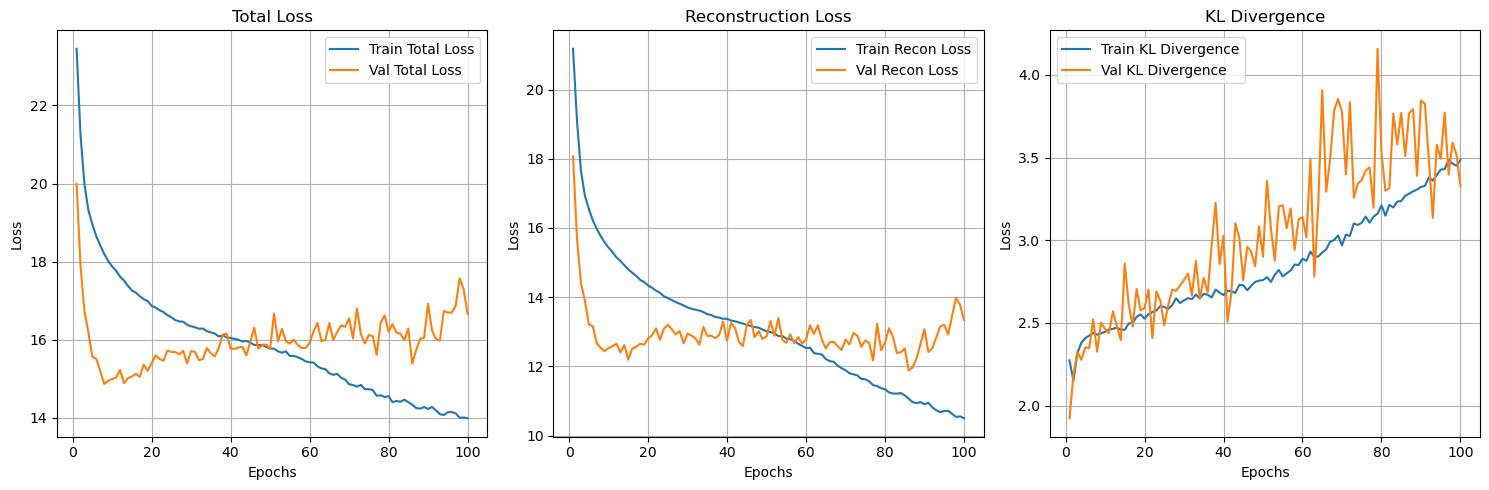

In [42]:
epochs = range(1, len(history['total_loss']) + 1)
plt.figure(figsize=(15, 5))
# Total loss
plt.subplot(1, 3, 1)
plt.plot(epochs, history['total_loss'], label='Train Total Loss')
plt.plot(epochs, history['val_total_loss'], label='Val Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()
plt.grid(True)
# Reconstruction loss
plt.subplot(1, 3, 2)
plt.plot(epochs, history['reconstruction_loss'], label='Train Recon Loss')
plt.plot(epochs, history['val_reconstruction_loss'], label='Val Recon Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.grid(True)
# KL divergence
plt.subplot(1, 3, 3)
plt.plot(epochs, history['kl_div'], label='Train KL Divergence')
plt.plot(epochs, history['val_kl_div'], label='Val KL Divergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('KL Divergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/home/samu/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


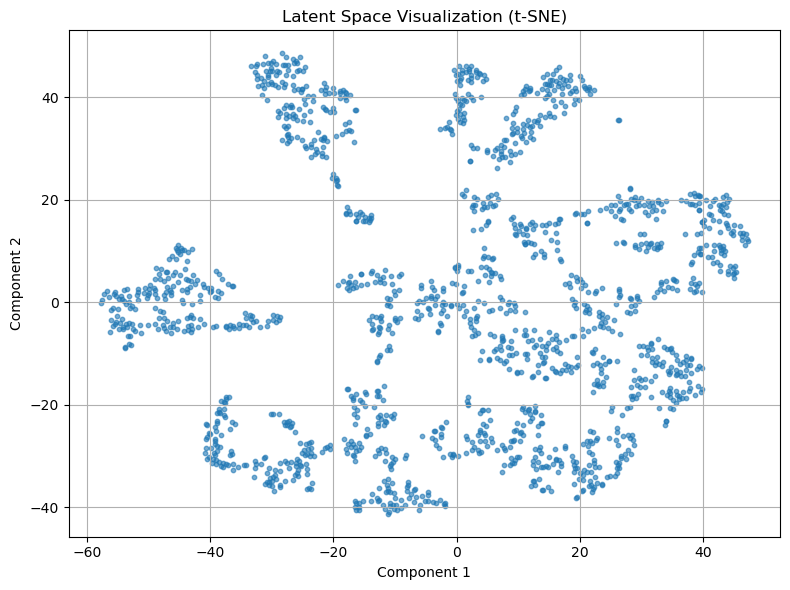

In [43]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

def plot_latent_space(model, data_loader, device, perplexity=30):
    model.eval()
    latents = []

    with torch.no_grad():
        for x_batch, _ in data_loader:
            x_batch = x_batch.to(device)
            mu, _ = model.encode(x_batch)  # ottieni solo le medie (mu) dallo spazio latente
            latents.append(mu.cpu())

    # Concatenazione di tutti i batch
    latents = torch.cat(latents).numpy()

    # Riduzione a 2D con t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200, n_iter=1000, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(latents_2d[:, 0], latents_2d[:, 1], alpha=0.6, s=10)
    plt.title("Latent Space Visualization (t-SNE)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_latent_space(best_model, test_loader, DEVICE)


In [30]:
torch.save(best_model.state_dict(), f"vae_best_model_weights.pt")

with open("vae_best_model.json", "w") as f:
    json.dump(best_params, f)